# Predictive Capabilities of Various Machine Learning Algorithms for Solar Forecasting

### Background

Solar PV has been becoming a more significant part of the electric grid in the United States over the past 20 years and its role is only expected to increase. The Solar Energy Industries Association (SEIA) estimates there were close to 90,000 MWdc of installations in the US in 2020. 

![SEIA Cumulative US PV Installations](Images/Cumulative_PV_Installtions_US.png)
Source: [SEIA](https://www.seia.org/solar-industry-research-data)

With more and more solar PV contributing to electricity production in the United States, better forecasting models will be needed to maintain the stability of the electric grid and optimize the utilization of grid resources such as energy storage devices as well as other types of generating facilities. 

For this project I have downloaded 30 minute interval weather data from various locations around Pittsburgh, Pennsylvania from the National Renewable Energy Lab's [National Soalar Radiation Database (NSRDB) viewer](https://maps.nrel.gov/nsrdb-viewer/). I will use this data to forecast the Global Horizontal Irradiance(GHI) in Pittsburgh 4 hours ahead of the most recent measurements. GHI is the combination of Direct Normal Irradiance (DNI) and Diffuse Horizontal Irradiance (DHI) and is the most important value to know when calculating the production of a PV array.

![GHI vs DNI and DHI](Images/GHI_DNI_DHI.png)
Source: [Homer Energy](https://www.homerenergy.com/products/pro/docs/latest/global_horizontal_irradiance_ghi.html)

The locations from which data was gathered can be seen below.

![City Data Sources](Images/City_Data_Sources.png)

In this notebook, a few machine learning algorithms will be explored to determine which may be the most useful for the task of forecasting GHI.

## Data

As stated before, data was acquired from NREL's NSRDB for various locations around Pittsburgh, PA. Data was collected and reported in 30 minute increments. Data was collected for the years 1998-2019. A sample of the data can be seen below.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

# Load Pittsburgh-only data
with open('PIT_dict.pkl', 'rb') as f:
    PIT_dict = pickle.load(f)

PIT_df = PIT_dict['complete_data']
# Use only the weather-related columns, not time
cols = list(PIT_df.columns)


PIT_weather = PIT_df[cols].copy()

PIT_weather.head()

Time_X    Time_Y     Day_X     Day_Y  PIT_DHI  PIT_DNI  PIT_GHI  \
0  0.000000  1.000000  0.017213  0.999852        0        0        0   
1  0.130526  0.991445  0.017213  0.999852        0        0        0   
2  0.258819  0.965926  0.017213  0.999852        0        0        0   
3  0.382683  0.923880  0.017213  0.999852        0        0        0   
4  0.500000  0.866025  0.017213  0.999852        0        0        0   

   PIT_Clearsky DHI  PIT_Clearsky DNI  PIT_Clearsky GHI  PIT_Dew Point  \
0                 0                 0                 0          -14.0   
1                 0                 0                 0          -14.0   
2                 0                 0                 0          -14.0   
3                 0                 0                 0          -14.0   
4                 0                 0                 0          -14.0   

   PIT_Surface Albedo  PIT_Wind_X  PIT_Wind_Y  PIT_Relative Humidity  \
0               0.866   -0.524772   -0.290886                  81.30   
1               0.866   -0.524772   -0.290886                  81.32   
2               0.866   -0.508829   -0.317952                  79.56   
3               0.866   -0.508829   -0.317952                  79.57   
4               0.866   -0.430146   -0.418299                  78.91   

   PIT_Temperature  PIT_Pressure  \
0            -11.0           990   
1            -11.0           990   
2            -11.0           990   
3            -11.0           990   
4            -12.0           990   

   PIT_Global Horizontal UV Irradiance (280-400nm)  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   PIT_Global Horizontal UV Irradiance (295-385nm)  
0                                              0.0  
1                                              0.0  
2                                              0.0  
3                                              0.0  
4                                              0.0

Above is a sample of the weather data collected only from Pittsburgh. The columns **Time_X** and **Time_Y** represent the x and y coordinates of the time if time were mapped to a unit circle with midnight at (0, 1) and progressing in a clockwise fashion for the duration of a single day. In this scenario noon would be represented by the coordinates (0, -1). Similarly, **Day_X** and **Day_Y** represent the x and y coordinated of the day of the year mapped to a unit circle with January 1 at approximately (0, 1) and progressing in a clockwise fashion for the duration of the year. 

The full data has only one column for each of  **Time_X**, **Time_Y**, **Day_X** and **Day_Y**, but for each of the other columns, there are 15 columns, one for each city.

In [2]:
# Load full-city data
with open('full_cities_dict.pkl', 'rb') as f:
    full_cities_dict = pickle.load(f)

full_cities_df = full_cities_dict['complete_data']
# Use only the weather-related columns, not time
cols = list(full_cities_df.columns)

full_cities_weather = full_cities_df[cols].copy()

full_cities_weather.head()


Time_X    Time_Y     Day_X     Day_Y  PIT_DHI  PIT_DNI  PIT_GHI  \
0  0.000000  1.000000  0.017213  0.999852        0        0        0   
1  0.130526  0.991445  0.017213  0.999852        0        0        0   
2  0.258819  0.965926  0.017213  0.999852        0        0        0   
3  0.382683  0.923880  0.017213  0.999852        0        0        0   
4  0.500000  0.866025  0.017213  0.999852        0        0        0   

   PIT_Clearsky DHI  PIT_Clearsky DNI  PIT_Clearsky GHI  ...  \
0                 0                 0                 0  ...   
1                 0                 0                 0  ...   
2                 0                 0                 0  ...   
3                 0                 0                 0  ...   
4                 0                 0                 0  ...   

   YGT_Clearsky GHI  YGT_Dew Point  YGT_Surface Albedo  YGT_Wind_X  \
0                 0          -13.0               0.866   -0.424946   
1                 0          -13.0               0.866   -0.424946   
2                 0          -13.0               0.866   -0.381334   
3                 0          -13.0               0.866   -0.381334   
4                 0          -14.0               0.866   -0.288929   

   YGT_Wind_Y  YGT_Relative Humidity  YGT_Temperature  YGT_Pressure  \
0   -0.263478                  81.02            -10.0           990   
1   -0.263478                  81.03            -10.0           990   
2   -0.323395                  78.83            -10.0           990   
3   -0.323395                  78.84            -10.0           990   
4   -0.408069                  76.75            -11.0           990   

   YGT_Global Horizontal UV Irradiance (280-400nm)  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   YGT_Global Horizontal UV Irradiance (295-385nm)  
0                                              0.0  
1                                              0.0  
2                                              0.0  
3                                              0.0  
4                                              0.0  

[5 rows x 229 columns]

## Data Preparation

Various machine learning techniques will be demonstrated all with the aim of predicting the GHI in Pittsburgh 4 hours ahead of the latest weather measurements. However, differeing amounts of look-back data will be incorporated. For example, one trial will only use the current measuremnts, will another will use the current and previous measurement (taken 30 minutes prior), yet another will use the current and 3 previous measurements. 

After creating these new datasets, they must be split into training, validation, and testing sets and then normalized.

In [3]:
# creates time-based columns to relect the desired features looking back in time and outputs the feature df and target df
def feature_target_split(df, look_back_steps, forecast_ahead_steps, target_col_name):
    
    feature_names = df.columns
    t_steps_back = range(look_back_steps + 1)
    time_features = pd.DataFrame()
    target_feature = pd.DataFrame()
    for feature in feature_names:
        if (feature == 'Day_X') or (feature == 'Day_Y') or (feature == 'Time_X') or (feature == 'Time_Y'):
            time_features[feature] = df[feature].iloc[look_back_steps : 0 - forecast_ahead_steps].reset_index(drop=True)
        else:
            for t_back in t_steps_back:
                t_feature_col_name = feature + "-" + str(t_back)
                time_features[t_feature_col_name] = df[feature].iloc[(look_back_steps - t_back) : 0 - forecast_ahead_steps - t_back].reset_index(drop=True)
    new_target_col_name = target_col_name + "+" + str(forecast_ahead_steps)
    target_feature[new_target_col_name] = df[target_col_name].iloc[look_back_steps + forecast_ahead_steps : ].reset_index(drop=True)

    return time_features, target_feature

In [4]:
# creates differerent datasets based on how many look-back measurements are used
current_only_features, current_only_target = feature_target_split(full_cities_weather, 0, 8, 'PIT_GHI')
current_and_previous_features, current_and_previous_target = feature_target_split(full_cities_weather, 1, 8, 'PIT_GHI')
current_and_previous_3_features, current_and_previous_3_target = feature_target_split(full_cities_weather, 3, 8, 'PIT_GHI')


### Train/Test/Val Split

In [5]:
from sklearn.model_selection import train_test_split

# split all datasets into train_val and test sets
X_current_only_train_val, X_current_only_test, y_current_only_train_val, y_current_only_test = \
train_test_split(current_only_features, current_only_target, test_size=0.2, shuffle=False)

X_current_and_previous_train_val, X_current_and_previous_test, y_current_and_previous_train_val, y_current_and_previous_test = \
train_test_split(current_and_previous_features, current_and_previous_target, test_size=0.2, shuffle=False)

X_current_and_previous_3_train_val, X_current_and_previous_3_test, y_current_and_previous_3_train_val, y_current_and_previous_3_test = \
train_test_split(current_and_previous_3_features, current_and_previous_3_target, test_size=0.2, shuffle=False)

# split all train_val sets into train and val sets
X_current_only_train, X_current_only_val, y_current_only_train, y_current_only_val = \
train_test_split(X_current_only_train_val, y_current_only_train_val, test_size=0.2, shuffle=False)

X_current_and_previous_train, X_current_and_previous_val, y_current_and_previous_train, y_current_and_previous_val = \
train_test_split(X_current_and_previous_train_val, y_current_and_previous_train_val, test_size=0.2, shuffle=False)

X_current_and_previous_3_train, X_current_and_previous_3_val, y_current_and_previous_3_train, y_current_and_previous_3_val = \
train_test_split(X_current_and_previous_3_train_val, y_current_and_previous_3_train_val, test_size=0.2, shuffle=False)
 


### Check Rank of each X, and remove highly correlated features

#### For X_Current_Only

In [6]:
print('\nShape of X_current_only_train:')
print(X_current_only_train.shape)
print('\nShape of X_current_only_val:')
print(X_current_only_val.shape)
print('\nShape of X_current_only_train_val:')
print(X_current_only_train_val.shape)
print('\nShape of X_current_only_test:')
print(X_current_only_test.shape)


Shape of X_current_only_train:
(246676, 229)

Shape of X_current_only_val:
(61669, 229)

Shape of X_current_only_train_val:
(308345, 229)

Shape of X_current_only_test:
(77087, 229)


In [7]:
print('\nRank of X_current_only_train:')
A = X_current_only_train.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_val:')
A = X_current_only_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_train_val:')
A = X_current_only_train_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_test:')
A = X_current_only_test.to_numpy()
print(np.linalg.matrix_rank(A))


Rank of X_current_only_train:
225

Rank of X_current_only_val:
225

Rank of X_current_only_train_val:
225

Rank of X_current_only_test:
229


In [8]:
corr = X_current_only_train.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.98:
            if columns[j]:
                columns[j] = False
selected_columns = X_current_only_train.columns[columns]
X_current_only_train = X_current_only_train[selected_columns]
X_current_only_val = X_current_only_val[selected_columns]
X_current_only_train_val = X_current_only_train_val[selected_columns]
X_current_only_test = X_current_only_test[selected_columns]


In [9]:
print('\nShape of X_current_only_train:')
print(X_current_only_train.shape)
print('\nShape of X_current_only_val:')
print(X_current_only_val.shape)
print('\nShape of X_current_only_train_val:')
print(X_current_only_train_val.shape)
print('\nShape of X_current_only_test:')
print(X_current_only_test.shape)


Shape of X_current_only_train:
(246676, 133)

Shape of X_current_only_val:
(61669, 133)

Shape of X_current_only_train_val:
(308345, 133)

Shape of X_current_only_test:
(77087, 133)


In [10]:
print('\nRank of X_current_only_train:')
A = X_current_only_train.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_val:')
A = X_current_only_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_train_val:')
A = X_current_only_train_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_test:')
A = X_current_only_test.to_numpy()
print(np.linalg.matrix_rank(A))


Rank of X_current_only_train:
133

Rank of X_current_only_val:
133

Rank of X_current_only_train_val:
133

Rank of X_current_only_test:
133


#### For X_Current_and_Previous

In [11]:
print('\nShape of X_current_and_previous_train:')
print(X_current_and_previous_train.shape)
print('\nShape of X_current_and_previous_val:')
print(X_current_and_previous_val.shape)
print('\nShape of X_current_and_previous_train_val:')
print(X_current_and_previous_train_val.shape)
print('\nShape of X_current_and_previous_test:')
print(X_current_and_previous_test.shape)


Shape of X_current_and_previous_train:
(246675, 454)

Shape of X_current_and_previous_val:
(61669, 454)

Shape of X_current_and_previous_train_val:
(308344, 454)

Shape of X_current_and_previous_test:
(77087, 454)


In [12]:
print('\nRank of X_current_and_previous_train:')
A = X_current_and_previous_train.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_val:')
A = X_current_and_previous_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_and_previous_val:')
A = X_current_and_previous_train_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_test:')
A = X_current_and_previous_test.to_numpy()
print(np.linalg.matrix_rank(A))


Rank of X_current_and_previous_train:
446

Rank of X_current_and_previous_val:
446

Rank of X_current_only_and_previous_val:
446

Rank of X_current_and_previous_test:
454


In [13]:
corr = X_current_and_previous_train.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.98:
            if columns[j]:
                columns[j] = False
selected_columns = X_current_and_previous_train.columns[columns]
X_current_and_previous_train = X_current_and_previous_train[selected_columns]
X_current_and_previous_val = X_current_and_previous_val[selected_columns]
X_current_and_previous_train_val = X_current_and_previous_train_val[selected_columns]
X_current_and_previous_test = X_current_and_previous_test[selected_columns]

In [14]:
print('\nShape of X_current_and_previous_train:')
print(X_current_and_previous_train.shape)
print('\nShape of X_current_and_previous_val:')
print(X_current_and_previous_val.shape)
print('\nShape of X_current_and_previous_train_val:')
print(X_current_and_previous_train_val.shape)
print('\nShape of X_current_and_previous_test:')
print(X_current_and_previous_test.shape)


Shape of X_current_and_previous_train:
(246675, 199)

Shape of X_current_and_previous_val:
(61669, 199)

Shape of X_current_and_previous_train_val:
(308344, 199)

Shape of X_current_and_previous_test:
(77087, 199)


In [15]:
print('\nRank of X_current_and_previous_train:')
A = X_current_and_previous_train.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_val:')
A = X_current_and_previous_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_and_previous_val:')
A = X_current_and_previous_train_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_test:')
A = X_current_and_previous_test.to_numpy()
print(np.linalg.matrix_rank(A))


Rank of X_current_and_previous_train:
199

Rank of X_current_and_previous_val:
199

Rank of X_current_only_and_previous_val:
199

Rank of X_current_and_previous_test:
199


#### For X_Current_and_Previous_3

In [16]:
print('\nShape of X_current_and_previous_3_train:')
print(X_current_and_previous_3_train.shape)
print('\nShape of X_current_and_previous_3_val:')
print(X_current_and_previous_3_val.shape)
print('\nShape of X_current_and_previous_3_train_val:')
print(X_current_and_previous_3_train_val.shape)
print('\nShape of X_current_and_previous_3_test:')
print(X_current_and_previous_3_test.shape)


Shape of X_current_and_previous_3_train:
(246674, 904)

Shape of X_current_and_previous_3_val:
(61669, 904)

Shape of X_current_and_previous_3_train_val:
(308343, 904)

Shape of X_current_and_previous_3_test:
(77086, 904)


In [17]:
print('\nRank of X_current_and_previous_3_train:')
A = X_current_and_previous_3_train.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_3_val:')
A = X_current_and_previous_3_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_and_previous_3_val:')
A = X_current_and_previous_3_train_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_3_test:')
A = X_current_and_previous_3_test.to_numpy()
print(np.linalg.matrix_rank(A))


Rank of X_current_and_previous_3_train:
888

Rank of X_current_and_previous_3_val:
888

Rank of X_current_only_and_previous_3_val:
888

Rank of X_current_and_previous_3_test:
904


In [18]:
corr = X_current_and_previous_3_train.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.98:
            if columns[j]:
                columns[j] = False
selected_columns = X_current_and_previous_3_train.columns[columns]
X_current_and_previous_3_train = X_current_and_previous_3_train[selected_columns]
X_current_and_previous_3_val = X_current_and_previous_3_val[selected_columns]
X_current_and_previous_3_train_val = X_current_and_previous_3_train_val[selected_columns]
X_current_and_previous_3_test = X_current_and_previous_3_test[selected_columns]

In [19]:
print('\nShape of X_current_and_previous_3_train:')
print(X_current_and_previous_3_train.shape)
print('\nShape of X_current_and_previous_3_val:')
print(X_current_and_previous_3_val.shape)
print('\nShape of X_current_and_previous_3_train_val:')
print(X_current_and_previous_3_train_val.shape)
print('\nShape of X_current_and_previous_3_test:')
print(X_current_and_previous_3_test.shape)


Shape of X_current_and_previous_3_train:
(246674, 331)

Shape of X_current_and_previous_3_val:
(61669, 331)

Shape of X_current_and_previous_3_train_val:
(308343, 331)

Shape of X_current_and_previous_3_test:
(77086, 331)


In [20]:
print('\nRank of X_current_and_previous_3_train:')
A = X_current_and_previous_3_train.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_3_val:')
A = X_current_and_previous_3_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_only_and_previous_3_val:')
A = X_current_and_previous_3_train_val.to_numpy()
print(np.linalg.matrix_rank(A))

print('\nRank of X_current_and_previous_3_test:')
A = X_current_and_previous_3_test.to_numpy()
print(np.linalg.matrix_rank(A))


Rank of X_current_and_previous_3_train:
331

Rank of X_current_and_previous_3_val:
331

Rank of X_current_only_and_previous_3_val:
331

Rank of X_current_and_previous_3_test:
331


### Scale all data

In [21]:
from sklearn.preprocessing import StandardScaler

# scaler for current_only_train data
X_current_only_train_scaler = StandardScaler()
y_current_only_train_scaler = StandardScaler()

# fit and transform current_only_train sets
X_current_only_train_norm = X_current_only_train_scaler.fit_transform(X_current_only_train)
y_current_only_train_norm = y_current_only_train_scaler.fit_transform(y_current_only_train)

# transform current_only_val set
X_current_only_val_norm = X_current_only_train_scaler.transform(X_current_only_val)

# scaler for current_only_train_val data
X_current_only_train_val_scaler = StandardScaler()
y_current_only_train_val_scaler = StandardScaler()

# fit and transform current_only_train_val sets
X_current_only_train_val_norm = X_current_only_train_val_scaler.fit_transform(X_current_only_train_val)
y_current_only_train_val_norm = y_current_only_train_val_scaler.fit_transform(y_current_only_train_val)

# transform current_only_test set
X_current_only_test_norm = X_current_only_train_val_scaler.transform(X_current_only_test)




# sclaer for current_and_previous_train data
X_current_and_previous_train_scaler = StandardScaler()
y_current_and_previous_train_scaler = StandardScaler()

# fit and transform current_and_previous_train sets
X_current_and_previous_train_norm = X_current_and_previous_train_scaler.fit_transform(X_current_and_previous_train)
y_current_and_previous_train_norm = y_current_and_previous_train_scaler.fit_transform(y_current_and_previous_train)

# transform current_and_previous_val set
X_current_and_previous_val_norm = X_current_and_previous_train_scaler.transform(X_current_and_previous_val)

# scaler for current_and_previous_train_val data
X_current_and_previous_train_val_scaler = StandardScaler()
y_current_and_previous_train_val_scaler = StandardScaler()

# fit and transform current_and_previous_train_val sets
X_current_and_previous_train_val_norm = X_current_and_previous_train_val_scaler.fit_transform(X_current_and_previous_train_val)
y_current_and_previous_train_val_norm = y_current_and_previous_train_val_scaler.fit_transform(y_current_and_previous_train_val)

# transform current_and_previous_test set
X_current_and_previous_test_norm = X_current_and_previous_train_val_scaler.transform(X_current_and_previous_test)




# sclaer for current_and_previous_3_train data
X_current_and_previous_3_train_scaler = StandardScaler()
y_current_and_previous_3_train_scaler = StandardScaler()

# fit and transform current_and_previous_3_train sets
X_current_and_previous_3_train_norm = X_current_and_previous_3_train_scaler.fit_transform(X_current_and_previous_3_train)
y_current_and_previous_3_train_norm = y_current_and_previous_3_train_scaler.fit_transform(y_current_and_previous_3_train)

# transform current_and_previous_3_val set
X_current_and_previous_3_val_norm = X_current_and_previous_3_train_scaler.transform(X_current_and_previous_3_val)

# scaler for current_and_previous_3_train_val data
X_current_and_previous_3_train_val_scaler = StandardScaler()
y_current_and_previous_3_train_val_scaler = StandardScaler()

# fit and transform current_and_previous_3_train_val sets
X_current_and_previous_3_train_val_norm = X_current_and_previous_3_train_val_scaler.fit_transform(X_current_and_previous_3_train_val)
y_current_and_previous_3_train_val_norm = y_current_and_previous_3_train_val_scaler.fit_transform(y_current_and_previous_3_train_val)

# transform current_and_previous_3_test set
X_current_and_previous_3_test_norm = X_current_and_previous_3_train_val_scaler.transform(X_current_and_previous_3_test)

X_current_only_train

Time_X    Time_Y     Day_X     Day_Y  PIT_DHI-0  PIT_DNI-0  \
0       0.000000  1.000000  0.017213  0.999852          0          0   
1       0.130526  0.991445  0.017213  0.999852          0          0   
2       0.258819  0.965926  0.017213  0.999852          0          0   
3       0.382683  0.923880  0.017213  0.999852          0          0   
4       0.500000  0.866025  0.017213  0.999852          0          0   
...          ...       ...       ...       ...        ...        ...   
246671 -0.130526  0.991445  0.478734  0.877960          0          0   
246672  0.000000  1.000000  0.493776  0.869589          0          0   
246673  0.130526  0.991445  0.493776  0.869589          0          0   
246674  0.258819  0.965926  0.493776  0.869589          0          0   
246675  0.382683  0.923880  0.493776  0.869589          0          0   

        PIT_GHI-0  PIT_Clearsky DHI-0  PIT_Clearsky DNI-0  PIT_Clearsky GHI-0  \
0               0                   0                   0                   0   
1               0                   0                   0                   0   
2               0                   0                   0                   0   
3               0                   0                   0                   0   
4               0                   0                   0                   0   
...           ...                 ...                 ...                 ...   
246671          0                   0                   0                   0   
246672          0                   0                   0                   0   
246673          0                   0                   0                   0   
246674          0                   0                   0                   0   
246675          0                   0                   0                   0   

        ...  WHE_Wind_X-0  WHE_Wind_Y-0  WHE_Pressure-0  \
0       ...     -0.245143     -0.172930             990   
1       ...     -0.245143     -0.172930             990   
2       ...     -0.178026     -0.241468             990   
3       ...     -0.178026     -0.241468             990   
4       ...     -0.155006     -0.368745             990   
...     ...           ...           ...             ...   
246671  ...     -0.671864      0.196467             990   
246672  ...     -0.680943      0.162224             990   
246673  ...     -0.583666      0.139049             990   
246674  ...     -0.495134      0.069587             990   
246675  ...     -0.396107      0.055669             990   

        WHE_Global Horizontal UV Irradiance (280-400nm)-0  YGT_DHI-0  \
0                                                     0.0          0   
1                                                     0.0          0   
2                                                     0.0          0   
3                                                     0.0          0   
4                                                     0.0          0   
...                                                   ...        ...   
246671                                                0.0          0   
246672                                                0.0          0   
246673                                                0.0          0   
246674                                                0.0          0   
246675                                                0.0          0   

        YGT_DNI-0  YGT_GHI-0  YGT_Surface Albedo-0  YGT_Pressure-0  \
0               0          0                 0.866             990   
1               0          0                 0.866             990   
2               0          0                 0.866             990   
3               0          0                 0.866             990   
4               0          0                 0.866             990   
...           ...        ...                   ...             ...   
246671          0          0                 0.866             980   
246672          0          0          

In [22]:
from numpy import random

sample_num = list(range(4))
x = random.normal(loc=0.0, scale=1.0, size=(4,3))
df = pd.DataFrame({'x1': x[:,0], 'x2': x[:,1], 'y': x[:,2]}).reset_index()
z1 = np.dot(x[:,0], x[:,2])
z2 = np.dot(x[:,1], x[:,2])
print("z1:")
print(z1)
print("\nz2:")
print(z2)

z1:
-0.5997801865549461

z2:
0.1452173524458702


In [23]:
df = pd.DataFrame(np.array([[1, -1, 1.5, 1.2], 
                            [2, 1.2, 0.1, -0.1], 
                            [3, -0.2, -1.2, -1.4],
                            [4, -1.6, 0.8, 0.9]]),
                 columns=['time', 'x1', 'x2', 'y'])

df

time   x1   x2    y
0   1.0 -1.0  1.5  1.2
1   2.0  1.2  0.1 -0.1
2   3.0 -0.2 -1.2 -1.4
3   4.0 -1.6  0.8  0.9

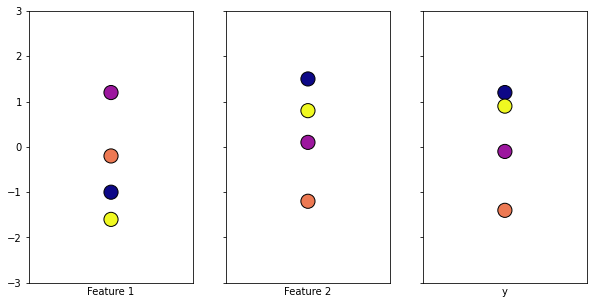

In [24]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(10,5))

axs[0].scatter(y=df['x1'], x=np.zeros(4), c=df['time'], s=200, cmap="plasma", edgecolors='black')
axs[1].scatter(y=df['x2'], x=np.zeros(4), c=df['time'], s=200, cmap="plasma", edgecolors='black')
axs[2].scatter(y=df['y'], x=np.zeros(4), c=df['time'], s=200, cmap="plasma", edgecolors='black')

axs[0].set(xlabel="Feature 1", ylim=([-3,3]))
axs[0].get_xaxis().set_ticks([])
axs[1].set(xlabel="Feature 2", xlim=([-3,3]))
axs[1].get_xaxis().set_ticks([])
axs[2].set(xlabel="y", xlim=([-3,3]))
axs[2].get_xaxis().set_ticks([])

plt.show()

## 2-D test set

### Linear Regression Demo

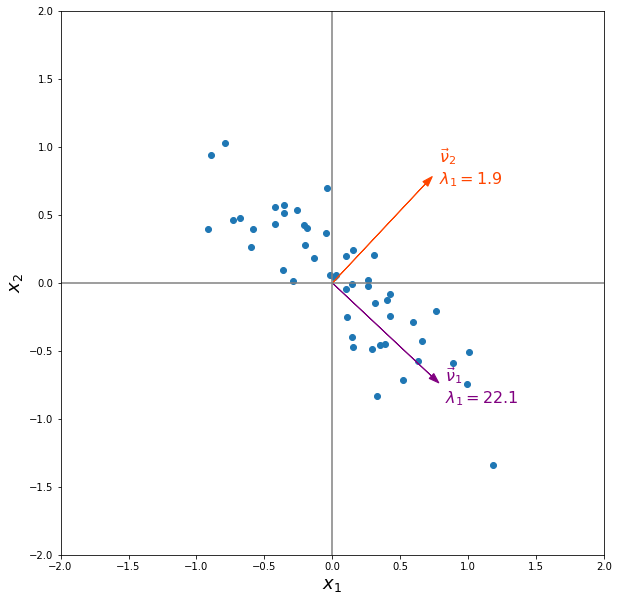

In [25]:
# sample data

evec1 = np.array([[np.cos(-45.* np.pi / 180.)],
                  [np.sin(-45.* np.pi / 180.)]])
evec2 = np.array([[np.cos(45.* np.pi / 180.)],
                  [np.sin(45.* np.pi / 180.)]])


eval1 = 0.5
eval2 = 0.05

D = np.array([[eval1, 0], 
              [0, eval2]])

P = np.concatenate((evec1, evec2),axis=1)

P_inv = np.linalg.inv(P)

PD = np.matmul(P,D) 
cov_mat = np.matmul(PD, P_inv)

x1 = [] 
x2 = []
for i in range(50):
    x = random.multivariate_normal([0, 0], cov_mat)
    x1.append(x[0])
    x2.append(x[1])

x1 = np.array([x1])
x1 = np.transpose(x1)
x2 = np.array([x2])
x2 = np.transpose(x2)

X = np.concatenate((x1, x2), axis=1)
X_T = np.transpose(X)
X_T_X = np.matmul(X_T, X)

samp_evals, samp_evecs = np.linalg.eig(X_T_X)

evec1 = samp_evecs[:,0]
evec2 = samp_evecs[:,1]

eval1 = samp_evals[0]
eval2 = samp_evals[1]

fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x1, x2)

plt.arrow(0,0, evec1[0], evec1[1], color='purple', head_width=0.05)
plt.arrow(0,0, evec2[0], evec2[1], color='orangered', head_width=0.05)
plt.text(evec1[0]+0.1, evec1[1]-0.2, r'$\vec{\nu}_1$'+'\n$\u03BB_1 = $'+ str(round(eval1,1)), color='purple', size=16)
plt.text(evec2[0]+0.1, evec2[1], r'$\vec{\nu}_2$'+'\n$\u03BB_1 = $'+ str(round(eval2,1)), color='orangered', size=16)

plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel('$x_1$', size=18)
plt.ylabel('$x_2$', size=18)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')

ax.set_aspect('equal', adjustable='box')

plt.show()   


In [26]:
# y ~ +2*x1 + 3*x2 + err

y = 2*x1 + 3*x2 
#+ random.normal(loc=0.0, scale=0.005, size=(x1.shape[0],1))


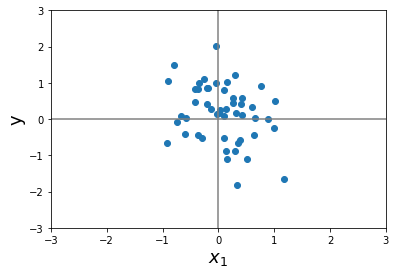

In [27]:
plt.scatter(x1, y)

plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xlabel('$x_1$', size=18)
plt.ylabel('y', size=18)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')


ax.set_aspect('equal', adjustable='box')


plt.show()   


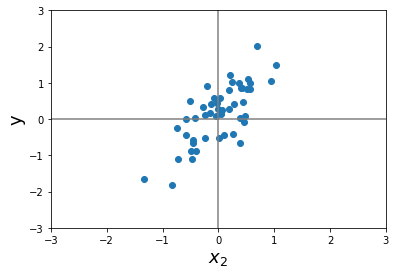

In [28]:
plt.scatter(x2, y)

plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xlabel('$x_2$', size=18)
plt.ylabel('y', size=18)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')

ax.set_aspect('equal', adjustable='box')


plt.show()   


In [29]:
z1 = np.dot(x1[:,0], y[:,0])
z2 = np.dot(x2[:,0], y[:,0])
print("z1:")
print(z1)
print('\nz2:')
print(z2)
A = np.linalg.inv(X_T_X)

theta_1 = np.dot(A[0,:], np.array([[z1],[z2]]))
theta_2 = np.dot(A[1,:], np.array([[z1],[z2]]))
print(theta_1)
print(theta_2)
rho_1 = z1*evec1[0] + z2*evec1[1]
rho_2 = z1*evec2[0] + z2*evec2[1]
print(rho_1)
print(rho_2)

gamma_1 = theta_1*evec1[0] + theta_2*evec1[1]
gamma_2 = theta_1*evec2[0] + theta_2*evec2[1]
gamma_1 = gamma_1[0]
gamma_2 = gamma_2[0]
print(gamma_1)
print(gamma_2)

z1:
-4.907149582053007

z2:
13.945238753503766
[2.]
[3.]
-13.120855252397513
6.8112376524754215
-0.5944110752601417
3.5562164548306217


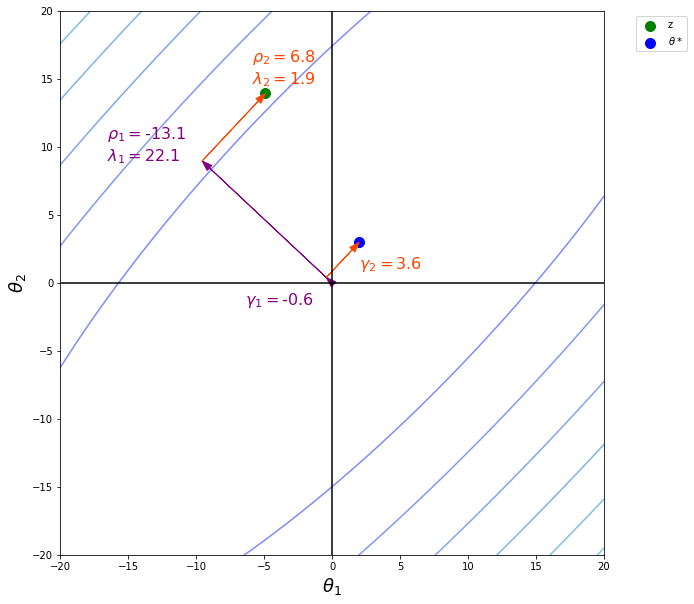

In [30]:
delta = 0.25
u1 = np.arange(-25.0, 25.0, delta)
u2 = np.arange(-25.0, 25.0, delta)
THETA_1, THETA_2 = np.meshgrid(u1, u2)
J = np.zeros(THETA_1.shape)
#print('\ntheta1')
#print(THETA_1)
#print('\ntheta2')
#print(THETA_2)
#print('\nJ')
#print(J)
#print('\ni')
#print(THETA_1[0])
#print('\nj')
#print(THETA_2[:,0])
for i in range(len(THETA_1[0])):
    for j in range(len(THETA_2[:,0])):
        err = y - x1*THETA_1[0][j] - x2*THETA_2[:,0][i]
        J[i,j] = (np.linalg.norm(err))**2

fig, ax = plt.subplots(figsize=(10,10))
CS = ax.contour(THETA_1, THETA_2, J, levels=10, alpha=0.5, cmap='winter')
plt.scatter(z1, z2, s=100, color='green', label='z')
plt.scatter(theta_1, theta_2, s=100, color='blue', label='$\u03B8*$')

# arrow to z
plt.arrow(0,0, rho_1*evec1[0], rho_1*evec1[1], color='purple', head_width=0.5, length_includes_head=True)
plt.arrow(rho_1*evec1[0], rho_1*evec1[1], rho_2*evec2[0], rho_2*evec2[1], color='orangered', head_width=0.5, length_includes_head=True)
plt.text(rho_1*evec1[0]-7, rho_1*evec1[1], '$\u03C1_1 = $'+ str(round(rho_1,1)) +'\n$\u03BB_1 = $'+ str(round(eval1,1)), color='purple', size=16)
plt.text(z1-1, z2+0.7, '$\u03C1_2 =$'+ str(round(rho_2,1)) +'\n$\u03BB_2 = $'+ str(round(eval2,1)), color='orangered', size=16)

# arrow to theta (linear regressioin optima)
plt.arrow(0,0, gamma_1*evec1[0], gamma_1*evec1[1], color='purple', head_width=0.5, length_includes_head=True)
plt.arrow(gamma_1*evec1[0], gamma_1*evec1[1], gamma_2*evec2[0], gamma_2*evec2[1], color='orangered', head_width=0.5, length_includes_head=True)
plt.text(gamma_1*evec1[0]-6, gamma_1*evec1[1]-2, '$\u03B3_1 = $'+ str(round(gamma_1,1)), color='purple', size=16)
plt.text(theta_1, theta_2-2, '$\u03B3_2 = $'+ str(round(gamma_2,1)), color='orangered', size=16)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
ax.set_aspect('equal', adjustable='box')
ax.set_title('')
ax.set_xlabel('$\u03B8_1$', size=18)
ax.set_ylabel('$\u03B8_2$', size=18)
plt.xlim([-20,20])
plt.ylim([-20,20])

plt.show()

### Ridge Regression Demo


In [31]:
alpha1 = 1
S_inv = X_T_X + alpha1*np.identity(X_T_X.shape[0])
S = np.linalg.inv(S_inv)

ridge_theta1_1 = np.dot(S[0,:], np.array([[z1],[z2]]))
ridge_theta2_1 = np.dot(S[1,:], np.array([[z1],[z2]]))
print('\nridge regression optimal theta:')
print(ridge_theta1_1)
print(ridge_theta2_1)

c1 = ridge_theta1_1[0]**2 + ridge_theta2_1[0]**2 
print('\nsquared magnitude of theta:')
print(c1)


ridge_gamma1_1 = ridge_theta1_1*evec1[0] + ridge_theta2_1*evec1[1]
ridge_gamma2_1 = ridge_theta1_1*evec2[0] + ridge_theta2_1*evec2[1]
ridge_gamma1_1 = ridge_gamma1_1[0]
ridge_gamma2_1 = ridge_gamma2_1[0]



alpha2 = 3
S_inv = X_T_X + alpha2*np.identity(X_T_X.shape[0])
S = np.linalg.inv(S_inv)

ridge_theta1_2 = np.dot(S[0,:], np.array([[z1],[z2]]))
ridge_theta2_2 = np.dot(S[1,:], np.array([[z1],[z2]]))
print('\nridge regression optimal theta:')
print(ridge_theta1_2)
print(ridge_theta2_2)

c2 = ridge_theta1_2[0]**2 + ridge_theta2_2[0]**2 
print('\nsquared magnitude of theta:')
print(c2)


ridge_gamma1_2 = ridge_theta1_2*evec1[0] + ridge_theta2_2*evec1[1]
ridge_gamma2_2 = ridge_theta1_2*evec2[0] + ridge_theta2_2*evec2[1]
ridge_gamma1_2 = ridge_gamma1_2[0]
ridge_gamma2_2 = ridge_gamma2_2[0]




alpha3 = 15
S_inv = X_T_X + alpha3*np.identity(X_T_X.shape[0])
S = np.linalg.inv(S_inv)

ridge_theta1_3 = np.dot(S[0,:], np.array([[z1],[z2]]))
ridge_theta2_3 = np.dot(S[1,:], np.array([[z1],[z2]]))
print('\nridge regression optimal theta:')
print(ridge_theta1_3)
print(ridge_theta2_3)

c3 = ridge_theta1_3[0]**2 + ridge_theta2_3[0]**2 
print('\nsquared magnitude of theta:')
print(c3)


ridge_gamma1_3 = ridge_theta1_3*evec1[0] + ridge_theta2_3*evec1[1]
ridge_gamma2_3 = ridge_theta1_3*evec2[0] + ridge_theta2_3*evec2[1]
ridge_gamma1_3 = ridge_gamma1_3[0]
ridge_gamma2_3 = ridge_gamma2_3[0]


ridge regression optimal theta:
[1.18406844]
[2.09284045]

squared magnitude of theta:
5.781999242897812

ridge regression optimal theta:
[0.56663026]
[1.36857042]

squared magnitude of theta:
2.1940548441379417

ridge regression optimal theta:
[0.01745857]
[0.53580802]

squared magnitude of theta:
0.2873950389998793


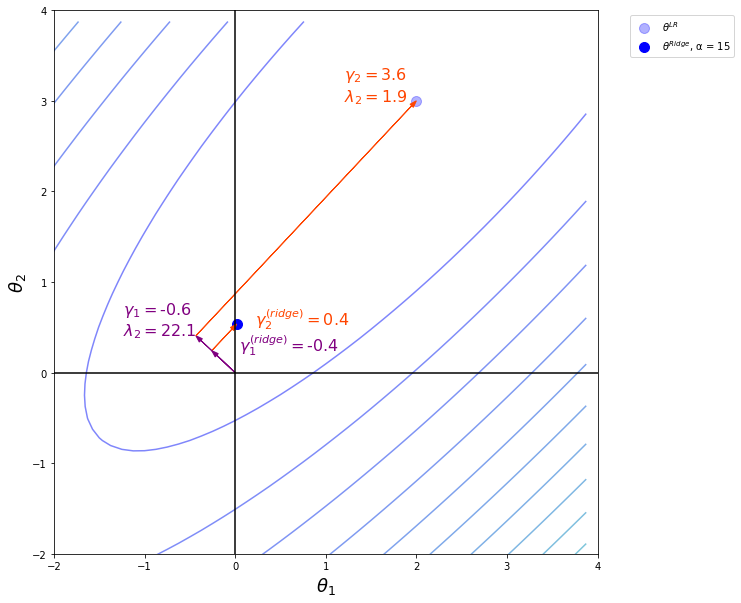

In [32]:
delta = 0.125
u1 = np.arange(-4.0, 4.0, delta)
u2 = np.arange(-4.0, 4.0, delta)
THETA_1, THETA_2 = np.meshgrid(u1, u2)
J = np.zeros(THETA_1.shape)

for i in range(len(THETA_1[0])):
    for j in range(len(THETA_2[:,0])):
        err = y - x1*THETA_1[0][j] - x2*THETA_2[:,0][i]
        J[i,j] = (np.linalg.norm(err,2))**2

fig, ax = plt.subplots(figsize=(10,10))
CS = ax.contour(THETA_1, THETA_2, J, levels=20, alpha=0.5, cmap='winter')

plt.scatter(theta_1, theta_2, s=100, color='blue', alpha=0.3, label='$\u03B8^{LR}$')
plt.scatter(ridge_theta1_3, ridge_theta2_3, s=100, color='blue', label='$\u03B8^{Ridge}$, \u03B1 = '+str(alpha3))

# arrows to ridge regression optima
plt.arrow(0,0, ridge_gamma1_3*evec1[0], ridge_gamma1_3*evec1[1], color='purple', head_width=0.05, length_includes_head=True)
plt.arrow(ridge_gamma1_3*evec1[0], ridge_gamma1_3*evec1[1], ridge_gamma2_3*evec2[0], ridge_gamma2_3*evec2[1], color='orangered', head_width=0.05, length_includes_head=True)
plt.text(ridge_gamma1_3*evec1[0]+0.3, ridge_gamma1_3*evec1[1], '$\u03B3_1^{(ridge)} = $'+ str(round(ridge_gamma1_3,1)), color='purple', size=16)
plt.text(ridge_theta1_3+0.2, ridge_theta2_3, '$\u03B3_2^{(ridge)} = $'+ str(round(ridge_gamma2_3,1)), color='orangered', size=16)

# arrows to linear regression optima
plt.arrow(0,0, gamma_1*evec1[0], gamma_1*evec1[1], color='purple', head_width=0.05, length_includes_head=True)
plt.arrow(gamma_1*evec1[0], gamma_1*evec1[1], gamma_2*evec2[0], gamma_2*evec2[1], color='orangered', head_width=0.05, length_includes_head=True)
plt.text(gamma_1*evec1[0]-0.8, gamma_1*evec1[1], '$\u03B3_1 = $'+ str(round(gamma_1,1))+'\n$\u03BB_2 = $'+ str(round(eval1,1)), color='purple', size=16)
plt.text(theta_1-0.8, theta_2, '$\u03B3_2 = $'+ str(round(gamma_2,1))+'\n$\u03BB_2 = $'+ str(round(eval2,1)), color='orangered', size=16)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlim([-2,4])
plt.ylim([-2,4])
ax.set_aspect('equal', adjustable='box')
ax.set_title('')
ax.set_xlabel('$\u03B8_1$', size=18)
ax.set_ylabel('$\u03B8_2$', size=18)

plt.show()

In [33]:
theta_1_cords = []
theta_2_cords = []
for i in range(40):
    alpha = (2**(i/4))-1
    S_inv = X_T_X + alpha*np.identity(X_T_X.shape[0])
    S = np.linalg.inv(S_inv)

    theta_1_cords.append(np.dot(S[0,:], np.array([[z1],[z2]])))
    theta_2_cords.append(np.dot(S[1,:], np.array([[z1],[z2]])))

    

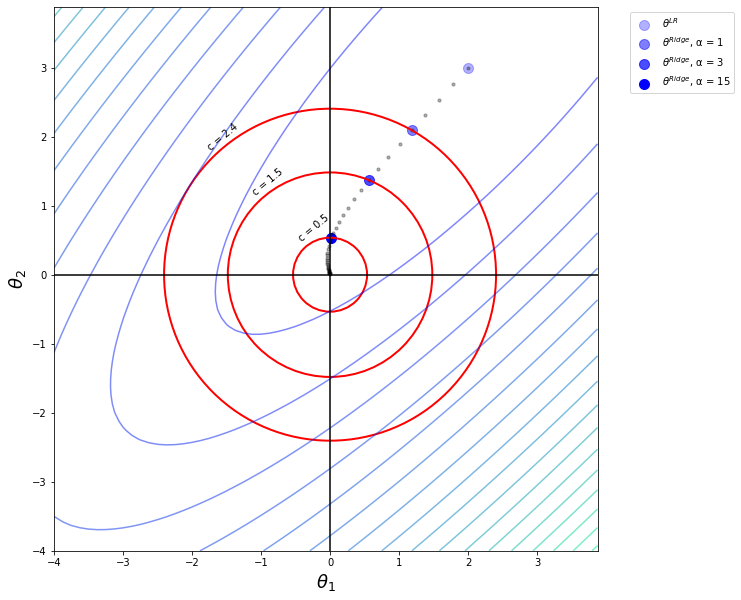

In [34]:
delta = 0.125
u1 = np.arange(-4.0, 4.0, delta)
u2 = np.arange(-4.0, 4.0, delta)
THETA_1, THETA_2 = np.meshgrid(u1, u2)
J = np.zeros(THETA_1.shape)
#print('\ntheta1')
#print(THETA_1)
#print('\ntheta2')
#print(THETA_2)
#print('\nJ')
#print(J)
#print('\ni')
#print(THETA_1[0])
#print('\nj')
#print(THETA_2[:,0])
for i in range(len(THETA_1[0])):
    for j in range(len(THETA_2[:,0])):
        err = y - x1*THETA_1[0][j] - x2*THETA_2[:,0][i]
        J[i,j] = (np.linalg.norm(err,2))**2

fig, ax = plt.subplots(figsize=(10,10))
CS = ax.contour(THETA_1, THETA_2, J, levels=20, alpha=0.5, cmap='winter')

plt.scatter(theta_1, theta_2, s=100, color='blue', alpha=0.3, label='$\u03B8^{LR}$')
plt.scatter(ridge_theta1_1, ridge_theta2_1, s=100, color='blue', alpha=0.5, label='$\u03B8^{Ridge}$, \u03B1 = '+str(alpha1))
plt.scatter(ridge_theta1_2, ridge_theta2_2, s=100, color='blue', alpha=0.7, label='$\u03B8^{Ridge}$, \u03B1 = '+str(alpha2))
plt.scatter(ridge_theta1_3, ridge_theta2_3, s=100, color='blue', label='$\u03B8^{Ridge}$, \u03B1 = '+str(alpha3))

plt.scatter(theta_1_cords, theta_2_cords, s=10, alpha=0.3, color='black')

circle1 = plt.Circle((0, 0), c1**0.5, color='red',fill=False, linewidth=2)
circle2 = plt.Circle((0, 0), c2**0.5, color='red',fill=False, linewidth=2)
circle3 = plt.Circle((0, 0), c3**0.5, color='red',fill=False, linewidth=2)

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)

plt.text(-0.1 - (c1**0.5)*(2**0.5)/2, 0.1 + (c1**0.5)*(2**0.5)/2,'c = '+ str(round((c1**0.5),1)), rotation=40)
plt.text(-0.1 - (c2**0.5)*(2**0.5)/2, 0.1 + (c2**0.5)*(2**0.5)/2,'c = '+ str(round((c2**0.5),1)), rotation=40)
plt.text(-0.1 - (c3**0.5)*(2**0.5)/2, 0.1 + (c3**0.5)*(2**0.5)/2,'c = '+ str(round((c3**0.5),1)), rotation=40)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
ax.set_aspect('equal', adjustable='box')
ax.set_title('')
ax.set_xlabel('$\u03B8_1$', size=18)
ax.set_ylabel('$\u03B8_2$', size=18)

plt.show()

### Lasso Regression demo

In [35]:
lasso_alpha1 = 0.05

model = Lasso(random_state = 15217, alpha=lasso_alpha1, fit_intercept=False)
model.fit(X, y.ravel())
lasso_theta1_1 = model.coef_[0]
lasso_theta2_1 = model.coef_[1]
lasso_c1 = np.abs(lasso_theta1_1) + np.abs(lasso_theta2_1)
print('\ncoords alpha 1:')
print(lasso_theta1_1)
print(lasso_theta2_1)
print('c:')
print(lasso_c1)

lasso_alpha2 = 0.08

model = Lasso(random_state = 15217, alpha=lasso_alpha2, fit_intercept=False)
model.fit(X, y.ravel())
lasso_theta1_2 = model.coef_[0]
lasso_theta2_2 = model.coef_[1]
lasso_c2 = np.abs(lasso_theta1_2) + np.abs(lasso_theta2_2)
print('\ncoords alpha 2:')
print(lasso_theta1_2)
print(lasso_theta2_2)
print('c:')
print(lasso_c2)

lasso_alpha3 = 0.12

model = Lasso(random_state = 15217, alpha=lasso_alpha3, fit_intercept=False)
model.fit(X, y.ravel())
lasso_theta1_3 = model.coef_[0]
lasso_theta2_3 = model.coef_[1]
lasso_c3 = np.abs(lasso_theta1_3) + np.abs(lasso_theta2_3)
print('\ncoords alpha 3:')
print(lasso_theta1_3)
print(lasso_theta2_3)
print('c:')
print(lasso_c3)

NameError: name 'Lasso' is not defined

In [ ]:
lasso_theta_1_cords = []
lasso_theta_2_cords = []
for i in range(40):
    alpha = (2**(-i/4))
    model = Lasso(random_state = 15217, alpha=alpha, fit_intercept=False)
    model.fit(X, y.ravel())
    lasso_theta_1_cords.append(model.coef_[0])
    lasso_theta_2_cords.append(model.coef_[1])

In [ ]:
delta = 0.125
u1 = np.arange(-4.0, 4.0, delta)
u2 = np.arange(-4.0, 4.0, delta)
THETA_1, THETA_2 = np.meshgrid(u1, u2)
J = np.zeros(THETA_1.shape)

for i in range(len(THETA_1[0])):
    for j in range(len(THETA_2[:,0])):
        err = y - x1*THETA_1[0][j] - x2*THETA_2[:,0][i]
        J[i,j] = (np.linalg.norm(err,2))**2

fig, ax = plt.subplots(figsize=(10,10))
CS = ax.contour(THETA_1, THETA_2, J, levels=20, alpha=0.5, cmap='winter')

plt.scatter(theta_1, theta_2, s=100, color='blue', alpha=0.3, label='$\u03B8^{LR}$')
plt.scatter(lasso_theta1_1, lasso_theta2_1, s=100, alpha=0.5, color='blue', label='$\u03B8^{Lasso}$, \u03B1 = '+str(lasso_alpha1))
plt.scatter(lasso_theta1_2, lasso_theta2_2, s=100, alpha=0.7, color='blue', label='$\u03B8^{Lasso}$, \u03B1 = '+str(lasso_alpha2))
plt.scatter(lasso_theta1_3, lasso_theta2_3, s=100, color='blue', label='$\u03B8^{Lasso}$, \u03B1 = '+str(lasso_alpha3))

plt.scatter(lasso_theta_1_cords, lasso_theta_2_cords, s=20, color='black', alpha=0.3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlim([-2,4])
plt.ylim([-2,4])
ax.set_aspect('equal', adjustable='box')
ax.set_title('')
ax.set_xlabel('$\u03B8_1$', size=18)
ax.set_ylabel('$\u03B8_2$', size=18)

plt.plot([0,lasso_c1,0,-lasso_c1,0], [lasso_c1,0,-lasso_c1,0,lasso_c1], color='red', linewidth=2)
plt.plot([0,lasso_c2,0,-lasso_c2,0], [lasso_c2,0,-lasso_c2,0,lasso_c2], color='red', linewidth=2)
plt.plot([0,lasso_c3,0,-lasso_c3,0], [lasso_c3,0,-lasso_c3,0,lasso_c3], color='red', linewidth=2)

plt.text(-(lasso_c1)*0.5 - 0.1, (lasso_c1)*0.5 + 0.1, 'c = '+str(round(lasso_c1,2)), rotation=40)
plt.text(-(lasso_c2)*0.5 - 0.1, (lasso_c2)*0.5 + 0.1, 'c = '+str(round(lasso_c2,2)), rotation=40)
plt.text(-(lasso_c3)*0.5 - 0.1, (lasso_c3)*0.5 + 0.1, 'c = '+str(round(lasso_c3,2)), rotation=40)

plt.show()

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
data = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1], 'y': y[:,0]})
sns.scatterplot(data=data, x='x1', y='x2', hue='y')
plt.show()

In [ ]:
u1 = np.linspace(-2,2,100)
u2 = np.linspace(-2,2,100)

U1, U2 = np.meshgrid(u1, u2)
U3 = 2*U1 + 3*U2
fig, ax = plt.subplots(figsize=(6,6))
plt.contour(U1, U2, U3, 200, cmap='plasma')
#plt.scatter(X[:,0], X[:,1], s=50, c=y[:,0], cmap='plasma', edgecolors='white')
plt.colorbar(label='y actual')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('True Function Output Values')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
ip = np.zeros((U1.shape[0]*U1.shape[1],2))
ip.shape

In [ ]:
ip[:,0] = U1.flatten()
ip[:,1] = U2.flatten()
op = U3.flatten()
op.shape

In [ ]:
z1 = np.dot(ip[:,0], op)
z2 = np.dot(ip[:,1], op)
print(z1)
print(z2)
print(z2/z1)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

model = DecisionTreeRegressor(random_state = 15217, max_depth = 2)
model.fit(ip, op)

prediction = model.predict(ip)

rmse = mean_squared_error(prediction, op, squared=False)
print(rmse)

prediction = prediction.reshape((U1.shape[0],U2.shape[0]))
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(ip[:,0], ip[:,1], s=10, c=prediction, cmap='plasma')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision Boundaries and Predicted Output\nMax Depth = 2\nRMSE = '+str(round(rmse,3)))
plt.colorbar(label='y prediction')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
model = DecisionTreeRegressor(random_state = 15217, max_depth = 4)
model.fit(ip, op)

prediction = model.predict(ip)

rmse = mean_squared_error(prediction, op, squared=False)
print(rmse)

prediction = prediction.reshape((U1.shape[0],U2.shape[0]))

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(ip[:,0], ip[:,1], s=10, c=prediction, cmap='plasma')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision Boundaries and Predicted Output\nMax Depth = 4\nRMSE = '+str(round(rmse,3)))
plt.colorbar(label='y prediction')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
model = DecisionTreeRegressor(random_state = 15217, max_depth = 6)
model.fit(ip, op)

prediction = model.predict(ip)
rmse = mean_squared_error(prediction, op, squared=False)
print(rmse)

prediction = prediction.reshape((U1.shape[0],U2.shape[0]))

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(ip[:,0], ip[:,1], s=10, c=prediction, cmap='plasma')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision Boundaries and Predicted Output\nMax Depth = 6\nRMSE = '+str(round(rmse,3)))
plt.colorbar(label='y prediction')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
model = DecisionTreeRegressor(random_state = 15217, max_depth = 8)
model.fit(ip, op)

prediction = model.predict(ip)
rmse = mean_squared_error(prediction, op, squared=False)
print(rmse)

prediction = prediction.reshape((U1.shape[0],U2.shape[0]))

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(ip[:,0], ip[:,1], s=10, c=prediction, cmap='plasma')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision Boundaries and Predicted Output\nMax Depth = 8\nRMSE = '+str(round(rmse,3)))
plt.colorbar(label='y prediction')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
model = DecisionTreeRegressor(random_state = 15217, max_depth = 10)
model.fit(ip, op)

prediction = model.predict(ip)
rmse = mean_squared_error(prediction, op, squared=False)
print(rmse)

prediction = prediction.reshape((U1.shape[0],U2.shape[0]))

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(ip[:,0], ip[:,1], s=10, c=prediction, cmap='plasma')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision Boundaries and Predicted Output\nMax Depth = 10\nRMSE = '+str(round(rmse,3)))
plt.colorbar(label='y prediction')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
model = DecisionTreeRegressor(random_state = 15217, max_depth = 14)
model.fit(ip, op)

prediction = model.predict(ip)
rmse = mean_squared_error(prediction, op, squared=False)
print(rmse)

prediction = prediction.reshape((U1.shape[0],U2.shape[0]))

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(ip[:,0], ip[:,1], s=10, c=prediction, cmap='plasma')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Decision Boundaries and Predicted Output\nMax Depth = 14\nRMSE = '+str(round(rmse,3)))
plt.colorbar(label='y prediction')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
import math


theta = math.atan(-3/2)
rotation = np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])
rotated_X = np.matmul(rotation, X.transpose())
rotated_X = rotated_X.transpose()

plt.scatter(rotated_X[:,0], rotated_X[:,1], s=50, c=y[:,0], cmap='plasma', edgecolors='white')
plt.colorbar()
plt.show()

In [ ]:
theta = math.atan(-3/2)
rotation = np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])
rotated_ip = np.matmul(rotation, ip.transpose())
rotated_ip = rotated_ip.transpose()



In [ ]:
model = DecisionTreeRegressor(random_state = 15217, max_depth = 2)
model.fit(rotated_ip, op)

prediction = model.predict(rotated_ip)
rmse = mean_squared_error(prediction, op, squared=False)
print(rmse)

prediction = prediction.reshape((U1.shape[0],U2.shape[0]))

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(rotated_ip[:,0], rotated_ip[:,1], c=prediction, cmap='plasma')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Decision Boundaries and Predicted Output\nMax Depth = 2\nRMSE = '+str(round(rmse,3)))
plt.colorbar(label='y prediction')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
model = DecisionTreeRegressor(random_state = 15217, max_depth = 4)
model.fit(rotated_ip, op)

prediction = model.predict(rotated_ip)
rmse = mean_squared_error(prediction, op, squared=False)
print(rmse)

prediction = prediction.reshape((U1.shape[0],U2.shape[0]))
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(rotated_ip[:,0], rotated_ip[:,1], c=prediction, cmap='plasma')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Decision Boundaries and Predicted Output\nMax Depth = 4\nRMSE = '+str(round(rmse,3)))
plt.colorbar(label='y prediction')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
model = DecisionTreeRegressor(random_state = 15217, max_depth = 6)
model.fit(rotated_ip, op)

prediction = model.predict(rotated_ip)
rmse = mean_squared_error(prediction, op, squared=False)
print(rmse)

prediction = prediction.reshape((U1.shape[0],U2.shape[0]))
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(rotated_ip[:,0], rotated_ip[:,1], c=prediction, cmap='plasma')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Decision Boundaries and Predicted Output\nMax Depth = 6\nRMSE = '+str(round(rmse,3)))
plt.colorbar(label='y prediction')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
model = DecisionTreeRegressor(random_state = 15217, max_depth = 8)
model.fit(rotated_ip, op)

prediction = model.predict(rotated_ip)
rmse = mean_squared_error(prediction, op, squared=False)
print(rmse)

prediction = prediction.reshape((U1.shape[0],U2.shape[0]))
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(rotated_ip[:,0], rotated_ip[:,1], c=prediction, cmap='plasma')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Decision Boundaries and Predicted Output\nMax Depth = 8\nRMSE = '+str(round(rmse,3)))
plt.colorbar(label='y prediction')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
model = DecisionTreeRegressor(random_state = 15217, max_depth = 10)
model.fit(rotated_ip, op)

prediction = model.predict(rotated_ip)
rmse = mean_squared_error(prediction, op, squared=False)
print(rmse)

prediction = prediction.reshape((U1.shape[0],U2.shape[0]))
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(rotated_ip[:,0], rotated_ip[:,1], c=prediction, cmap='plasma')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Decision Boundaries and Predicted Output\nMax Depth = 10\nRMSE = '+str(round(rmse,3)))
plt.colorbar(label='y prediction')
ax.set_aspect('equal', adjustable='box')
plt.show()

# Linear Model

The first model attempted will be a simple linear regression model where ridge methods are employed.

### Example showing how ridge regression impacts model

Text(0.5, 1.0, 'Location of optimal solution as constraint changes')

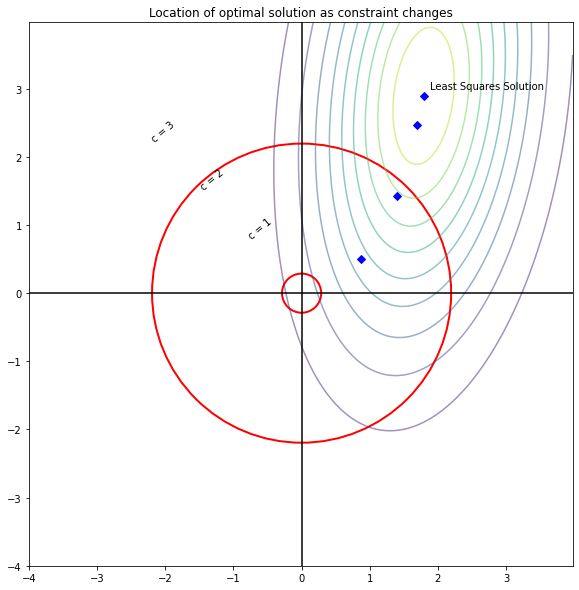

In [51]:
import matplotlib.cm as cm

delta = 0.025
x = np.arange(-4.0, 4.0, delta)
y = np.arange(-4.0, 4.0, delta)
X, Y = np.meshgrid(x, y)
Z = np.exp(-0.5*(X-1.5)**2 - 0.1*(Y-2)**2 + 0.1*X*Y)

fig, ax = plt.subplots(figsize=(10,10))

CS = ax.contour(X, Y, Z, levels=10, alpha=0.5)

circle1 = plt.Circle((0, 0), c1, color='red',fill=False, linewidth=2)
circle2 = plt.Circle((0, 0), c2, color='red',fill=False, linewidth=2)
circle3 = plt.Circle((0, 0), c3, color='red',fill=False, linewidth=2)

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)

plt.text(-0.1 - 3*(2**0.5)/2, 0.1 + 3*(2**0.5)/2,'c = 3', rotation=40)
plt.text(-0.1 - 2*(2**0.5)/2, 0.1 + 2*(2**0.5)/2,'c = 2', rotation=40)
plt.text(-0.1 - 1*(2**0.5)/2, 0.1 + 1*(2**0.5)/2,'c = 1', rotation=40)

plt.plot(34/19, 55/19, 'bD')
plt.text(34/19 + 0.1, 55/19 + 0.1, 'Least Squares Solution')
plt.plot(1.690, 2.474, 'bD')
plt.plot(1.396, 1.432, 'bD')
plt.plot(0.869, 0.495, 'bD')

plt.axhline(0, color='black')
plt.axvline(0, color='black')
ax.set_aspect('equal', adjustable='box')
ax.set_title('Location of optimal solution as constraint changes')

[[0.07384219]]
[[0.0736948]]
[[0.0723943]]
[[0.06153515]]


/Users/john/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


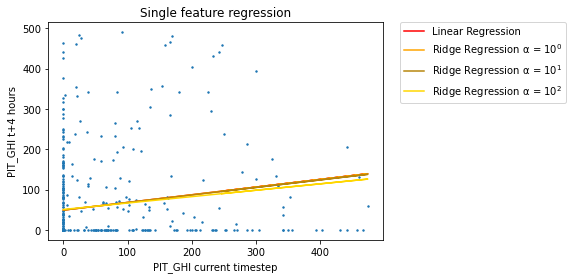

In [52]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Viualize model for SISO

X_single_input = X_current_only_train.to_numpy()[:500,6]
X_single_input_scaler = StandardScaler()
X_single_input_norm = X_single_input_scaler.fit_transform(X_single_input.reshape(-1,1))

y_norm = y_current_only_train_norm[:500]
y = y_current_only_train[:500]

model = LinearRegression()
model_alpha1 = Ridge(alpha=10**0)
model_alpha2 = Ridge(alpha=10**1)
model_alpha3 = Ridge(alpha=10**2)


model.fit(X_single_input_norm, y_norm)
prediction = model.predict(X_single_input_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
plt.plot(X_single_input, prediction, c='r', label='Linear Regression')
print(model.coef_)

model_alpha1.fit(X_single_input_norm, y_norm)
prediction = model_alpha1.predict(X_single_input_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
plt.plot(X_single_input, prediction, c='orange', label='Ridge Regression \u03B1 = $10^{0}$')
print(model_alpha1.coef_)

model_alpha2.fit(X_single_input_norm, y_norm)
prediction = model_alpha2.predict(X_single_input_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
plt.plot(X_single_input, prediction, c='darkgoldenrod', label='Ridge Regression \u03B1 = $10^{1}$')
print(model_alpha2.coef_)

model_alpha3.fit(X_single_input_norm, y_norm)
prediction = model_alpha3.predict(X_single_input_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
plt.plot(X_single_input, prediction, c='gold', label='Ridge Regression \u03B1 = $10^{2}$')
print(model_alpha3.coef_)


plt.subplot(111)
plt.scatter(X_single_input, y, s=2)
plt.xlabel('PIT_GHI current timestep')
plt.ylabel('PIT_GHI t+4 hours')
plt.title('Single feature regression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [53]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
'''
# Viualize model for SISO

X_double_input = X_current_only_train.to_numpy()[:,[52,174]]
X_double_input_scaler = MinMaxScaler()
X_double_input_norm = X_double_input_scaler.fit_transform(X_double_input)

model = LinearRegression()
model_alpha1 = Ridge(alpha=10**3)
model_alpha2 = Ridge(alpha=10**4)
model_alpha3 = Ridge(alpha=10**5)

model.fit(X_double_input_norm, y_current_only_train_norm)
prediction = model.predict(X_double_input_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
#plt.plot(X_double_input, prediction, c='r', label='Linear Regression')

#model_alpha1.fit(X_double_input_norm, y_current_only_train_norm)
#prediction = model_alpha1.predict(X_double_input_norm)
#prediction = y_current_only_train_scaler.inverse_transform(prediction)
#plt.plot(X_double_input, prediction, c='orange', label='Ridge Regression \u03B1 = $10^{3}$')

#model_alpha2.fit(X_double_input_norm, y_current_only_train_norm)
#prediction = model_alpha2.predict(X_double_input_norm)
#prediction = y_current_only_train_scaler.inverse_transform(prediction)
#plt.plot(X_double_input, prediction, c='darkgoldenrod', label='Ridge Regression \u03B1 = $10^{4}$')

#model_alpha3.fit(X_double_input_norm, y_current_only_train_norm)
#prediction = model_alpha3.predict(X_double_input_norm)
#prediction = y_current_only_train_scaler.inverse_transform(prediction)
#plt.plot(X_double_input, prediction, c='gold', label='Ridge Regression \u03B1 = $10^{5}$')

normal = []

x0_min = min(X_double_input[:,0])
x0_max = max(X_double_input[:,0])
x1_min = min(X_double_input[:,1])
x1_max = max(X_double_input[:,1])

x0_step = (x0_max - x0_min)/50
x1_step = (x1_max - x1_min)/50


x0_surf = np.arange(x0_min, x0_max, x0_step)
x1_surf = np.arange(x1_min, x1_max, x1_step)


x0_surf, x1_surf = np.meshgrid(x0_surf, x1_surf)

y = model.coef_[:,0]*x0_surf + model.coef_[:,1]*x1_surf + model.intercept_

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_double_input[:,0], X_double_input[:,1], y_current_only_train, s=0.1, alpha=0.5)
surf = ax.plot_surface(x0_surf, x1_surf, y, color='red', alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(20, 130)
plt.show()
'''

"\n# Viualize model for SISO\n\nX_double_input = X_current_only_train.to_numpy()[:,[52,174]]\nX_double_input_scaler = MinMaxScaler()\nX_double_input_norm = X_double_input_scaler.fit_transform(X_double_input)\n\nmodel = LinearRegression()\nmodel_alpha1 = Ridge(alpha=10**3)\nmodel_alpha2 = Ridge(alpha=10**4)\nmodel_alpha3 = Ridge(alpha=10**5)\n\nmodel.fit(X_double_input_norm, y_current_only_train_norm)\nprediction = model.predict(X_double_input_norm)\nprediction = y_current_only_train_scaler.inverse_transform(prediction)\n#plt.plot(X_double_input, prediction, c='r', label='Linear Regression')\n\n#model_alpha1.fit(X_double_input_norm, y_current_only_train_norm)\n#prediction = model_alpha1.predict(X_double_input_norm)\n#prediction = y_current_only_train_scaler.inverse_transform(prediction)\n#plt.plot(X_double_input, prediction, c='orange', label='Ridge Regression α = $10^{3}$')\n\n#model_alpha2.fit(X_double_input_norm, y_current_only_train_norm)\n#prediction = model_alpha2.predict(X_double

### Find best alpha for current_only data

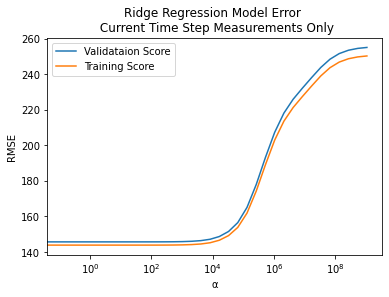

In [54]:
val_scores = []
train_scores = []
alpha = [0, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4,\
         2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13,\
         2**14, 2**15, 2**16, 2**17, 2**18, 2**19, 2**20, 2**21,\
         2**22, 2**23, 2**24, 2**25, 2**26, 2**27, 2**28, 2**29, 2**30]

w = np.empty((0, X_current_only_train.shape[1]))

for a in alpha:
    if a == 0:
        model = LinearRegression()
    else:
        model = Ridge(random_state = 15217, alpha=a)
      
    model.fit(X_current_only_train_norm, y_current_only_train_norm)
    
    val_prediction = model.predict(X_current_only_val_norm)
    val_prediction = y_current_only_train_scaler.inverse_transform(val_prediction)
    val_actual = y_current_only_val
    val_scores.append(mean_squared_error(val_actual, val_prediction, squared=False))
    
    train_prediction = model.predict(X_current_only_train_norm)
    train_prediction = y_current_only_train_scaler.inverse_transform(train_prediction)
    train_actual = y_current_only_train
    train_scores.append(mean_squared_error(train_actual, train_prediction, squared=False))
    
    w = np.append(w, model.coef_, axis=0)   

plt.plot(alpha, val_scores, label='Validataion Score')
plt.plot(alpha, train_scores, label='Training Score')

plt.legend()
plt.title('Ridge Regression Model Error \n Current Time Step Measurements Only')
plt.xlabel('\u03B1')
plt.ylabel('RMSE')
plt.xscale('log')
plt.show()



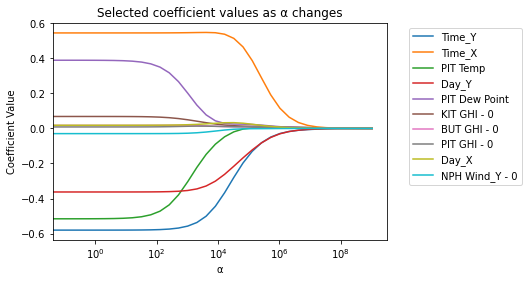

In [55]:
w_1 = w[:,1]
w_0 = w[:,0]
w_15 = w[:,15]
w_3 = w[:,3]
w_10 = w[:,10]

w_65 = w[:,65]
w_20 = w[:,20]
w_6 = w[:,6]
w_2 = w[:,2]
w_93 = w[:,93]

plt.plot(alpha, w_1, label='Time_Y')
plt.plot(alpha, w_0, label='Time_X')
plt.plot(alpha, w_15, label='PIT Temp')
plt.plot(alpha, w_3, label='Day_Y')
plt.plot(alpha, w_10, label='PIT Dew Point')

plt.plot(alpha, w_65, label='KIT GHI - 0')
plt.plot(alpha, w_20, label='BUT GHI - 0')
plt.plot(alpha, w_6, label='PIT GHI - 0')
plt.plot(alpha, w_2, label='Day_X')
plt.plot(alpha, w_93, label='NPH Wind_Y - 0')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('log')
plt.xlabel('\u03B1')
plt.ylabel('Coefficient Value')
plt.title('Selected coefficient values as \u03B1 changes')
plt.show()

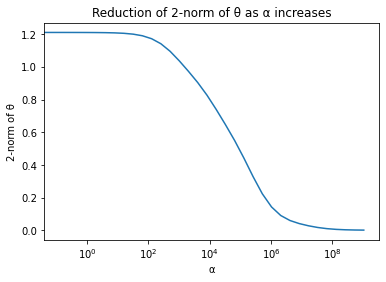

In [190]:
plt.plot(alpha, np.linalg.norm(w, ord=2, axis=1))
plt.xscale('log')
plt.xlabel('\u03B1')
plt.ylabel('2-norm of \u03B8')
plt.title('Reduction of 2-norm of \u03B8 as \u03B1 increases')
plt.show()

In [191]:
np.linalg.norm(w, ord=2, axis=1)

array([1.21051308e+00, 1.21047082e+00, 1.21042856e+00, 1.21034408e+00,
       1.21017525e+00, 1.20983808e+00, 1.20916572e+00, 1.20782887e+00,
       1.20518625e+00, 1.20002202e+00, 1.19015261e+00, 1.17207023e+00,
       1.14135538e+00, 1.09521295e+00, 1.03642089e+00, 9.71879094e-01,
       9.03531665e-01, 8.26542501e-01, 7.39229823e-01, 6.46377686e-01,
       5.48847972e-01, 4.41639220e-01, 3.27796030e-01, 2.22952348e-01,
       1.42363338e-01, 8.99998611e-02, 5.94405204e-02, 4.07565425e-02,
       2.72464786e-02, 1.69294490e-02, 9.72744739e-03, 5.26920224e-03,
       2.75098766e-03, 1.40679195e-03, 7.11519744e-04])

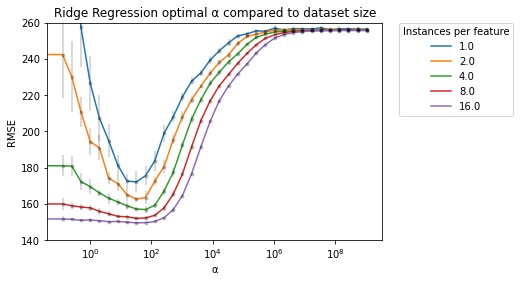

In [370]:
m = X_current_only_train.shape[1]

for i in range(1,6):
    
    val_scores_mean = []
    val_scores_std = []
    
    alpha = [0, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4,\
         2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13,\
         2**14, 2**15, 2**16, 2**17, 2**18, 2**19, 2**20, 2**21,\
         2**22, 2**23, 2**24, 2**25, 2**26, 2**27, 2**28, 2**29, 2**30]
    
    for a in alpha:
        
        val_scores = []
        
        for j in range(10):
            
            # get a sample of training X and y
            train_sample_X = X_current_only_train.sample(m*(2**(i-1)))
            sample_size = train_sample_X.shape[0]/m
            ind = train_sample_X.index

            train_sample_y = y_current_only_train.iloc[ind]

            # scaler for sample X data
            train_sample_X_scaler = StandardScaler()
            train_sample_y_scaler = StandardScaler()

            # fit and transform sample X
            train_sample_X_norm = train_sample_X_scaler.fit_transform(train_sample_X)
            train_sample_y_norm = train_sample_y_scaler.fit_transform(train_sample_y)

            # transform val set
            val_sample_X_norm = train_sample_X_scaler.transform(X_current_only_val)

            if a == 0:
                model = LinearRegression()
            else:
                model = Ridge(alpha=a)

            model.fit(train_sample_X_norm, train_sample_y_norm)

            val_prediction = model.predict(val_sample_X_norm)
            val_prediction = train_sample_y_scaler.inverse_transform(val_prediction)
            val_actual = y_current_only_val
            val_scores.append(mean_squared_error(val_actual, val_prediction, squared=False))
            
        val_scores_mean.append(np.mean(val_scores))
        val_scores_std.append(np.std(val_scores))
        
    plt.plot(alpha, val_scores_mean, label=f'{sample_size}'.format(sample_size=sample_size))
    plt.errorbar(alpha, val_scores_mean, yerr=val_scores_std, fmt='.k', alpha=0.2)

plt.legend(title='Instances per feature', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Ridge Regression optimal \u03B1 compared to dataset size')

plt.xlabel('\u03B1')
plt.ylabel('RMSE')
plt.xscale('log')
plt.ylim([140,260])
plt.show()
    

#### Check highest and lowest magnitude coefficients for a low-alpha and high-alpha model

In [26]:
model = LinearRegression()
model.fit(X_current_only_train_norm, y_current_only_train_norm)

prediction = model.predict(X_current_only_val_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
actual = y_current_only_val.to_numpy()

current_only_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('RMSE with alpha=0:')
print(current_only_linreg_rmse)

vals = abs(model.coef_[0])
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_only_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[0][largest_idx])
print(largest_idx)
print(largest_list)


smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_only_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(model.coef_[0][smallest_idx])
print(smallest_idx)
print(smallest_list)


coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

RMSE with alpha=0:
145.67258666402145

n largest abs:
[-0.58040106  0.54509427 -0.51583911  0.38928435 -0.36273838]
[1, 0, 15, 10, 3]
['Time_Y', 'Time_X', 'PIT_Temperature-0', 'PIT_Dew Point-0', 'Day_Y']

n smallest abs:
[-0.00015639  0.00021747  0.00026511 -0.00032881 -0.00038803]
[123, 74, 118, 21, 87]
['WHE_Wind_X-0', 'MGT_Surface Albedo-0', 'WAS_Global Horizontal UV Irradiance (280-400nm)-0', 'BUT_Surface Albedo-0', 'NCS_Global Horizontal UV Irradiance (280-400nm)-0']

Magnitude of the coef vector:
1.210513082957891


In [27]:
X = X_current_only_train_norm
X_T = np.transpose(X)
A = np.matmul(X_T,X)
w, v = np.linalg.eig(A)


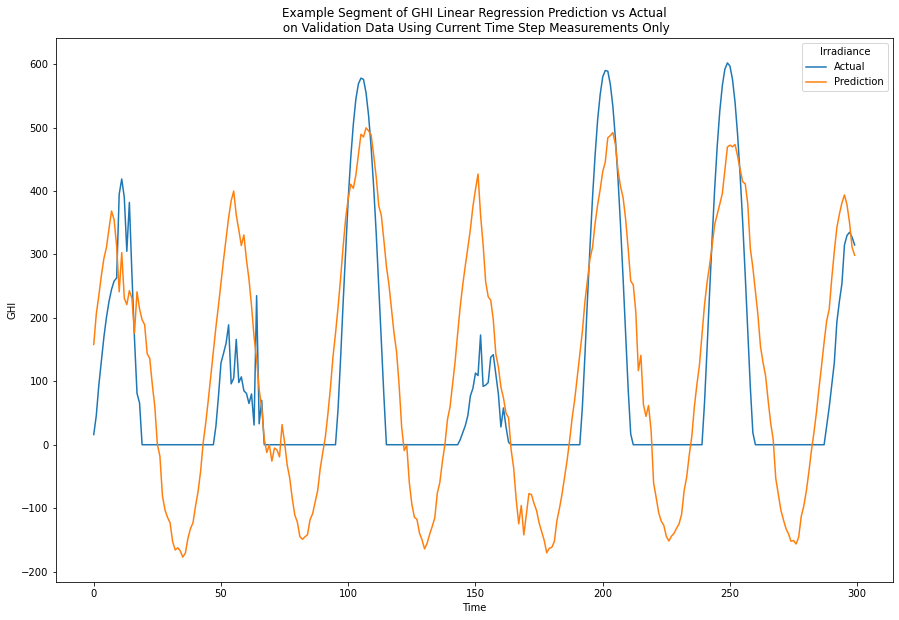

In [28]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Linear Regression Prediction vs Actual\n on Validation Data Using Current Time Step Measurements Only')
plt.xlabel('Time')
plt.show()

In [29]:
model = Ridge(random_state=15217, alpha=2**15)
model.fit(X_current_only_train_norm, y_current_only_train_norm)

prediction = model.predict(X_current_only_val_norm)
prediction = y_current_only_train_scaler.inverse_transform(prediction)
actual = y_current_only_val.to_numpy()

current_only_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('RMSE with alpha=2^15:')
print(current_only_linreg_rmse)

vals = abs(model.coef_[0])
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_only_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[0][largest_idx])
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_only_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(model.coef_[0][smallest_idx])
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

RMSE with alpha=2^15:
151.521703796701

n largest abs:
[ 0.51403304 -0.279715   -0.21582655 -0.06247249  0.04518428]
[0, 1, 3, 8, 102]
['Time_X', 'Time_Y', 'Day_Y', 'PIT_Clearsky DNI-0', 'PKS_Relative Humidity-0']

n smallest abs:
[ 7.16740159e-05  8.50508714e-05 -1.53075463e-04  2.29055062e-04
 -2.70265444e-04]
[127, 52, 43, 108, 49]
['YGT_DHI-0', 'GRE_Pressure-0', 'ELV_Relative Humidity-0', 'STU_Surface Albedo-0', 'GRE_Surface Albedo-0']

Magnitude of the coef vector:
0.6463776855136052


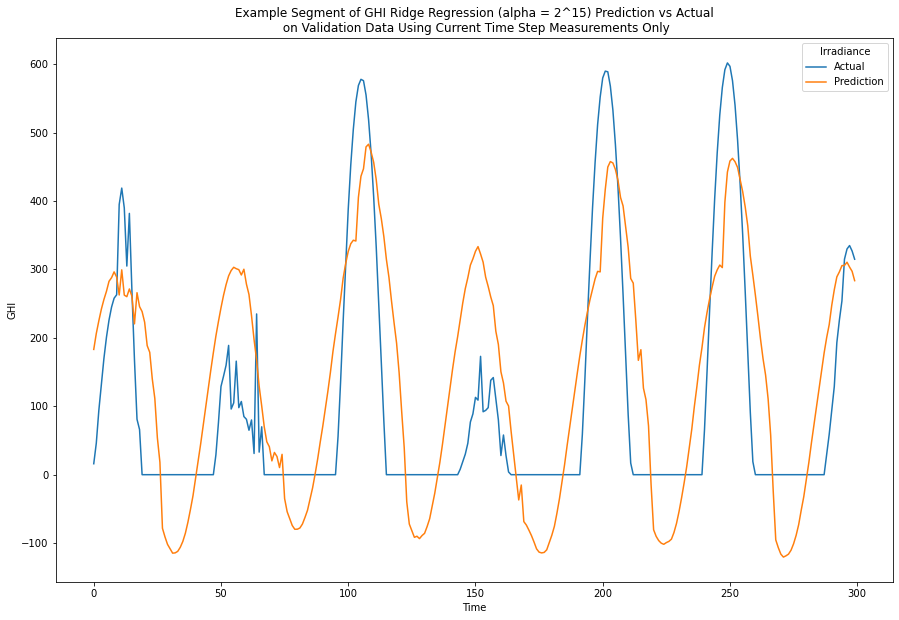

In [30]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Ridge Regression (alpha = 2^15) Prediction vs Actual\n on Validation Data Using Current Time Step Measurements Only')
plt.xlabel('Time')
plt.show()

In [31]:
# Create and fit ridge regression model. Use combined training and validation dataset.
# DONT EVALUATE ON TEST SET!!! 
# THIS IS ONLY FOR EVALUATION OF COEFFICIENTS
model = Ridge(random_state=15217, alpha=2**15)
model.fit(X_current_only_train_val_norm, y_current_only_train_val_norm)

vals = abs(model.coef_[0])
print('\nintercept:')
print(model.intercept_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_only_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[0][largest_idx])
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_only_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(model.coef_[0][smallest_idx])
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)


intercept:
[2.23215762e-16]

n largest abs:
[ 0.52565695 -0.30916461 -0.23037151 -0.07505532 -0.05255637]
[0, 1, 3, 8, 30]
['Time_X', 'Time_Y', 'Day_Y', 'PIT_Clearsky DNI-0', 'CBG_Clearsky DHI-0']

n smallest abs:
[ 6.73336454e-05 -1.88990929e-04  2.73055694e-04 -2.94968805e-04
 -5.10892627e-04]
[109, 131, 87, 117, 23]
['STU_Pressure-0', 'YGT_Pressure-0', 'NCS_Global Horizontal UV Irradiance (280-400nm)-0', 'WAS_Pressure-0', 'BUT_Wind_Y-0']

Magnitude of the coef vector:
0.6769461675188012


It appears that the linear regression model with no regularization performs the best. Therefore, the combined training and validation sets will used to fit the model. Then the model will be finally evaluated on the testing set.

In [32]:
# Create and fit linear regression model. Use combined training and validation dataset.
model = LinearRegression()
model.fit(X_current_only_train_val_norm, y_current_only_train_val_norm)

# evaluate model on test set
prediction = model.predict(X_current_only_test_norm)
prediction = y_current_only_train_val_scaler.inverse_transform(prediction)
actual = y_current_only_test.to_numpy()

best_current_only_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('best_current_only_linreg_rmse:')
print(best_current_only_linreg_rmse)

vals = abs(model.coef_[0])
print('\nintercept:')
print(model.intercept_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_only_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[0][largest_idx])
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_only_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(model.coef_[0][smallest_idx])
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

best_current_only_linreg_rmse:
141.439803357895

intercept:
[3.77800751e-17]

n largest abs:
[-0.58265786  0.54659963 -0.52311825  0.39987027 -0.36262898]
[1, 0, 15, 10, 3]
['Time_Y', 'Time_X', 'PIT_Temperature-0', 'PIT_Dew Point-0', 'Day_Y']

n smallest abs:
[ 7.50393449e-05 -1.42321909e-04 -2.49019532e-04 -8.66252434e-04
 -1.23344525e-03]
[100, 76, 118, 74, 120]
['PKS_Wind_X-0', 'MGT_Wind_Y-0', 'WAS_Global Horizontal UV Irradiance (280-400nm)-0', 'MGT_Surface Albedo-0', 'WHE_DNI-0']

Magnitude of the coef vector:
1.2163679609066707


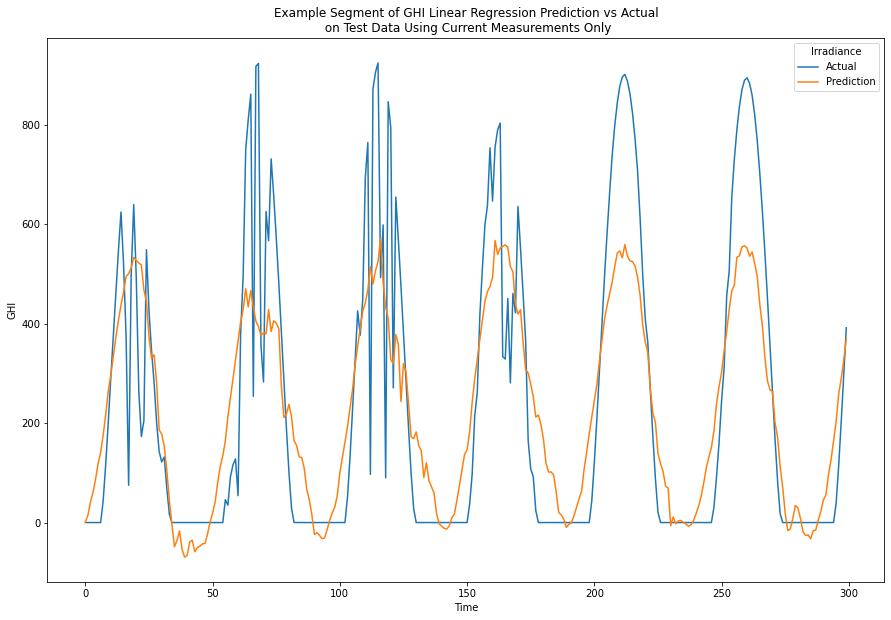

In [33]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Linear Regression Prediction vs Actual\n on Test Data Using Current Measurements Only')
plt.xlabel('Time')
plt.show()

### Find best alpha for current_and_previous data

The same previous steps will be repeated but incorporating previous measurements rather than just current measurements.

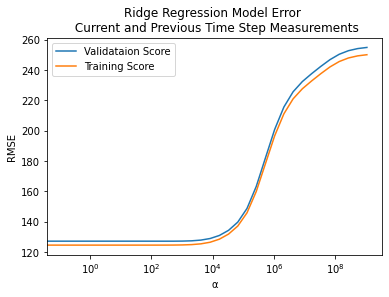

In [208]:
val_scores = []
train_scores = []
alpha = [0, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4,\
         2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13,\
         2**14, 2**15, 2**16, 2**17, 2**18, 2**19, 2**20, 2**21,\
         2**22, 2**23, 2**24, 2**25, 2**26, 2**27, 2**28, 2**29, 2**30]

w = np.empty((0, X_current_and_previous_train.shape[1]))

for a in alpha:
    if a == 0:
        model = LinearRegression()
    else:
        model = Ridge(random_state = 15217, alpha=a)
      
    model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm)
    
    val_prediction = model.predict(X_current_and_previous_val_norm)
    val_prediction = y_current_and_previous_train_scaler.inverse_transform(val_prediction)
    val_actual = y_current_and_previous_val
    val_scores.append(mean_squared_error(val_actual, val_prediction, squared=False))
    
    train_prediction = model.predict(X_current_and_previous_train_norm)
    train_prediction = y_current_and_previous_train_scaler.inverse_transform(train_prediction)
    train_actual = y_current_and_previous_train
    train_scores.append(mean_squared_error(train_actual, train_prediction, squared=False))
    
    w = np.append(w, model.coef_, axis=0)   

plt.plot(alpha, val_scores, label='Validataion Score')
plt.plot(alpha, train_scores, label='Training Score')

plt.legend()
plt.title('Ridge Regression Model Error \n Current and Previous Time Step Measurements')
plt.xlabel('\u03B1')
plt.ylabel('RMSE')
plt.xscale('log')
plt.show()


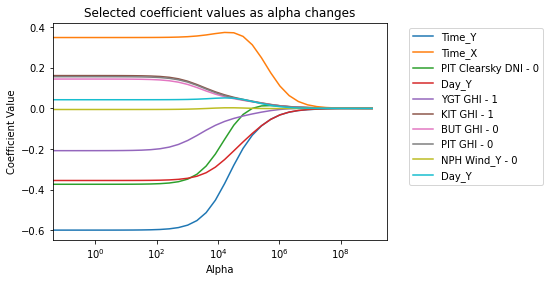

In [35]:
w_1 = w[:,1]
w_0 = w[:,0]
w_11 = w[:,11]
w_3 = w[:,3]
w_194 = w[:,194]

w_92 = w[:,92]
w_26 = w[:,26]
w_8 = w[:,8]
w_134 = w[:,134]
w_2 = w[:,2]


plt.plot(alpha, w_1, label='Time_Y')
plt.plot(alpha, w_0, label='Time_X')
plt.plot(alpha, w_11, label='PIT Clearsky DNI - 0')
plt.plot(alpha, w_3, label='Day_Y')
plt.plot(alpha, w_194, label='YGT GHI - 1')

plt.plot(alpha, w_92, label='KIT GHI - 1')
plt.plot(alpha, w_26, label='BUT GHI - 0')
plt.plot(alpha, w_8, label='PIT GHI - 0')
plt.plot(alpha, w_134, label='NPH Wind_Y - 0')
plt.plot(alpha, w_2, label='Day_Y')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.title('Selected coefficient values as alpha changes')
plt.show()

#### Check highest and lowest magnitude coefficients for a low-alpha and high-alpha model

In [36]:
model = LinearRegression()
model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm)

prediction = model.predict(X_current_and_previous_val_norm)
prediction = y_current_and_previous_train_scaler.inverse_transform(prediction)
actual = y_current_and_previous_val.to_numpy()

current_and_previous_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('RMSE with alpha=0:')
print(current_and_previous_linreg_rmse)

vals = abs(model.coef_[0])
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[0][largest_idx])
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(model.coef_[0][smallest_idx])
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

RMSE with alpha=0:
127.25374543985134

n largest abs:
[-0.59952218 -0.37371264 -0.35505233  0.34914528 -0.20817822]
[1, 11, 3, 0, 194]
['Time_Y', 'PIT_Clearsky DNI-0', 'Day_Y', 'Time_X', 'YGT_GHI-1']

n smallest abs:
[ 2.00345873e-06  2.89932421e-05  7.99175256e-05 -3.73248405e-04
  4.79092596e-04]
[44, 187, 159, 147, 133]
['CBG_Wind_Y-0', 'WHE_Global Horizontal UV Irradiance (280-400nm)-0', 'STU_Surface Albedo-0', 'PKS_Wind_Y-0', 'NPH_Wind_X-0']

Magnitude of the coef vector:
1.2267047817017542


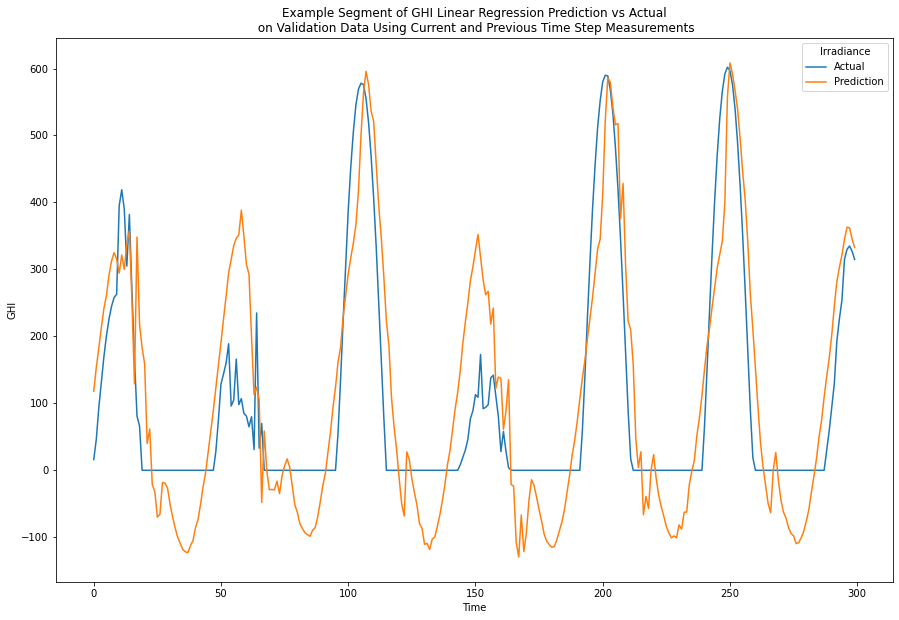

In [37]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Linear Regression Prediction vs Actual\n on Validation Data Using Current and Previous Time Step Measurements')
plt.xlabel('Time')
plt.show()

In [38]:
model = Ridge(random_state=15217, alpha=2**15)
model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm)

prediction = model.predict(X_current_and_previous_val_norm)
prediction = y_current_and_previous_train_scaler.inverse_transform(prediction)
actual = y_current_and_previous_val.to_numpy()

current_and_previous_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('RMSE with alpha=2^15:')
print(current_and_previous_linreg_rmse)

vals = abs(model.coef_[0])
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[0][largest_idx])
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(model.coef_[0][smallest_idx])
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

RMSE with alpha=2^15:
134.38449223249933

n largest abs:
[ 0.37257282 -0.27986245 -0.20891063 -0.08273542 -0.06137094]
[0, 1, 3, 11, 152]
['Time_X', 'Time_Y', 'Day_Y', 'PIT_Clearsky DNI-0', 'PKS_Global Horizontal UV Irradiance (280-400nm)-1']

n smallest abs:
[ 2.73135185e-05  3.25235070e-05  1.07318494e-04 -1.83057748e-04
  1.86665441e-04]
[160, 96, 122, 171, 172]
['STU_Pressure-0', 'KIT_Wind_Y-0', 'NCS_Wind_Y-0', 'WAS_Wind_Y-0', 'WAS_Wind_Y-1']

Magnitude of the coef vector:
0.6640053363832614


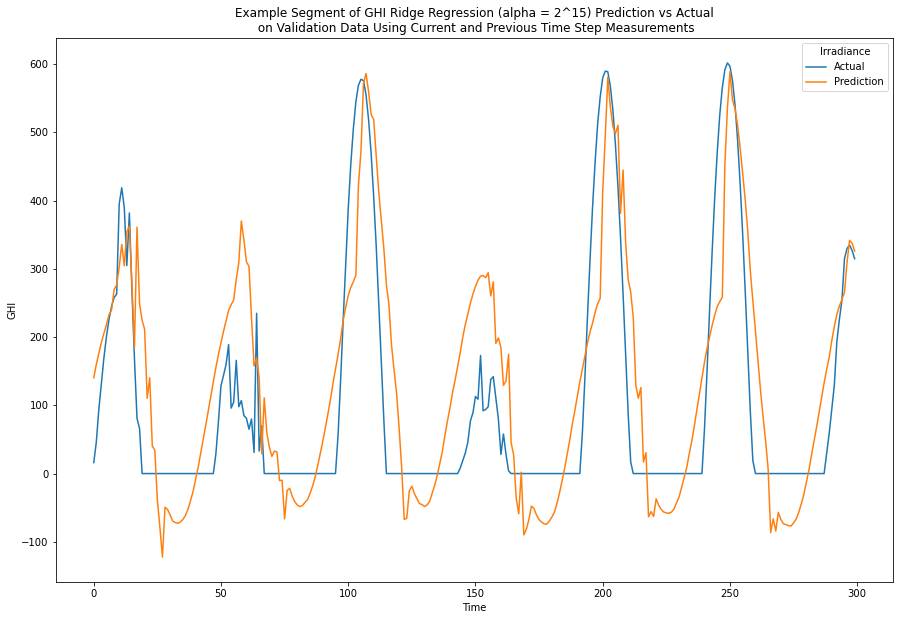

In [39]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Ridge Regression (alpha = 2^15) Prediction vs Actual\n on Validation Data Using Current and Previous Time Step Measurements')
plt.xlabel('Time')
plt.show()

In [40]:
# Create and fit ridge regression model. Use combined training and validation dataset.
# DONT EVALUATE ON TEST SET!!! 
# THIS IS ONLY FOR EVALUATION OF COEFFICIENTS
model = Ridge(random_state=15217, alpha=2**15)
model.fit(X_current_and_previous_train_val_norm, y_current_and_previous_train_val_norm)

vals = abs(model.coef_[0])
print('\nintercept:')
print(model.intercept_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[0][largest_idx])
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(model.coef_[0][smallest_idx])
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)


intercept:
[7.88019575e-17]

n largest abs:
[ 0.37556966 -0.3099552  -0.22264195 -0.10000759 -0.06306142]
[0, 1, 3, 11, 152]
['Time_X', 'Time_Y', 'Day_Y', 'PIT_Clearsky DNI-0', 'PKS_Global Horizontal UV Irradiance (280-400nm)-1']

n smallest abs:
[3.29273529e-05 1.00046419e-04 1.24030806e-04 1.81025384e-04
 2.01151243e-04]
[171, 170, 117, 172, 109]
['WAS_Wind_Y-0', 'WAS_Wind_X-0', 'NCS_DNI-1', 'WAS_Wind_Y-1', 'MGT_Wind_Y-1']

Magnitude of the coef vector:
0.6953386030640973


In [41]:
# Create and fit linear regression model. Use combined training and validation dataset.
model = LinearRegression()
model.fit(X_current_and_previous_train_val_norm, y_current_and_previous_train_val_norm)

# evaluate model on test set
prediction = model.predict(X_current_and_previous_test_norm)
prediction = y_current_and_previous_train_val_scaler.inverse_transform(prediction)
actual = y_current_and_previous_test.to_numpy()

best_current_and_previous_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('best_current_and_previous_linreg_rmse:')
print(best_current_and_previous_linreg_rmse)

vals = abs(model.coef_[0])
print('\nintercept:')
print(model.intercept_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[0][largest_idx])
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(model.coef_[0][smallest_idx])
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

best_current_and_previous_linreg_rmse:
121.47268555937057

intercept:
[1.52033625e-16]

n largest abs:
[-0.60184331 -0.36707421 -0.35545605  0.35022241 -0.19894059]
[1, 11, 3, 0, 194]
['Time_Y', 'PIT_Clearsky DNI-0', 'Day_Y', 'Time_X', 'YGT_GHI-1']

n smallest abs:
[ 0.00013619  0.00017615  0.00040273 -0.0004735  -0.00054513]
[76, 147, 106, 151, 161]
['JON_DHI-1', 'PKS_Wind_Y-0', 'MGT_Surface Albedo-0', 'PKS_Global Horizontal UV Irradiance (280-400nm)-0', 'STU_Global Horizontal UV Irradiance (280-400nm)-0']

Magnitude of the coef vector:
1.2177837133921767


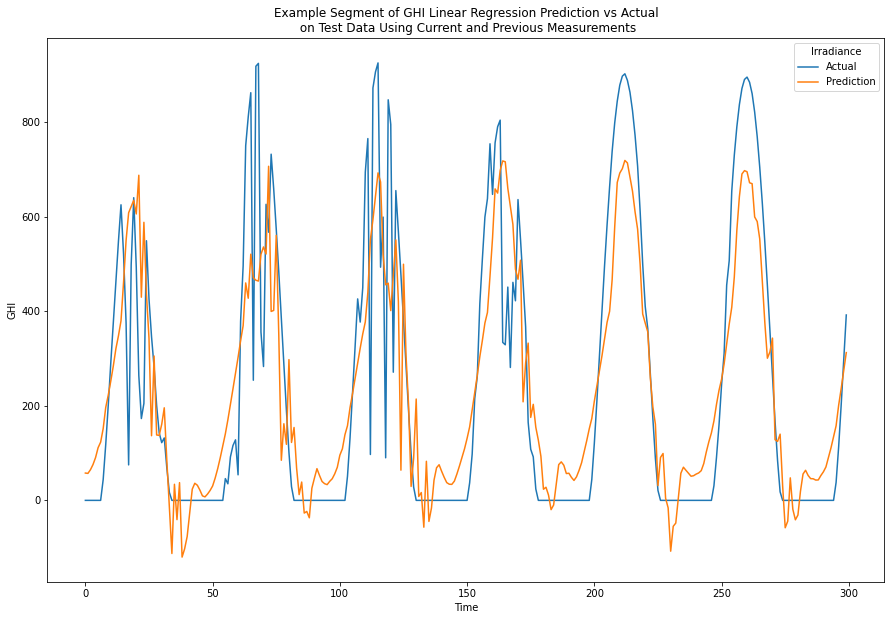

In [42]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Linear Regression Prediction vs Actual\n on Test Data Using Current and Previous Measurements')
plt.xlabel('Time')
plt.show()

### Find best alpha for current_and_previous_3 data

The same previous steps will be repeated but incorporating previous 3 measurements rather than just current measurements.

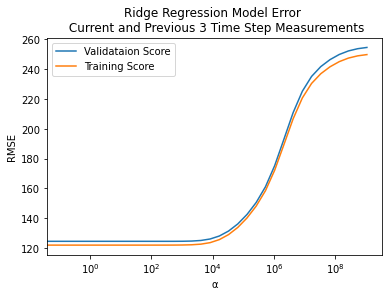

In [207]:
val_scores = []
train_scores = []
alpha = [0, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4,\
         2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13,\
         2**14, 2**15, 2**16, 2**17, 2**18, 2**19, 2**20, 2**21,\
         2**22, 2**23, 2**24, 2**25, 2**26, 2**27, 2**28, 2**29, 2**30]

w = np.empty((0, X_current_and_previous_3_train.shape[1]))

for a in alpha:
    if a == 0:
        model = LinearRegression()
    else:
        model = Ridge(random_state = 15217, alpha=a)
      
    model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm)
    
    val_prediction = model.predict(X_current_and_previous_3_val_norm)
    val_prediction = y_current_and_previous_3_train_scaler.inverse_transform(val_prediction)
    val_actual = y_current_and_previous_3_val
    val_scores.append(mean_squared_error(val_actual, val_prediction, squared=False))
    
    train_prediction = model.predict(X_current_and_previous_3_train_norm)
    train_prediction = y_current_and_previous_3_train_scaler.inverse_transform(train_prediction)
    train_actual = y_current_and_previous_3_train
    train_scores.append(mean_squared_error(train_actual, train_prediction, squared=False))
    
    w = np.append(w, model.coef_, axis=0)   

plt.plot(alpha, val_scores, label='Validataion Score')
plt.plot(alpha, train_scores, label='Training Score')

plt.legend()
plt.title('Ridge Regression Model Error \n Current and Previous 3 Time Step Measurements')
plt.xlabel('\u03B1')
plt.ylabel('RMSE')
plt.xscale('log')
plt.show()


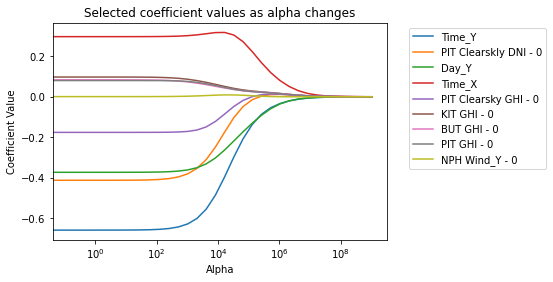

In [44]:
w_1 = w[:,1]
w_17 = w[:,17]
w_3 = w[:,3]
w_0 = w[:,0]
w_18 = w[:,18]

w_146 = w[:,146]
w_38 = w[:,38]
w_12 = w[:,12]
w_216 = w[:,216]


plt.plot(alpha, w_1, label='Time_Y')
plt.plot(alpha, w_17, label='PIT Clearskly DNI - 0')
plt.plot(alpha, w_3, label='Day_Y')
plt.plot(alpha, w_0, label='Time_X')
plt.plot(alpha, w_18, label='PIT Clearsky GHI - 0')

plt.plot(alpha, w_146, label='KIT GHI - 0')
plt.plot(alpha, w_38, label='BUT GHI - 0')
plt.plot(alpha, w_12, label='PIT GHI - 0')
plt.plot(alpha, w_216, label='NPH Wind_Y - 0')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.title('Selected coefficient values as alpha changes')
plt.show()

#### Check highest and lowest magnitude coefficients for a low-alpha and high-alpha model


In [45]:
model = LinearRegression()
model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm)

prediction = model.predict(X_current_and_previous_3_val_norm)
prediction = y_current_and_previous_3_train_scaler.inverse_transform(prediction)
actual = y_current_and_previous_3_val.to_numpy()

current_and_previous_3_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('RMSE with alpha=0:')
print(current_and_previous_3_linreg_rmse)

vals = abs(model.coef_[0])
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_3_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[0][largest_idx])
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_3_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(model.coef_[0][smallest_idx])
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

RMSE with alpha=0:
124.53798092787855

n largest abs:
[-0.65988045 -0.41323132 -0.37379225  0.29747774 -0.17623487]
[1, 17, 3, 0, 18]
['Time_Y', 'PIT_Clearsky DNI-0', 'Day_Y', 'Time_X', 'PIT_Clearsky GHI-0']

n smallest abs:
[5.86939235e-05 8.56615523e-05 1.66875155e-04 1.89128425e-04
 2.20811774e-04]
[261, 255, 196, 247, 7]
['STU_Surface Albedo-0', 'STU_DNI-2', 'NCS_Wind_Y-0', 'PKS_Global Horizontal UV Irradiance (280-400nm)-2', 'PIT_DHI-3']

Magnitude of the coef vector:
1.0921964446638015


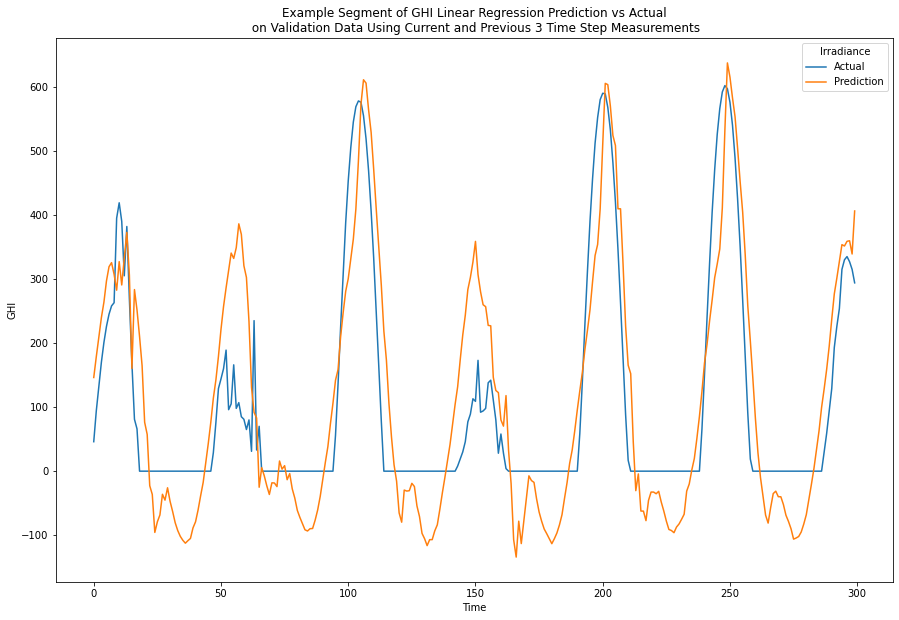

In [46]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Linear Regression Prediction vs Actual\n on Validation Data Using Current and Previous 3 Time Step Measurements')
plt.xlabel('Time')
plt.show()

In [47]:
model = Ridge(random_state=15217, alpha=2**15)
model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm)

prediction = model.predict(X_current_and_previous_3_val_norm)
prediction = y_current_and_previous_3_train_scaler.inverse_transform(prediction)
actual = y_current_and_previous_3_val.to_numpy()

current_and_previous_3_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('RMSE with alpha=2^15:')
print(current_and_previous_3_linreg_rmse)

vals = abs(model.coef_[0])
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_3_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[0][largest_idx])
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_3_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(model.coef_[0][smallest_idx])
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

RMSE with alpha=2^15:
131.42571352271995

n largest abs:
[ 0.30545399 -0.29854788 -0.21890129 -0.10344874  0.06124909]
[0, 1, 3, 17, 2]
['Time_X', 'Time_Y', 'Day_Y', 'PIT_Clearsky DNI-0', 'Day_X']

n smallest abs:
[-8.89665645e-05 -1.31288024e-04  1.57887527e-04 -1.74636864e-04
 -2.38682975e-04]
[282, 283, 7, 281, 109]
['WAS_Wind_Y-1', 'WAS_Wind_Y-2', 'PIT_DHI-3', 'WAS_Wind_Y-0', 'GRE_Surface Albedo-0']

Magnitude of the coef vector:
0.5653390109401472


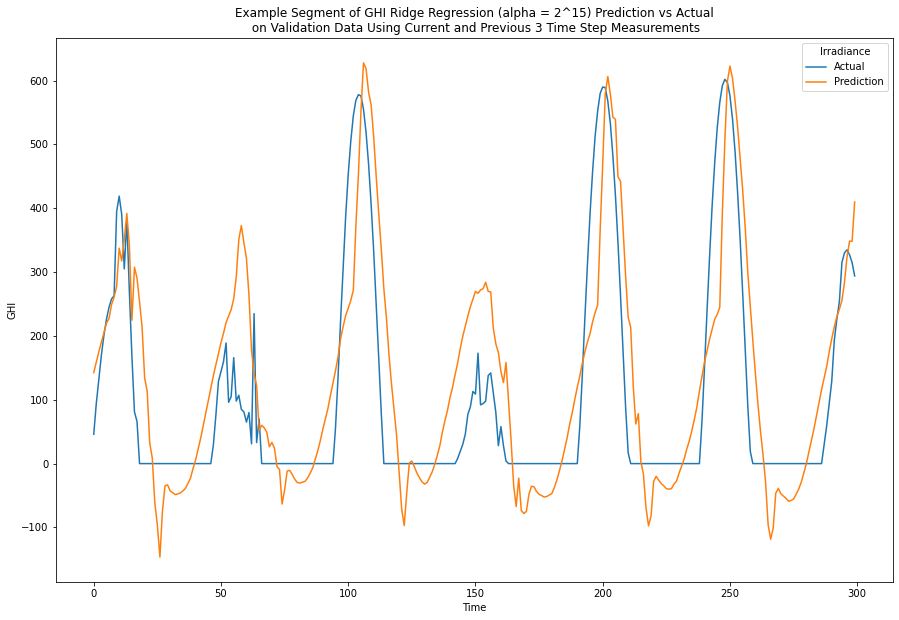

In [48]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Ridge Regression (alpha = 2^15) Prediction vs Actual\n on Validation Data Using Current and Previous 3 Time Step Measurements')
plt.xlabel('Time')
plt.show()

In [49]:
# Create and fit ridge regression model. Use combined training and validation dataset.
# DONT EVALUATE ON TEST SET!!! 
# THIS IS ONLY FOR EVALUATION OF COEFFICIENTS
model = Ridge(random_state=15217, alpha=2**15)
model.fit(X_current_and_previous_3_train_val_norm, y_current_and_previous_3_train_val_norm)

vals = abs(model.coef_[0])
print('\nintercept:')
print(model.intercept_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_3_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[0][largest_idx])
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_3_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(model.coef_[0][smallest_idx])
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)


intercept:
[-3.18966732e-17]

n largest abs:
[-0.33093903  0.31173262 -0.23319573 -0.12112629  0.06151166]
[1, 0, 3, 17, 2]
['Time_Y', 'Time_X', 'Day_Y', 'PIT_Clearsky DNI-0', 'Day_X']

n smallest abs:
[-3.39643889e-07  1.09479222e-04  1.48514170e-04  1.56942683e-04
  1.90481001e-04]
[29, 280, 43, 281, 282]
['PIT_Global Horizontal UV Irradiance (280-400nm)-3', 'WAS_Wind_X-0', 'BUT_Wind_X-0', 'WAS_Wind_Y-0', 'WAS_Wind_Y-1']

Magnitude of the coef vector:
0.6001447357235484


In [50]:
# Create and fit linear regression model. Use combined training and validation dataset.
model = LinearRegression()
model.fit(X_current_and_previous_3_train_val_norm, y_current_and_previous_3_train_val_norm)

# evaluate model on test set
prediction = model.predict(X_current_and_previous_3_test_norm)
prediction = y_current_and_previous_3_train_val_scaler.inverse_transform(prediction)
actual = y_current_and_previous_3_test.to_numpy()

best_current_and_previous_3_linreg_rmse = mean_squared_error(actual, prediction, squared=False)
print('best_current_and_previous_3_linreg_rmse:')
print(best_current_and_previous_3_linreg_rmse)

vals = abs(model.coef_[0])
print('\nintercept:')
print(model.intercept_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_3_train.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[0][largest_idx])
print(largest_idx)
print(largest_list)

smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_3_train.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nn smallest abs:')
print(model.coef_[0][smallest_idx])
print(smallest_idx)
print(smallest_list)

coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)

best_current_and_previous_3_linreg_rmse:
119.70946189183474

intercept:
[-2.74137368e-16]

n largest abs:
[-0.66284324 -0.40562843 -0.37471703  0.29738394 -0.18607234]
[1, 17, 3, 0, 18]
['Time_Y', 'PIT_Clearsky DNI-0', 'Day_Y', 'Time_X', 'PIT_Clearsky GHI-0']

n smallest abs:
[ 2.55250062e-05  1.17565280e-04  1.43125158e-04 -2.16871573e-04
 -2.53857622e-04]
[183, 328, 316, 215, 280]
['NCS_DHI-1', 'YGT_Global Horizontal UV Irradiance (280-400nm)-1', 'YGT_DHI-3', 'NPH_Wind_X-0', 'WAS_Wind_X-0']

Magnitude of the coef vector:
1.0863455109270101


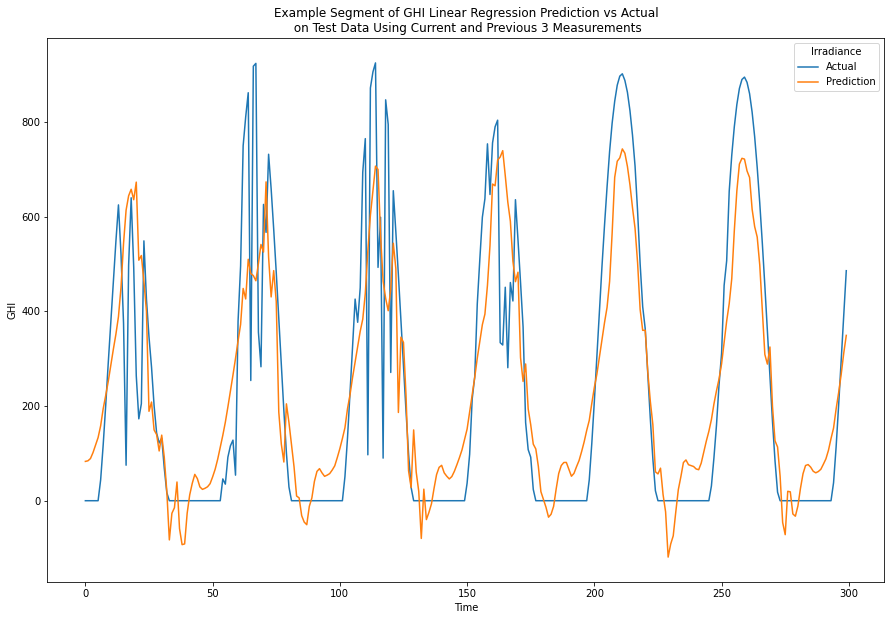

In [51]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of GHI Linear Regression Prediction vs Actual\n on Test Data Using Current and Previous 3 Measurements')
plt.xlabel('Time')
plt.show()

# Lasso Regression

Text(0.5, 1.0, 'Location of optimal solution as constraint changes')

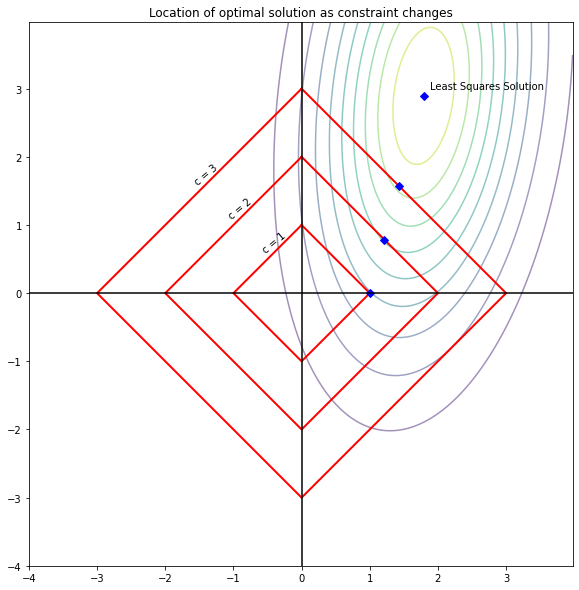

In [396]:
delta = 0.025
x = np.arange(-4.0, 4.0, delta)
y = np.arange(-4.0, 4.0, delta)
X, Y = np.meshgrid(x, y)
Z = np.exp(-0.5*(X-1.5)**2 - 0.1*(Y-2)**2 + 0.1*X*Y)

fig, ax = plt.subplots(figsize=(10,10))

CS = ax.contour(X, Y, Z, levels=10, alpha=0.5)

plt.plot([0,1,0,-1,0], [1,0,-1,0,1], color='red', linewidth=2)
plt.plot([0,2,0,-2,0], [2,0,-2,0,2], color='red', linewidth=2)
plt.plot([0,3,0,-3,0], [3,0,-3,0,3], color='red', linewidth=2)


plt.text(-0.1 - 3/2, 0.1 + 3/2,'c = 3', rotation=40)
plt.text(-0.1 - 2/2, 0.1 + 2/2,'c = 2', rotation=40)
plt.text(-0.1 - 1/2, 0.1 + 1/2,'c = 1', rotation=40)

plt.plot(34/19, 55/19, 'bD')
plt.text(34/19 + 0.1, 55/19 + 0.1, 'Least Squares Solution')
plt.plot(1.429, 1.571, 'bD')
plt.plot(1.214, 0.786, 'bD')
plt.plot(1, 0, 'bD')

plt.axhline(0, color='black')
plt.axvline(0, color='black')
ax.set_aspect('equal', adjustable='box')
ax.set_title('Location of optimal solution as constraint changes')

## Find best alpha for current measurements only

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34431.9185872226, tolerance: 24.667600000000018
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27975.39737471546, tolerance: 24.667600000000018
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22209.028677660674, tolerance: 24.667600000000018
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

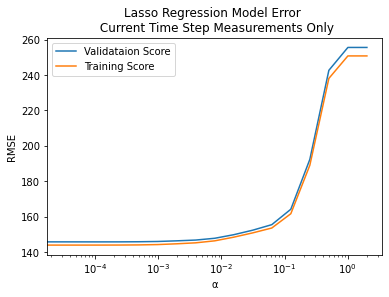

In [201]:
from sklearn.linear_model import Lasso

train_scores = []
val_scores = []
alpha = [0, 2**-15, 2**-14, 2**-13, 2**-12, 2**-11, 2**-10, 2**-9, 2**-8, 2**-7, 2**-6,\
         2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1]
w = np.empty((0, X_current_only_train.shape[1]))

for a in alpha:
    if a == 0:
        model = LinearRegression()
    else:
        model = Lasso(random_state = 15217, alpha=a)
      
    model.fit(X_current_only_train_norm, y_current_only_train_norm)
    
    val_prediction = model.predict(X_current_only_val_norm)
    val_prediction = y_current_only_train_scaler.inverse_transform(val_prediction)
    val_actual = y_current_only_val
    val_scores.append(mean_squared_error(val_actual, val_prediction, squared=False))
    
    train_prediction = model.predict(X_current_only_train_norm)
    train_prediction = y_current_only_train_scaler.inverse_transform(train_prediction)
    train_actual = y_current_only_train
    train_scores.append(mean_squared_error(train_actual, train_prediction, squared=False))
    
    w = np.append(w, model.coef_.reshape((1,-1)), axis=0)


plt.plot(alpha, val_scores, label='Validataion Score')
plt.plot(alpha, train_scores, label='Training Score')

plt.legend()
plt.title('Lasso Regression Model Error \n Current Time Step Measurements Only')
plt.xlabel('\u03B1')
plt.ylabel('RMSE')
plt.xscale('log')
plt.show()


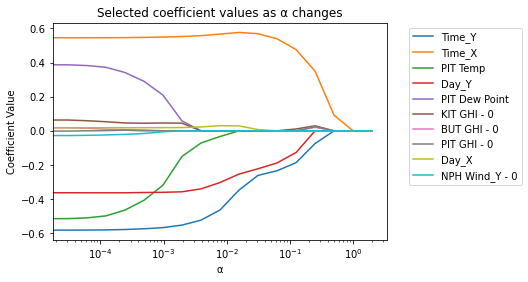

In [187]:
w_1 = w[:,1]
w_0 = w[:,0]
w_15 = w[:,15]
w_3 = w[:,3]
w_10 = w[:,10]

w_65 = w[:,65]
w_20 = w[:,20]
w_6 = w[:,6]
w_2 = w[:,2]
w_93 = w[:,93]

plt.plot(alpha, w_1, label='Time_Y')
plt.plot(alpha, w_0, label='Time_X')
plt.plot(alpha, w_15, label='PIT Temp')
plt.plot(alpha, w_3, label='Day_Y')
plt.plot(alpha, w_10, label='PIT Dew Point')

plt.plot(alpha, w_65, label='KIT GHI - 0')
plt.plot(alpha, w_20, label='BUT GHI - 0')
plt.plot(alpha, w_6, label='PIT GHI - 0')
plt.plot(alpha, w_2, label='Day_X')
plt.plot(alpha, w_93, label='NPH Wind_Y - 0')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('log')
plt.xlabel('\u03B1')
plt.ylabel('Coefficient Value')
plt.title('Selected coefficient values as \u03B1 changes')
plt.show()

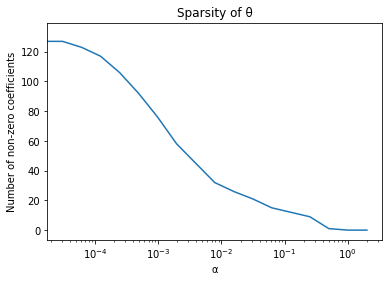

In [186]:
plt.plot(alpha, np.count_nonzero(w, axis=1))
plt.xscale('log')
plt.title('Sparsity of \u03B8')
plt.ylabel('Number of non-zero coefficients')
plt.xlabel('\u03B1')
plt.show()


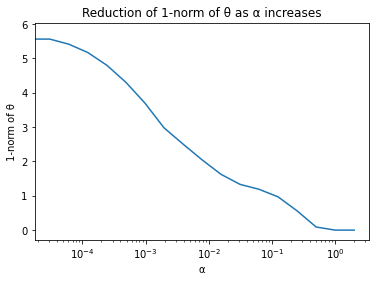

In [185]:
plt.plot(alpha, np.linalg.norm(w, ord=1, axis=1))
plt.xscale('log')
plt.xlabel('\u03B1')
plt.ylabel('1-norm of \u03B8')
plt.title('Reduction of 1-norm of \u03B8 as \u03B1 increases')
plt.show()

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.388611359272473, tolerance: 0.013299999999999998
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.867925681178169, tolerance: 0.013300000000000006
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2808170569468607, tolerance: 0.013300000000000001
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1375744477171326, tolerance: 0.013300000000000003
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0455630985707, tolerance: 0.013300000000000001
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1751684624238496, tolerance: 0.013300000000000001
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.299809297468533, tolerance: 0.013300000000000001
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.835007241018359, tolerance: 0.013300000000000001
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.537014884729441, tolerance: 0.013300000000000003
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.27536893982363, tolerance: 0.026600000000000002
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.952238186448046, tolerance: 0.026600000000000006
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.55170641116338, tolerance: 0.026599999999999995
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.120092749656422, tolerance: 0.026600000000000002
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.50927911592147, tolerance: 0.026600000000000002
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.410808465062939, tolerance: 0.026600000000000002
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5277776639062637, tolerance: 0.026600000000000006
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32559549765675655, tolerance: 0.026599999999999995
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25213206727760706, tolerance: 0.026600000000000006
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You 

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.96885779490187, tolerance: 0.053200000000000004
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.26272731895067, tolerance: 0.05319999999999999
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.47480051214092, tolerance: 0.05319999999999999
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.815807993024237, tolerance: 0.053200000000000004
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.000253392471294, tolerance: 0.05319999999999999
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.375471462538314, tolerance: 0.053199999999999976
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148.30061445338688, tolerance: 0.10640000000000001
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138.7186175761371, tolerance: 0.10639999999999998
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.30140967850872, tolerance: 0.10640000000000005
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.42244615955576, tolerance: 0.10640000000000001
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.27932350127628, tolerance: 0.10640000000000001
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.30712114309, tolerance: 0.10640000000000001
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46229055064009117, tolerance: 0.10640000000000001
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11097492074298998, tolerance: 0.10640000000000002
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2041524294457986, tolerance: 0.10640000000000001
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mig

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129.33987274865822, tolerance: 0.21279999999999996
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.4643391537595, tolerance: 0.21280000000000004
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164.28808341154738, tolerance: 0.21280000000000002
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.929863030544425, tolerance: 0.21280000000000002
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.666178488256833, tolerance: 0.21280000000000002
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.33643745183906, tolerance: 0.21280000000000002
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

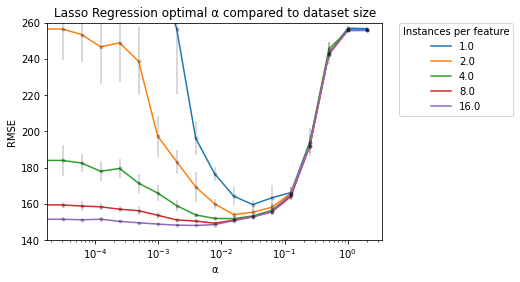

In [371]:

m = X_current_only_train.shape[1]

for i in range(1,6):
    
    val_scores_mean = []
    val_scores_std = []
    
    alpha = [0, 2**-15, 2**-14, 2**-13, 2**-12, 2**-11, 2**-10, 2**-9, 2**-8, 2**-7, 2**-6,\
         2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1]
    
    for a in alpha:
        
        val_scores = []
        
        for j in range(10):
            
            # get a sample of training X and y
            train_sample_X = X_current_only_train.sample(m*(2**(i-1)))
            sample_size = train_sample_X.shape[0]/m
            ind = train_sample_X.index

            train_sample_y = y_current_only_train.iloc[ind]

            # scaler for sample X data
            train_sample_X_scaler = StandardScaler()
            train_sample_y_scaler = StandardScaler()

            # fit and transform sample X
            train_sample_X_norm = train_sample_X_scaler.fit_transform(train_sample_X)
            train_sample_y_norm = train_sample_y_scaler.fit_transform(train_sample_y)

            # transform val set
            val_sample_X_norm = train_sample_X_scaler.transform(X_current_only_val)

            if a == 0:
                model = LinearRegression()
            else:
                model = Lasso(alpha=a)

            model.fit(train_sample_X_norm, train_sample_y_norm)

            val_prediction = model.predict(val_sample_X_norm)
            val_prediction = train_sample_y_scaler.inverse_transform(val_prediction)
            val_actual = y_current_only_val
            val_scores.append(mean_squared_error(val_actual, val_prediction, squared=False))
            
        val_scores_mean.append(np.mean(val_scores))
        val_scores_std.append(np.std(val_scores))
        
    plt.plot(alpha, val_scores_mean, label=f'{sample_size}'.format(sample_size=sample_size))
    plt.errorbar(alpha, val_scores_mean, yerr=val_scores_std, fmt='.k', alpha=0.2)

plt.legend(title='Instances per feature', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Lasso Regression optimal \u03B1 compared to dataset size')

plt.xlabel('\u03B1')
plt.ylabel('RMSE')
plt.xscale('log')
plt.ylim([140,260])
plt.show()
    
    

### Check highest coefficient value for high alpha model

In [192]:
model = Lasso(random_state = 15217, alpha=2**-8)
model.fit(X_current_only_train_val_norm, y_current_only_train_val_norm)

vals = abs(model.coef_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_only_train_val.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[largest_idx])
print(largest_idx)
print(largest_list)


smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_only_train_val.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nnumber of non-zero elements')
print(np.count_nonzero(vals))
print('\nnumber of zero elements')
print(len(vals)-np.count_nonzero(vals))


coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)


n largest abs:
[ 0.55937886 -0.52590649 -0.33889703 -0.25132381 -0.08810498]
[0, 1, 3, 8, 30]
['Time_X', 'Time_Y', 'Day_Y', 'PIT_Clearsky DNI-0', 'CBG_Clearsky DHI-0']

number of non-zero elements
44

number of zero elements
89

Magnitude of the coef vector:
0.89453094724703


In [195]:
model = Lasso(random_state = 15217, alpha=2**-2)
model.fit(X_current_only_train_val_norm, y_current_only_train_val_norm)

vals = abs(model.coef_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_only_train_val.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[largest_idx])
print(largest_idx)
print(largest_list)


smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_only_train_val.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nnumber of non-zero elements')
print(np.count_nonzero(vals))
print('\nnumber of zero elements')
print(len(vals)-np.count_nonzero(vals))


coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)


n largest abs:
[ 0.35079799 -0.07964096  0.0303174   0.02779373  0.02466382]
[0, 1, 128, 65, 20]
['Time_X', 'Time_Y', 'YGT_DNI-0', 'KIT_GHI-0', 'BUT_GHI-0']

number of non-zero elements
9

number of zero elements
124

Magnitude of the coef vector:
0.36397213548844526


### Find best alpha for current and previous measurements

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27621.935812911637, tolerance: 24.667499999999933
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25233.202183044665, tolerance: 24.667499999999933
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21353.790860545418, tolerance: 24.667499999999933
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

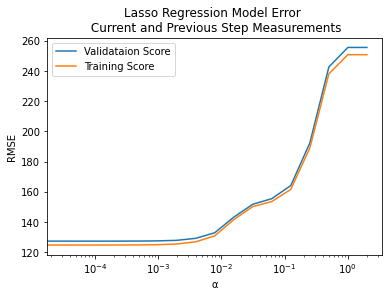

In [203]:
val_scores = []
train_scores = []
alpha = [0, 2**-15, 2**-14, 2**-13, 2**-12, 2**-11, 2**-10, 2**-9, 2**-8, 2**-7, 2**-6,\
         2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1]
w = np.empty((0, X_current_and_previous_train.shape[1]))

for a in alpha:
    if a == 0:
        model = LinearRegression()
    else:
        model = Lasso(random_state = 15217, alpha=a)
      
    model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm)
    
    val_prediction = model.predict(X_current_and_previous_val_norm)
    val_prediction = y_current_and_previous_train_scaler.inverse_transform(val_prediction)
    val_actual = y_current_and_previous_val
    val_scores.append(mean_squared_error(val_actual, val_prediction, squared=False))
    
    train_prediction = model.predict(X_current_and_previous_train_norm)
    train_prediction = y_current_and_previous_train_scaler.inverse_transform(train_prediction)
    train_actual = y_current_and_previous_train
    train_scores.append(mean_squared_error(train_actual, train_prediction, squared=False))
    
    w = np.append(w, model.coef_.reshape((1,-1)), axis=0)

                  
plt.plot(alpha, val_scores, label='Validataion Score')
plt.plot(alpha, train_scores, label='Training Score')

plt.legend()
plt.title('Lasso Regression Model Error \n Current and Previous Step Measurements')
plt.xlabel('\u03B1')
plt.ylabel('RMSE')
plt.xscale('log')
plt.show()


In [196]:
model = Lasso(random_state = 15217, alpha=2**-8)
model.fit(X_current_and_previous_train_val_norm, y_current_and_previous_train_val_norm)

vals = abs(model.coef_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_train_val.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[largest_idx])
print(largest_idx)
print(largest_list)


smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_train_val.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nnumber of non-zero elements')
print(np.count_nonzero(vals))
print('\nnumber of zero elements')
print(len(vals)-np.count_nonzero(vals))


coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)


n largest abs:
[-0.53872132  0.40277009 -0.31865485 -0.31320683 -0.11881967]
[1, 0, 3, 11, 194]
['Time_Y', 'Time_X', 'Day_Y', 'PIT_Clearsky DNI-0', 'YGT_GHI-1']

number of non-zero elements
128

number of zero elements
71

Magnitude of the coef vector:
0.9639582024841046


/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1065.5386029848305, tolerance: 30.83439999999982
  positive)


In [197]:
model = Lasso(random_state = 15217, alpha=2**-2)
model.fit(X_current_and_previous_train_val_norm, y_current_and_previous_train_val_norm)

vals = abs(model.coef_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_train_val.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[largest_idx])
print(largest_idx)
print(largest_list)


smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_train_val.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nnumber of non-zero elements')
print(np.count_nonzero(vals))
print('\nnumber of zero elements')
print(len(vals)-np.count_nonzero(vals))


coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)


n largest abs:
[ 0.35079845 -0.07963929  0.03031713  0.02779379  0.02466383]
[0, 1, 191, 92, 26]
['Time_X', 'Time_Y', 'YGT_DNI-0', 'KIT_GHI-0', 'BUT_GHI-0']

number of non-zero elements
9

number of zero elements
190

Magnitude of the coef vector:
0.3639722050023467


### Find best alpha for current and previous 3 measurements

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26251.876069319856, tolerance: 24.667400000000033
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23932.112337808612, tolerance: 24.667400000000033
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20764.22560526654, tolerance: 24.667400000000033
  positive)
/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

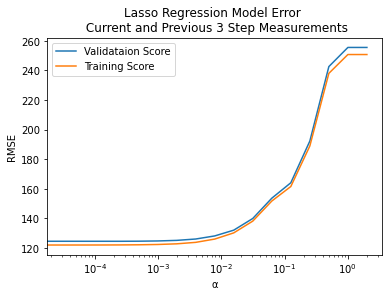

In [204]:
val_scores = []
train_scores = []
alpha = [0, 2**-15, 2**-14, 2**-13, 2**-12, 2**-11, 2**-10, 2**-9, 2**-8, 2**-7, 2**-6,\
         2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1]
w = np.empty((0, X_current_and_previous_3_train.shape[1]))

for a in alpha:
    if a == 0:
        model = LinearRegression()
    else:
        model = Lasso(random_state = 15217, alpha=a)
      
    model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm)
    
    val_prediction = model.predict(X_current_and_previous_3_val_norm)
    val_prediction = y_current_and_previous_3_train_scaler.inverse_transform(val_prediction)
    val_actual = y_current_and_previous_3_val
    val_scores.append(mean_squared_error(val_actual, val_prediction, squared=False))
    
    train_prediction = model.predict(X_current_and_previous_3_train_norm)
    train_prediction = y_current_and_previous_3_train_scaler.inverse_transform(train_prediction)
    train_actual = y_current_and_previous_3_train
    train_scores.append(mean_squared_error(train_actual, train_prediction, squared=False))
    
    w = np.append(w, model.coef_.reshape((1,-1)), axis=0)

                  
plt.plot(alpha, val_scores, label='Validataion Score')
plt.plot(alpha, train_scores, label='Training Score')

plt.legend()
plt.title('Lasso Regression Model Error \n Current and Previous 3 Step Measurements')
plt.xlabel('\u03B1')
plt.ylabel('RMSE')
plt.xscale('log')
plt.show()


In [198]:
model = Lasso(random_state = 15217, alpha=2**-8)
model.fit(X_current_and_previous_3_train_val_norm, y_current_and_previous_3_train_val_norm)

vals = abs(model.coef_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_3_train_val.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[largest_idx])
print(largest_idx)
print(largest_list)


smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_3_train_val.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nnumber of non-zero elements')
print(np.count_nonzero(vals))
print('\nnumber of zero elements')
print(len(vals)-np.count_nonzero(vals))


coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)


n largest abs:
[-0.62029971 -0.39788816 -0.34934928  0.32259319 -0.08030423]
[1, 17, 3, 0, 213]
['Time_Y', 'PIT_Clearsky DNI-0', 'Day_Y', 'Time_X', 'NPH_GHI-3']

number of non-zero elements
125

number of zero elements
206

Magnitude of the coef vector:
0.9331874323874634


/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375.88487488013925, tolerance: 30.834300000000212
  positive)


In [199]:
model = Lasso(random_state = 15217, alpha=2**-2)
model.fit(X_current_and_previous_3_train_val_norm, y_current_and_previous_3_train_val_norm)

vals = abs(model.coef_)
import heapq
largest_idx = heapq.nlargest(5, range(len(vals)), key=vals.__getitem__)
largest_val = heapq.nlargest(5, vals)
largest_list = [X_current_and_previous_3_train_val.columns[largest_idx[i]] for i in range(len(largest_idx))]
print('\nn largest abs:')
print(model.coef_[largest_idx])
print(largest_idx)
print(largest_list)


smallest_idx = heapq.nsmallest(5, range(len(vals)), key=vals.__getitem__)
smallest_val = heapq.nsmallest(5, vals)
smallest_list = [X_current_and_previous_3_train_val.columns[smallest_idx[i]] for i in range(len(smallest_idx))]
print('\nnumber of non-zero elements')
print(np.count_nonzero(vals))
print('\nnumber of zero elements')
print(len(vals)-np.count_nonzero(vals))


coef_norm = np.linalg.norm(vals)
print('\nMagnitude of the coef vector:')
print(coef_norm)


n largest abs:
[ 0.3508006  -0.07963454  0.03031626  0.02779392  0.02466384]
[0, 1, 317, 146, 38]
['Time_X', 'Time_Y', 'YGT_DNI-0', 'KIT_GHI-0', 'BUT_GHI-0']

number of non-zero elements
9

number of zero elements
322

Magnitude of the coef vector:
0.3639732202785943


# Decision Tree

## Current Only Data

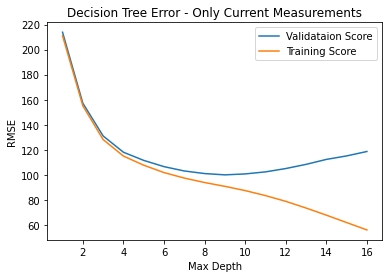

In [147]:
from sklearn.tree import DecisionTreeRegressor

val_scores = []
train_scores = []
max_depths = range(1, 17)

for d in max_depths:

    model = DecisionTreeRegressor(max_depth=d, random_state=15217)
    model.fit(X_current_only_train, y_current_only_train)
    
    val_prediction = model.predict(X_current_only_val)
    val_actual = y_current_only_val
    val_scores.append(mean_squared_error(val_actual, val_prediction, squared=False))
    
    train_prediction = model.predict(X_current_only_train)
    train_actual = y_current_only_train
    train_scores.append(mean_squared_error(train_actual, train_prediction, squared=False))

plt.plot(max_depths, val_scores, label='Validataion Score')
plt.plot(max_depths, train_scores, label='Training Score')

plt.legend()
plt.title('Decision Tree Error - Only Current Measurements')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()


### Show how shallow, deep, and optimal trees fit the model


RMSE:
131.048566583183


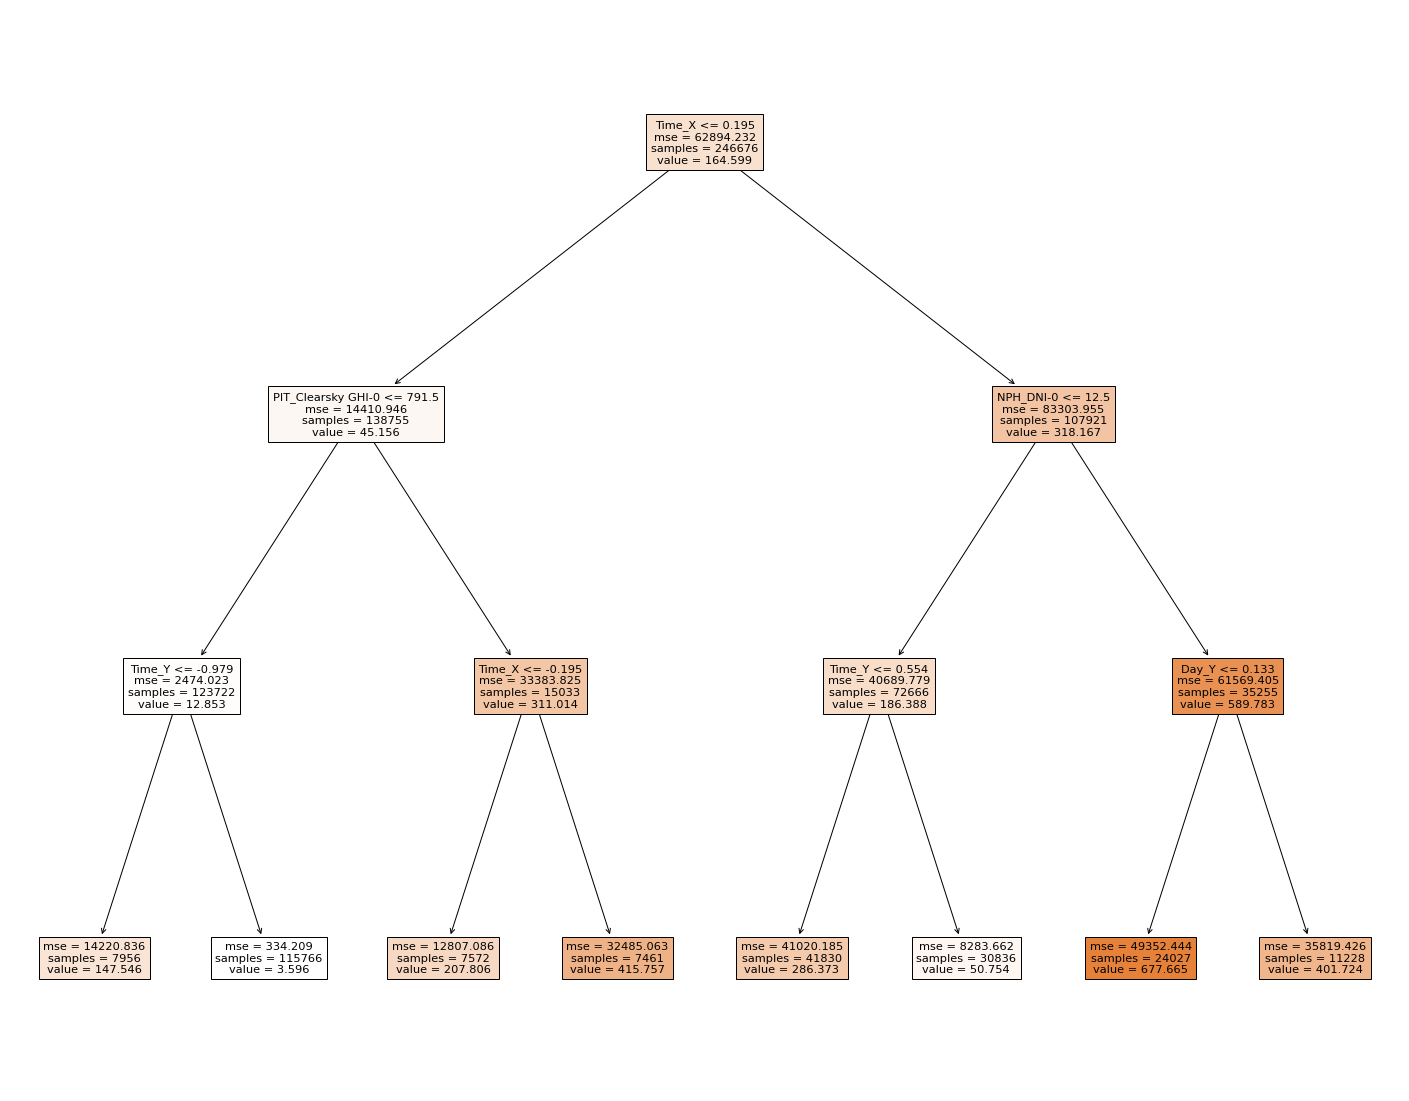

In [127]:
# Create and fit a SHALLOW model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=3 , random_state=15217)
model.fit(X_current_only_train, y_current_only_train)

# evaluate model on val set
prediction = model.predict(X_current_only_val)

actual = y_current_only_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_only_train.columns, 
                   max_depth=3, 
                   filled=True)

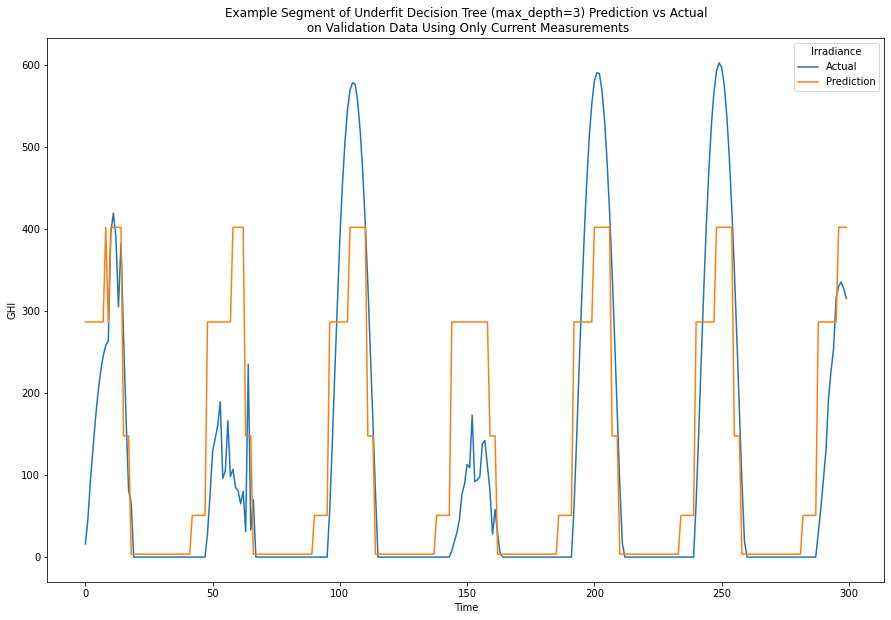

In [128]:
# Show performance of underfit model on validation set
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Underfit Decision Tree (max_depth=3) Prediction vs Actual\n on Validation Data Using Only Current Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
128.14115589942688


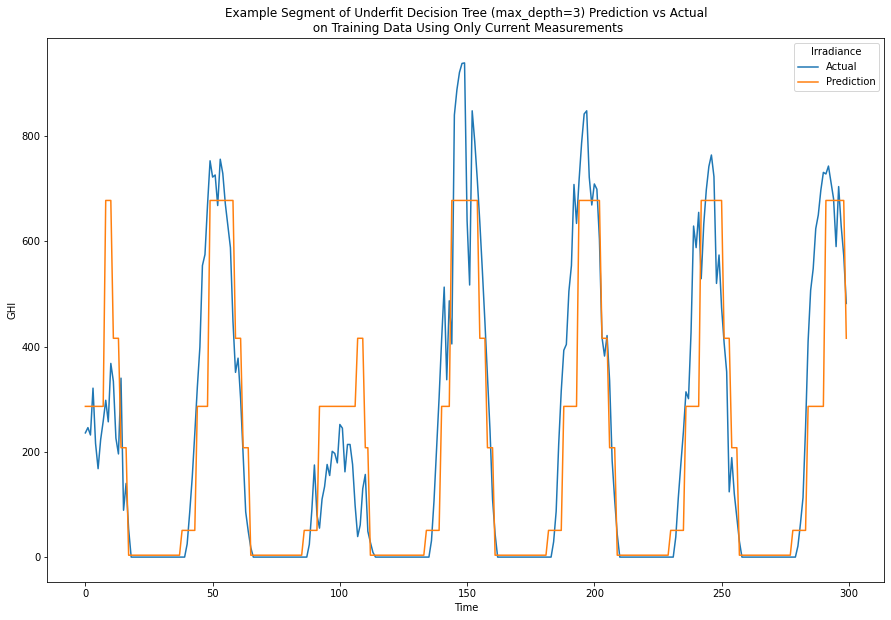

In [136]:
# evaluate and visualize underfit model on training set

prediction = model.predict(X_current_only_train)

actual = y_current_only_train

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[5100:5400,0], 'Prediction' : prediction[5100:5400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Underfit Decision Tree (max_depth=3) Prediction vs Actual\n on Training Data Using Only Current Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
99.95443437108884


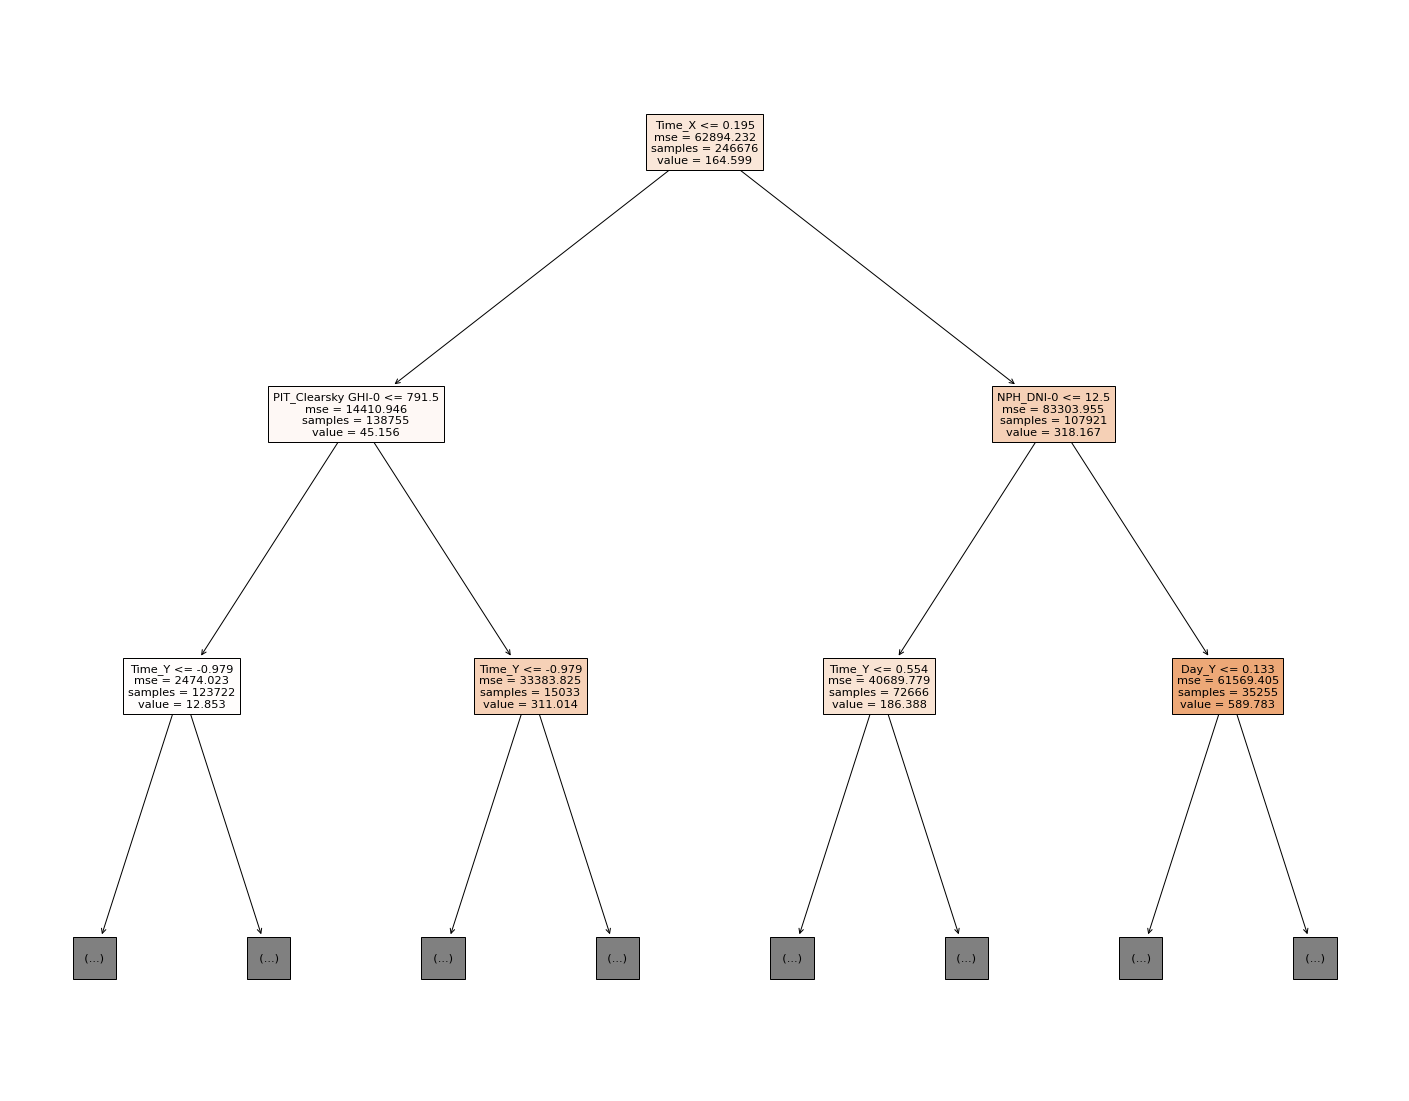

In [137]:
# Create and fit a OPTIMAL model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_only_train, y_current_only_train)

# evaluate model on val set
prediction = model.predict(X_current_only_val)

actual = y_current_only_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_only_train.columns, 
                   max_depth=2, 
                   filled=True)

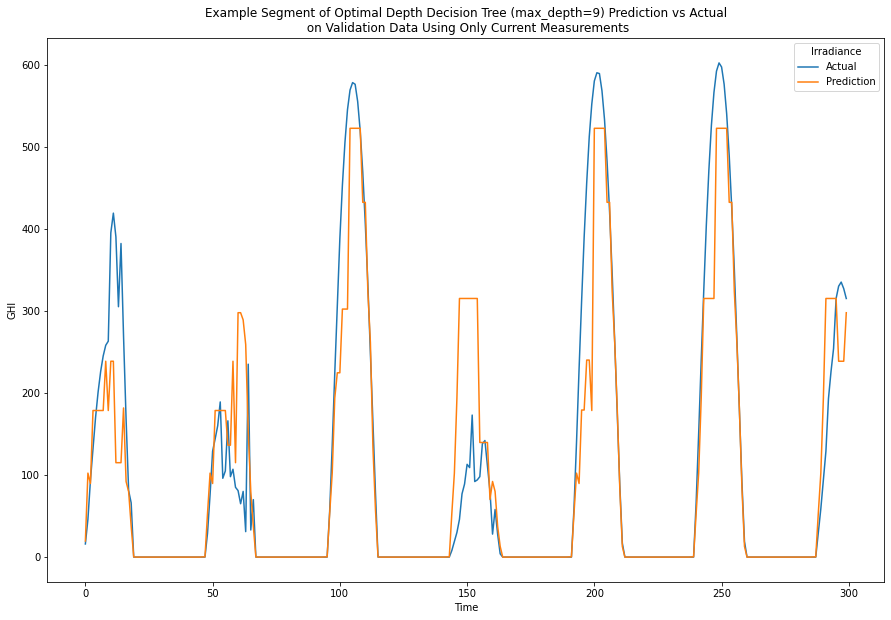

In [139]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Depth Decision Tree (max_depth=9) Prediction vs Actual\n on Validation Data Using Only Current Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
90.77094773747142


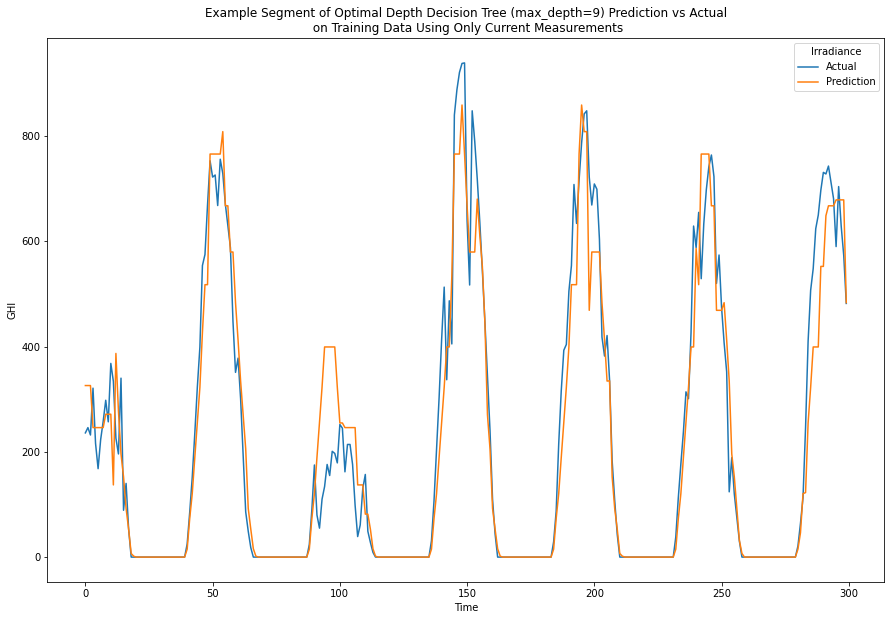

In [140]:
# evaluate and visualize optimal model on training set

prediction = model.predict(X_current_only_train)

actual = y_current_only_train

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[5100:5400,0], 'Prediction' : prediction[5100:5400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Depth Decision Tree (max_depth=9) Prediction vs Actual\n on Training Data Using Only Current Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
118.62169792780624


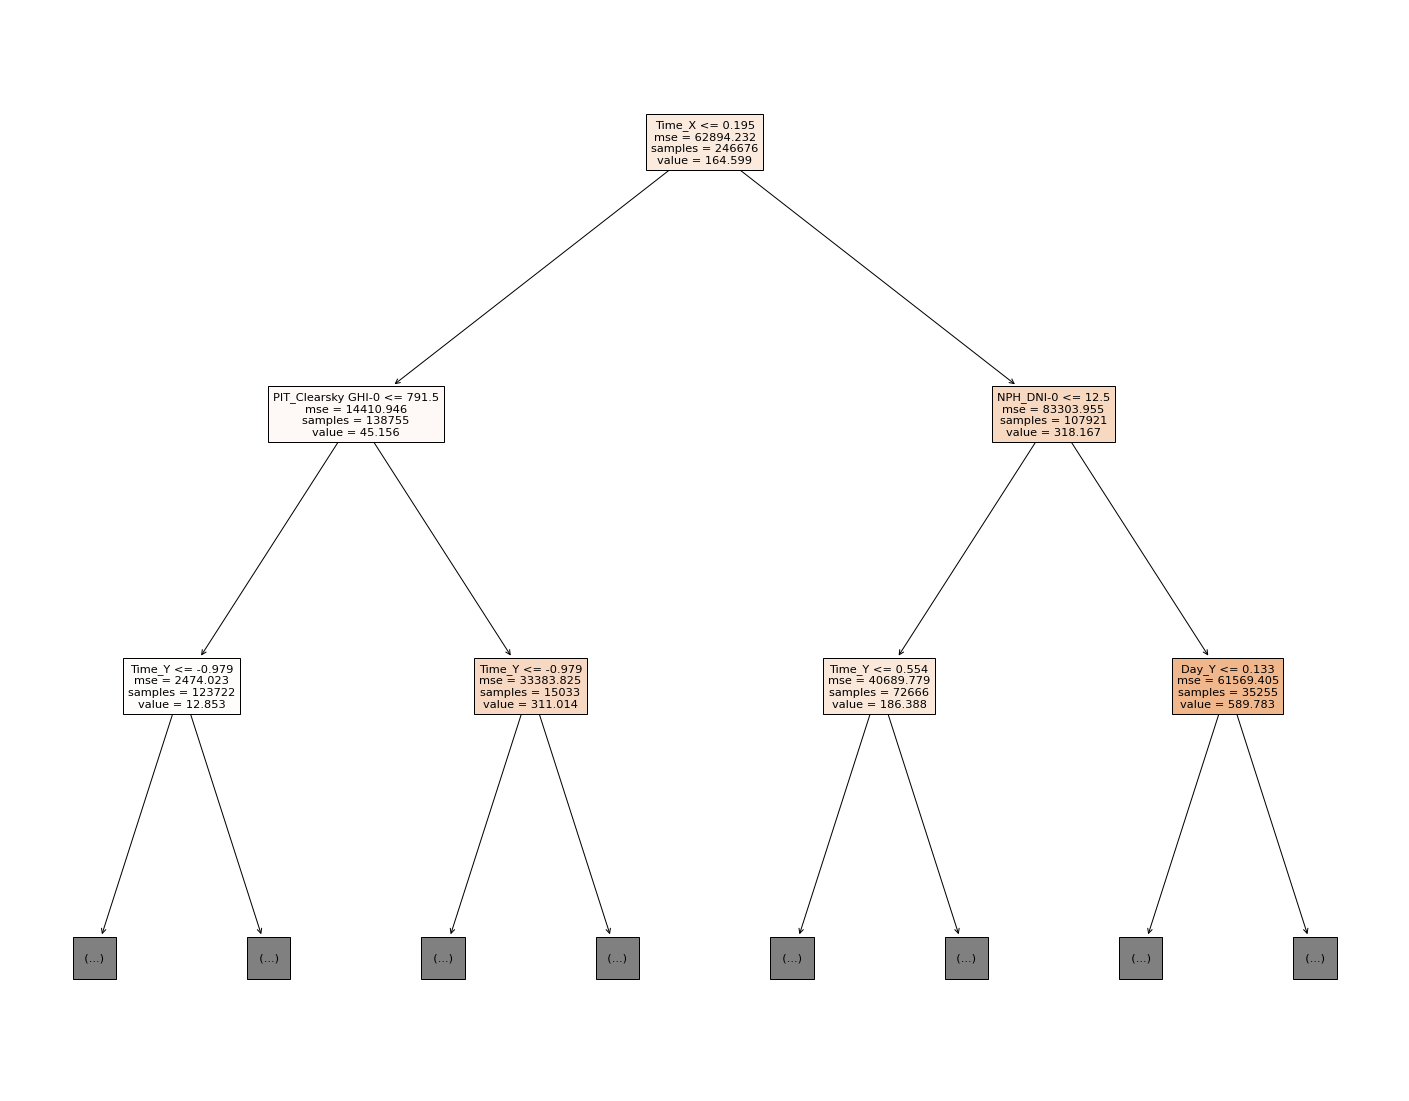

In [141]:
# Create and fit a TOO DEEP model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=16 , random_state=15217)
model.fit(X_current_only_train, y_current_only_train)

# evaluate model on val set
prediction = model.predict(X_current_only_val)

actual = y_current_only_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_only_train.columns, 
                   max_depth=2, 
                   filled=True)

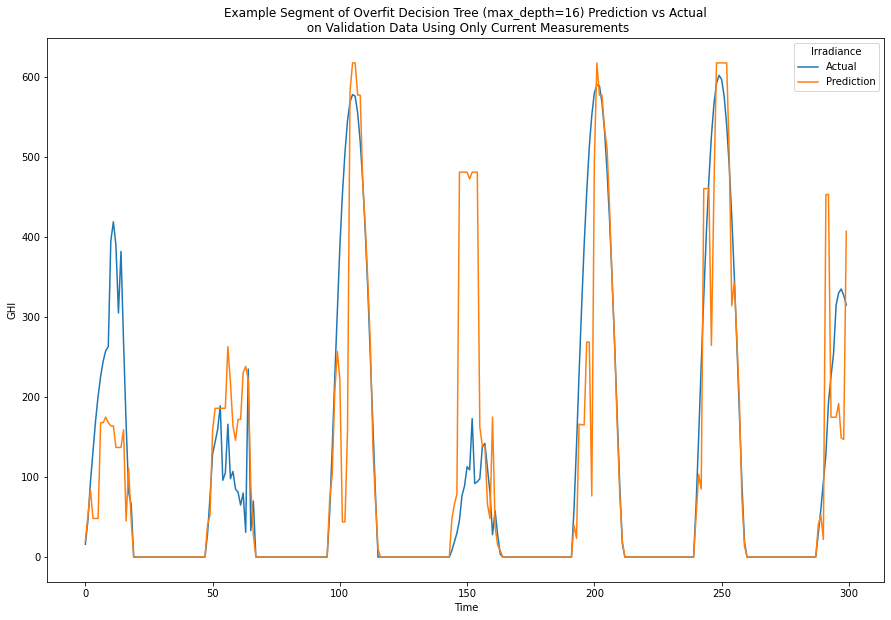

In [142]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Overfit Decision Tree (max_depth=16) Prediction vs Actual\n on Validation Data Using Only Current Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
55.97987737951836


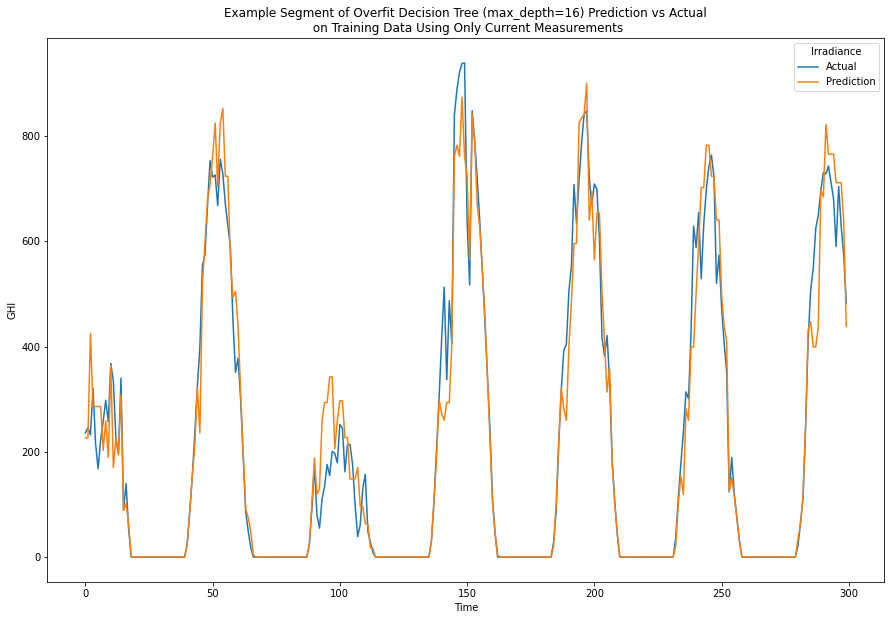

In [143]:
# evaluate and visualize overfit model on training set

prediction = model.predict(X_current_only_train)

actual = y_current_only_train

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[5100:5400,0], 'Prediction' : prediction[5100:5400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Overfit Decision Tree (max_depth=16) Prediction vs Actual\n on Training Data Using Only Current Measurements')
plt.xlabel('Time')
plt.show()

### Optimal model for current measurements only, fit on train_val set


RMSE:
98.06512295595645


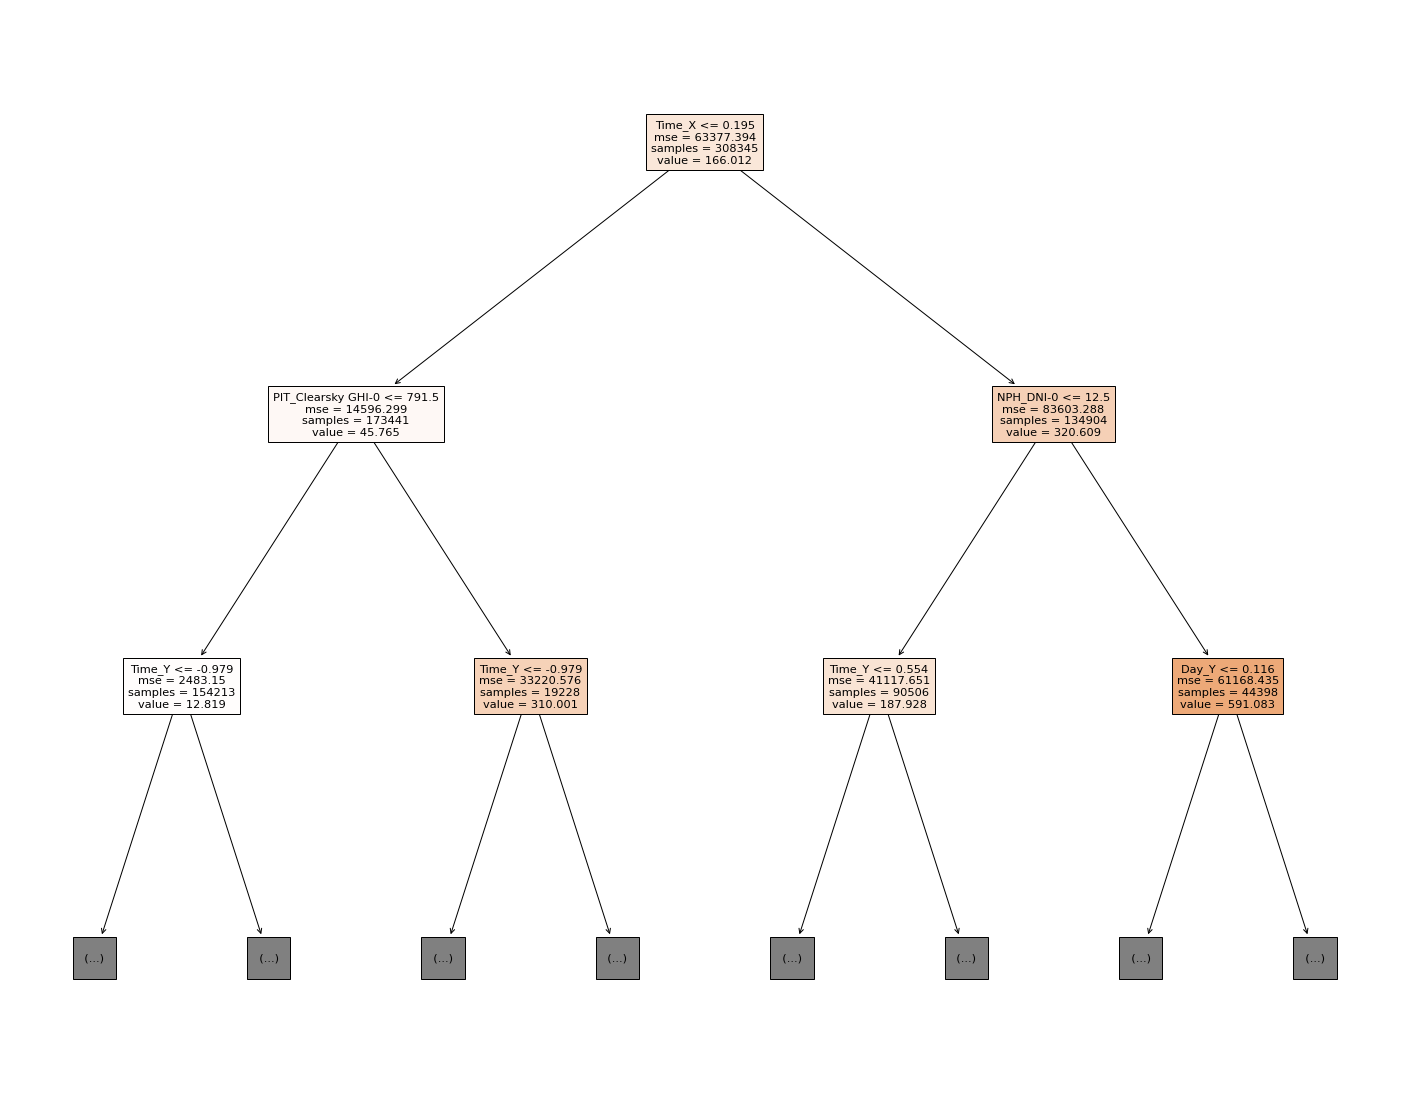

In [95]:
# Create and fit a OPTIMAL model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_only_train_val, y_current_only_train_val)

# evaluate model on test set
prediction = model.predict(X_current_only_test)

actual = y_current_only_test

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_only_train.columns, 
                   max_depth=2, 
                   filled=True)

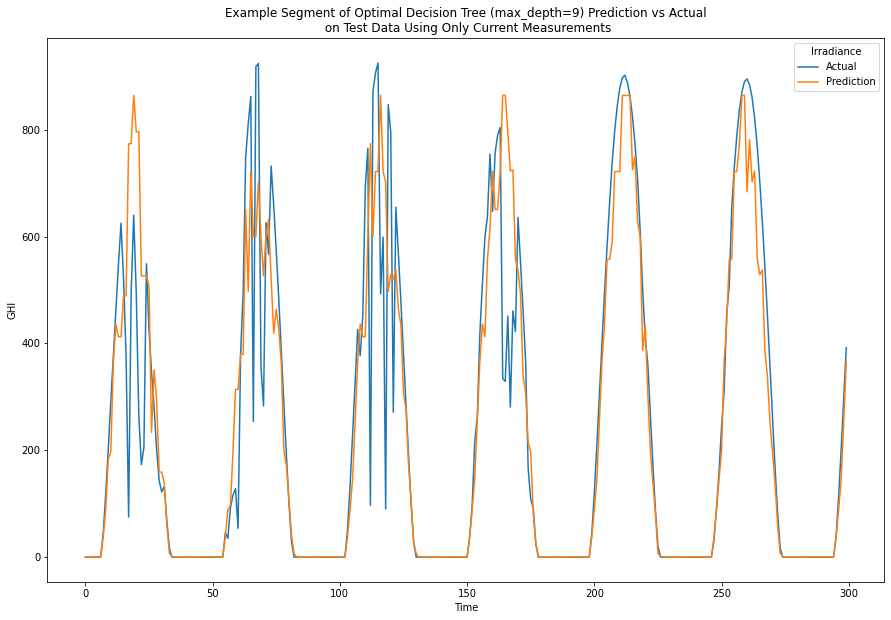

In [96]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Decision Tree (max_depth=9) Prediction vs Actual\n on Test Data Using Only Current Measurements')
plt.xlabel('Time')
plt.show()

## Current and Previous Time Step Data

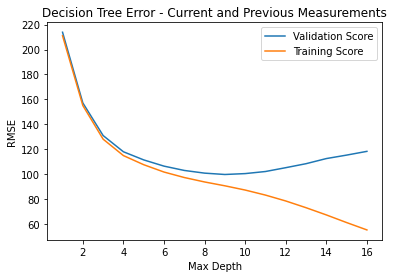

In [148]:
from sklearn.tree import DecisionTreeRegressor


val_scores = []
train_scores = []
max_depths = range(1, 17)

for d in max_depths:

    model = DecisionTreeRegressor(max_depth=d, random_state=15217)
    model.fit(X_current_and_previous_train, y_current_and_previous_train)
    
    val_prediction = model.predict(X_current_and_previous_val)
    val_actual = y_current_and_previous_val
    val_scores.append(mean_squared_error(val_actual, val_prediction, squared=False))

    train_prediction = model.predict(X_current_and_previous_train)
    train_actual = y_current_and_previous_train
    train_scores.append(mean_squared_error(train_actual, train_prediction, squared=False))
    
plt.plot(max_depths, val_scores, label='Validation Score')
plt.plot(max_depths, train_scores, label='Training Score')

plt.legend()
plt.title('Decision Tree Error - Current and Previous Measurements')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()


### Show how shallow, deep, and optimal trees fit the model



RMSE:
131.04856657378994


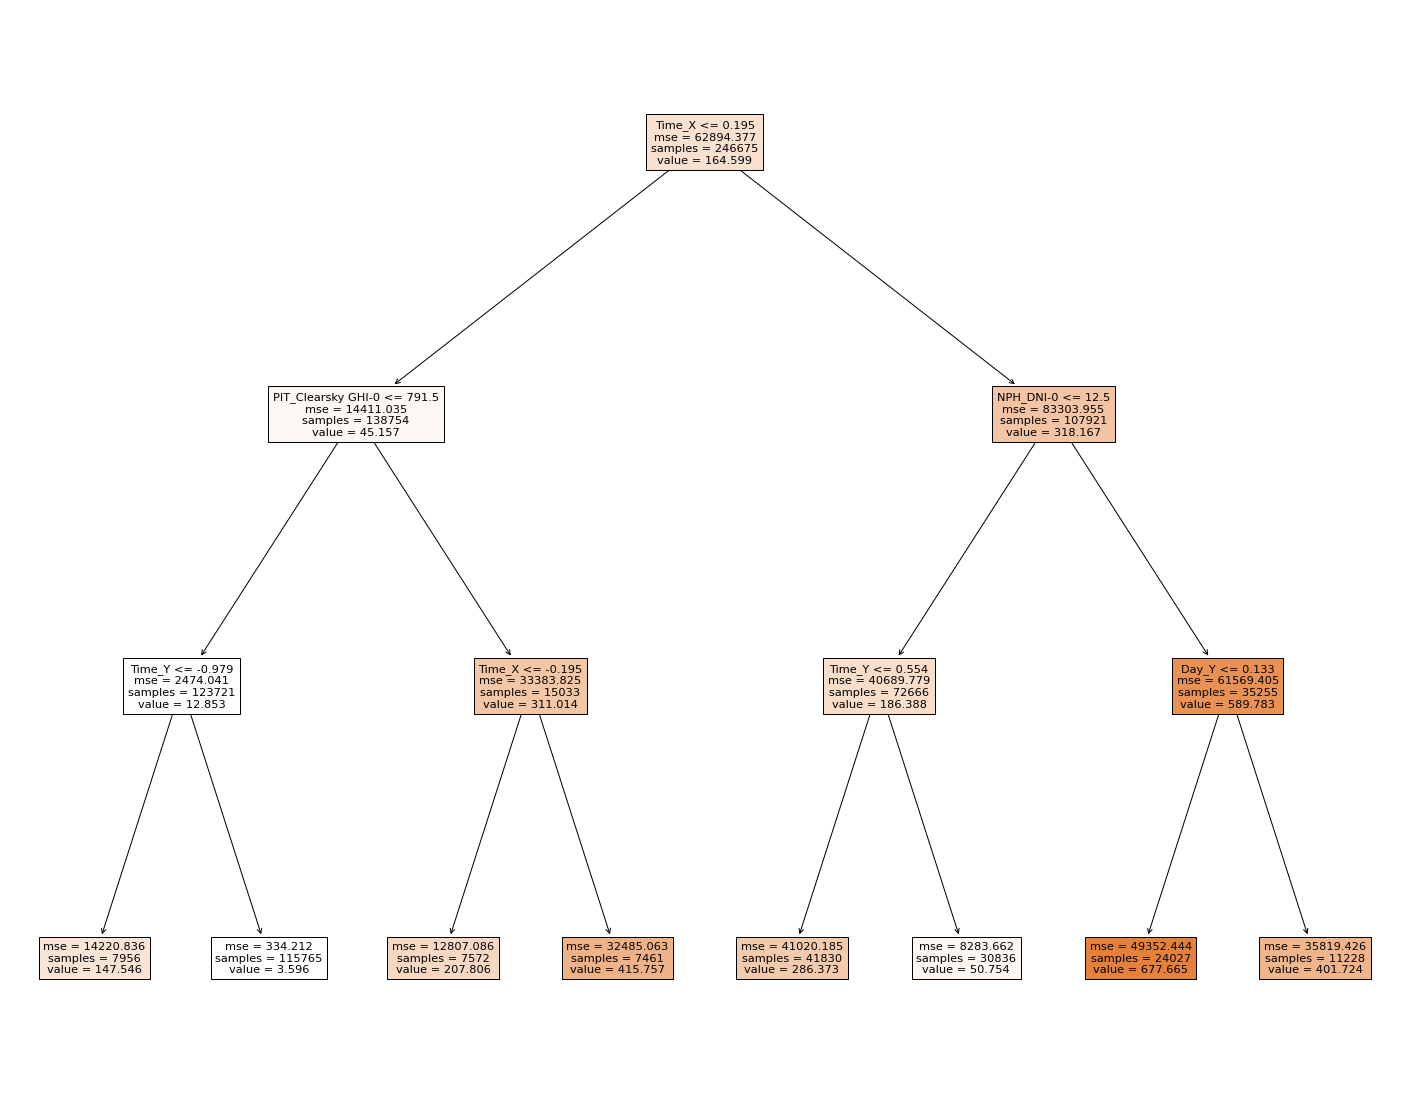

In [98]:
# Create and fit a SHALLOW model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=3 , random_state=15217)
model.fit(X_current_and_previous_train, y_current_and_previous_train)

# evaluate model on val set
prediction = model.predict(X_current_and_previous_val)

actual = y_current_and_previous_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_train.columns, 
                   max_depth=3, 
                   filled=True)

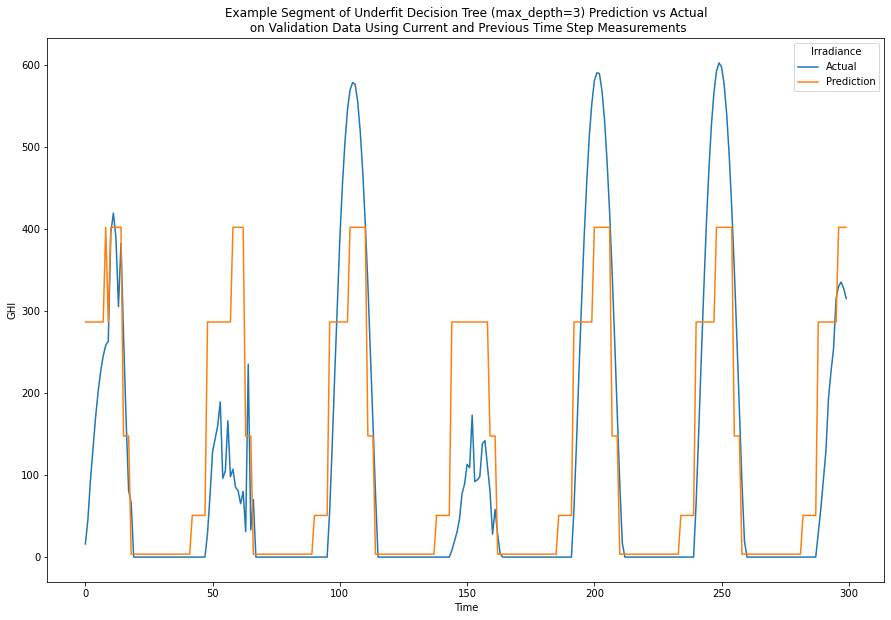

In [99]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Underfit Decision Tree (max_depth=3) Prediction vs Actual\n on Validation Data Using Current and Previous Time Step Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
99.82446131929807


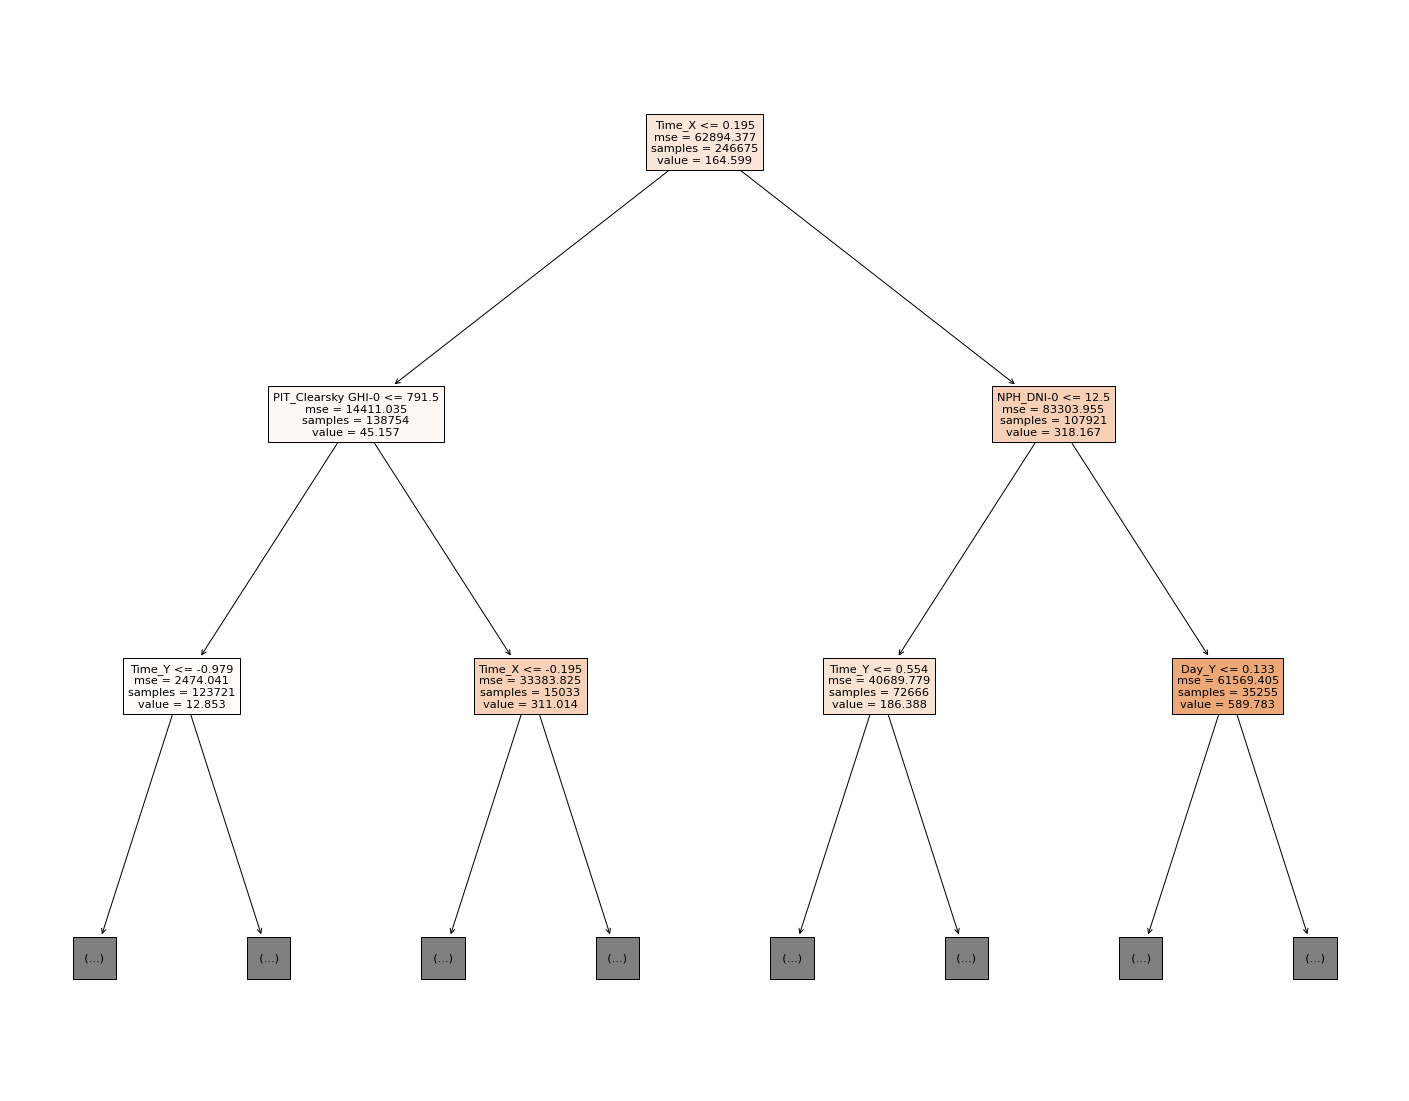

In [100]:
# Create and fit a OPTIMAL model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_and_previous_train, y_current_and_previous_train)

# evaluate model on val set
prediction = model.predict(X_current_and_previous_val)

actual = y_current_and_previous_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_train.columns, 
                   max_depth=2, 
                   filled=True)

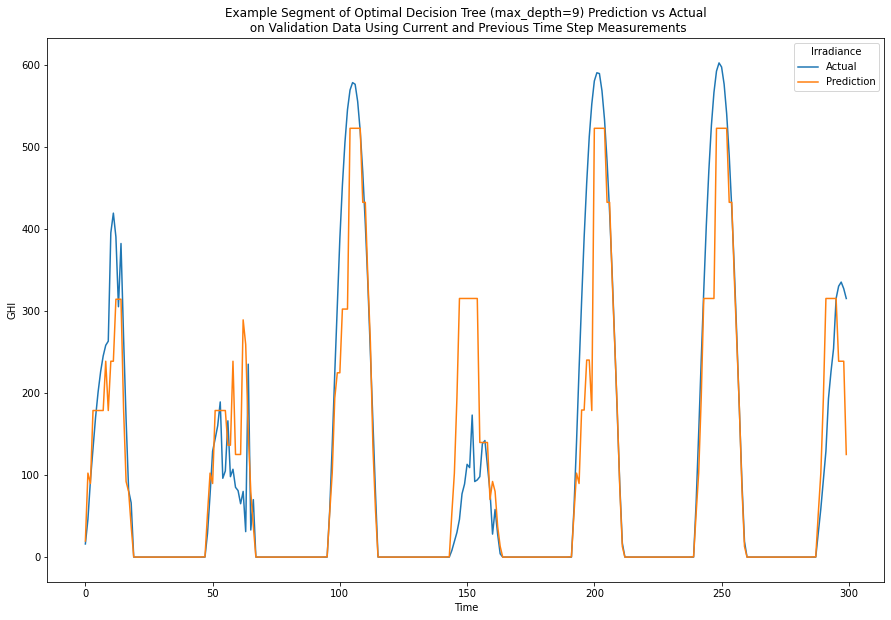

In [101]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Decision Tree (max_depth=9) Prediction vs Actual\n on Validation Data Using Current and Previous Time Step Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
118.37433366649321


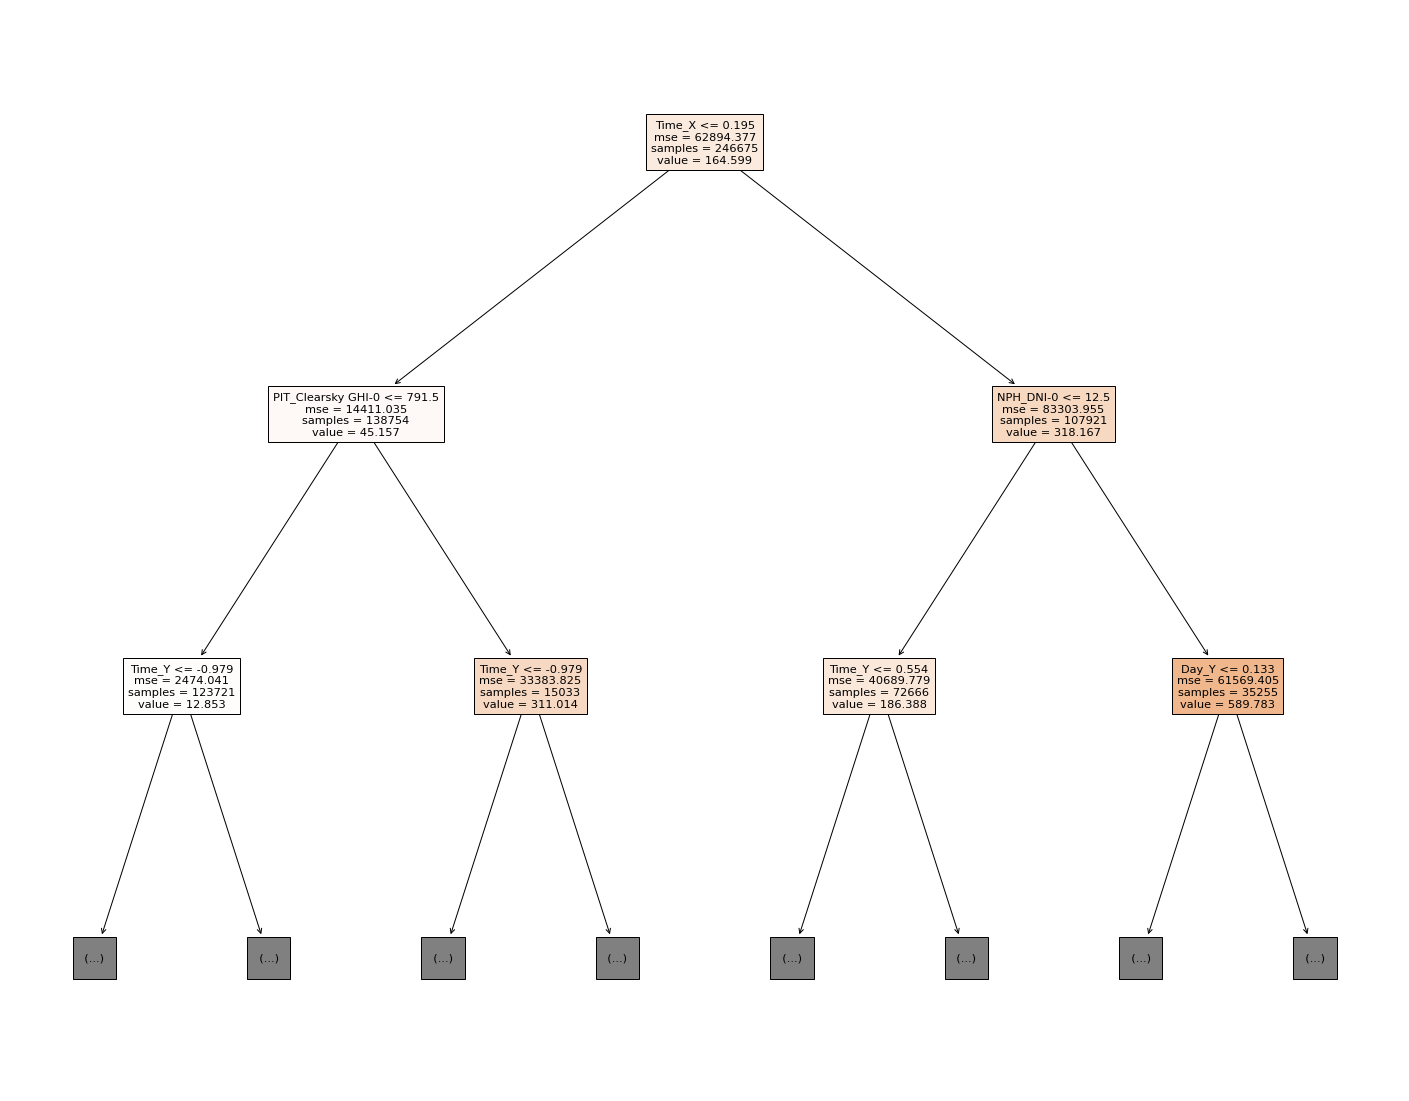

In [102]:
# Create and fit a Overfit model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=16 , random_state=15217)
model.fit(X_current_and_previous_train, y_current_and_previous_train)

# evaluate model on val set
prediction = model.predict(X_current_and_previous_val)

actual = y_current_and_previous_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_train.columns, 
                   max_depth=2, 
                   filled=True)

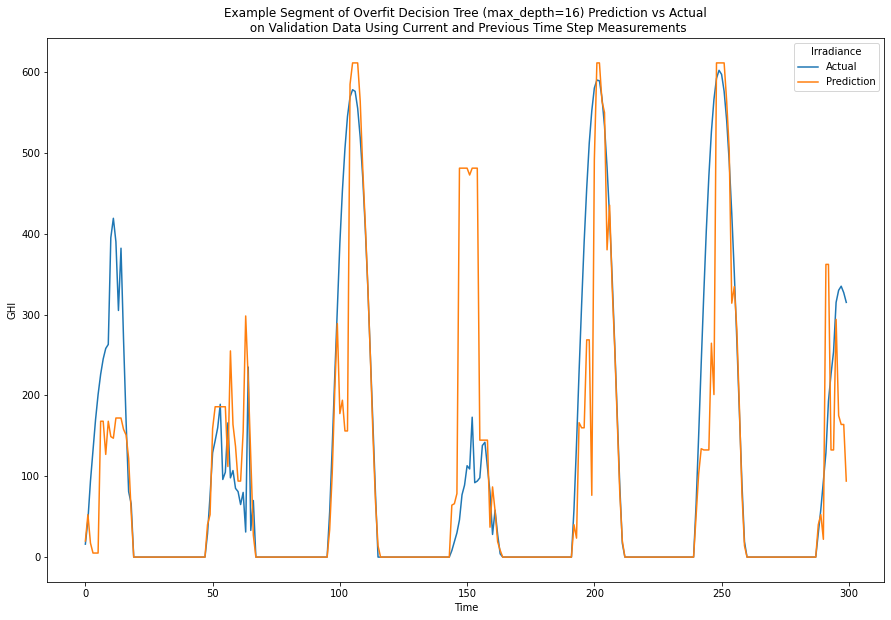

In [103]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Overfit Decision Tree (max_depth=16) Prediction vs Actual\n on Validation Data Using Current and Previous Time Step Measurements')
plt.xlabel('Time')
plt.show()

### Optimal model for current measurements only, fit on train_val set


RMSE:
98.12763069137569


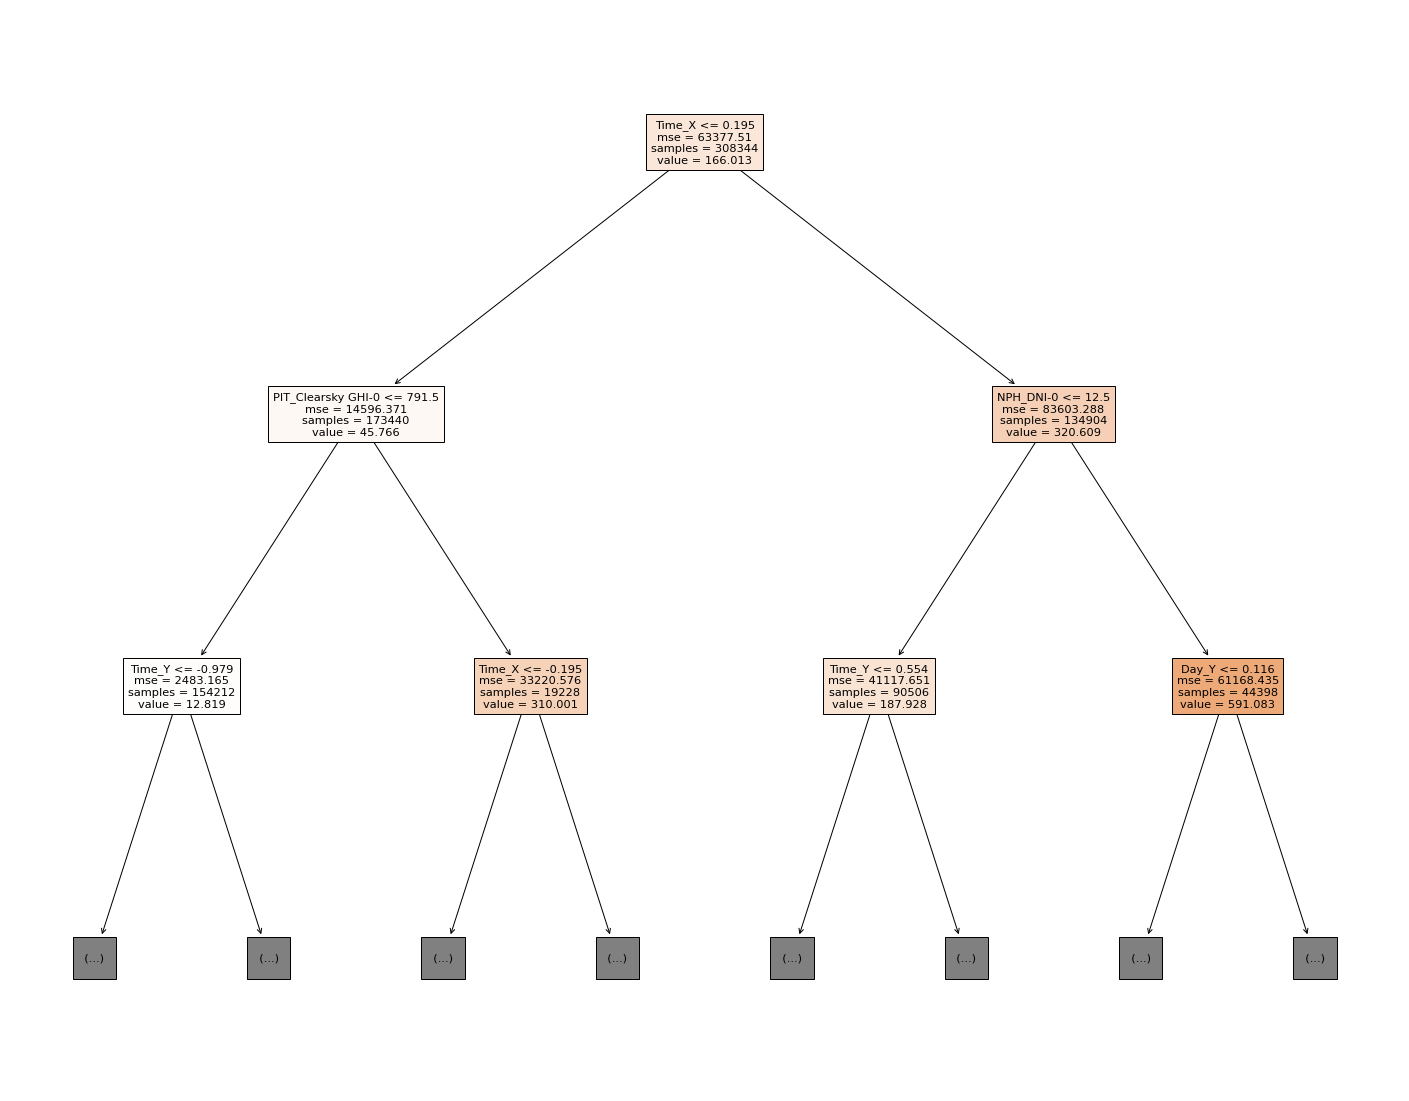

In [104]:
# Create and fit a OPTIMAL model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_and_previous_train_val, y_current_and_previous_train_val)

# evaluate model on test set
prediction = model.predict(X_current_and_previous_test)

actual = y_current_and_previous_test

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_train.columns, 
                   max_depth=2, 
                   filled=True)

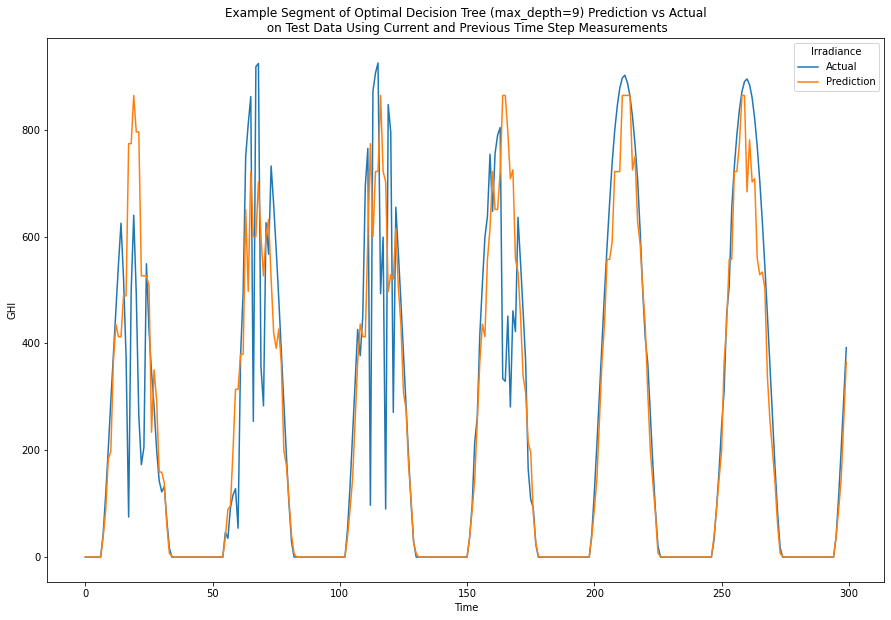

In [105]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Decision Tree (max_depth=9) Prediction vs Actual\n on Test Data Using Current and Previous Time Step Measurements')
plt.xlabel('Time')
plt.show()

## Current and Previous 3 Time Steps Data

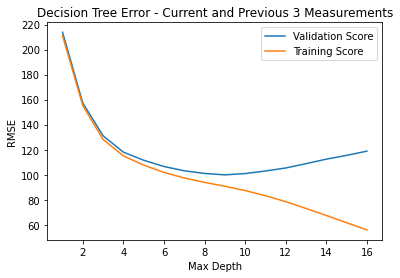

In [149]:
from sklearn.tree import DecisionTreeRegressor

val_scores = []
train_scores = []
max_depths = range(1, 17)

for d in max_depths:

    model = DecisionTreeRegressor(max_depth=d, random_state=15217)
    model.fit(X_current_and_previous_3_train, y_current_and_previous_3_train)
    
    val_prediction = model.predict(X_current_and_previous_3_val)
    val_actual = y_current_and_previous_3_val
    val_scores.append(mean_squared_error(val_actual, val_prediction, squared=False))
    
    train_prediction = model.predict(X_current_and_previous_3_train)
    train_actual = y_current_and_previous_3_train
    train_scores.append(mean_squared_error(train_actual, train_prediction, squared=False))

plt.plot(max_depths, val_scores, label='Validation Score')
plt.plot(max_depths, train_scores, label='Training Score')

plt.legend()
plt.title('Decision Tree Error - Current and Previous 3 Measurements')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()



### Show how shallow, deep, and optimal trees fit the model



RMSE:
131.04840799231013


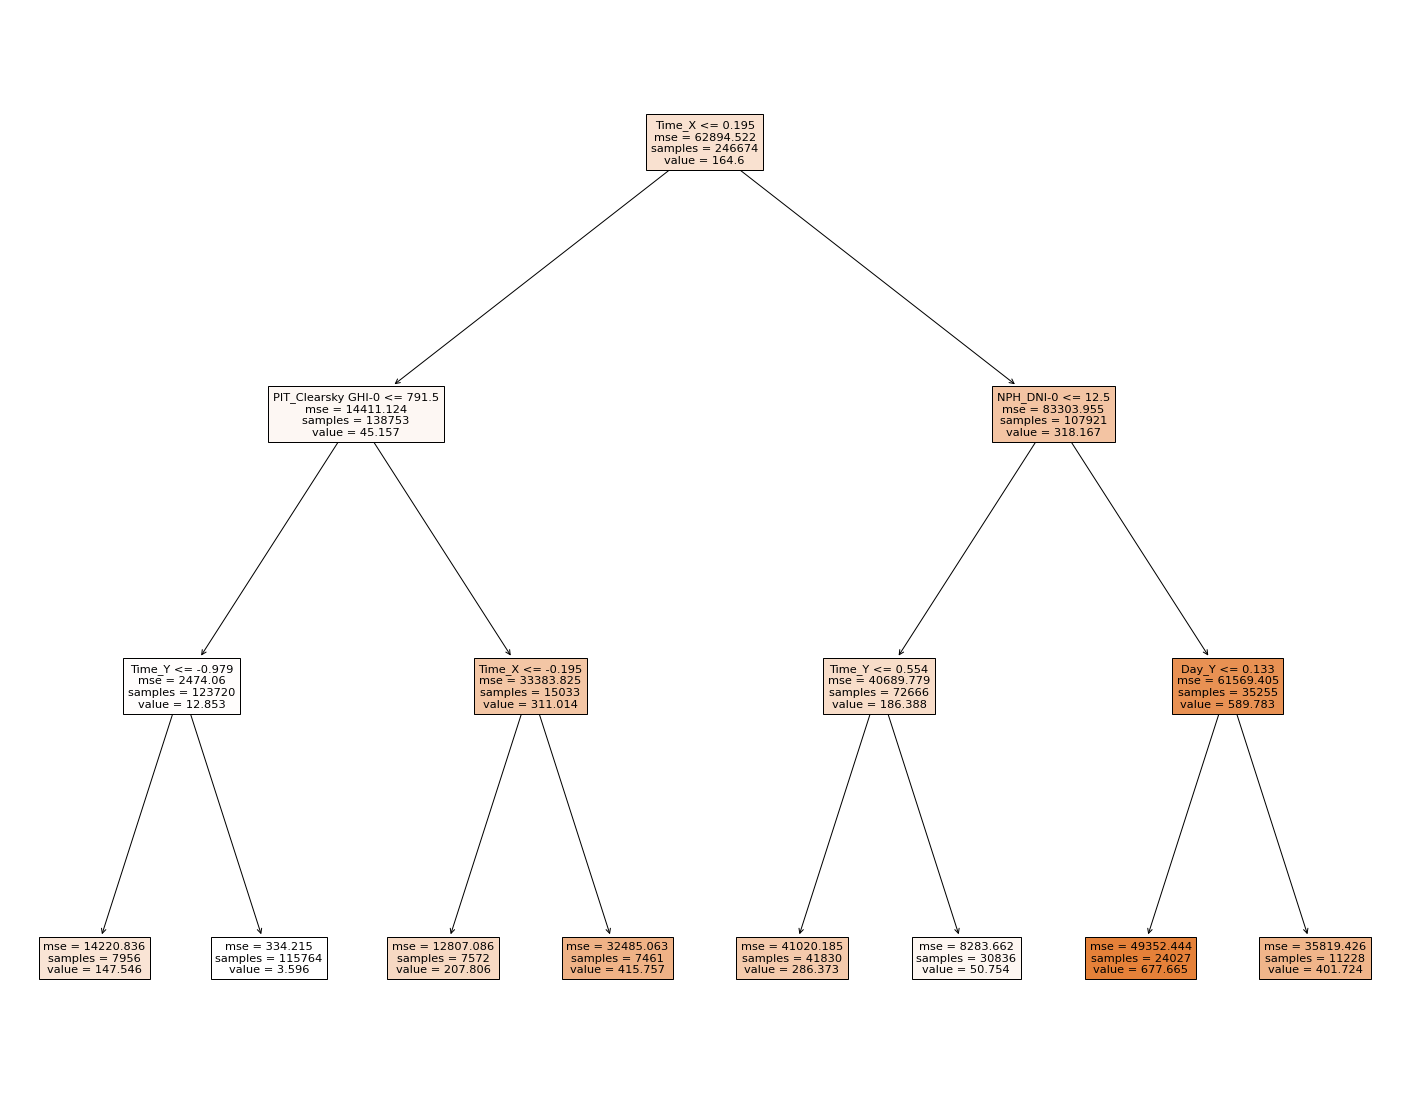

In [107]:
# Create and fit a SHALLOW model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=3 , random_state=15217)
model.fit(X_current_and_previous_3_train, y_current_and_previous_3_train)

# evaluate model on val set
prediction = model.predict(X_current_and_previous_3_val)

actual = y_current_and_previous_3_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_3_train.columns, 
                   max_depth=3, 
                   filled=True)

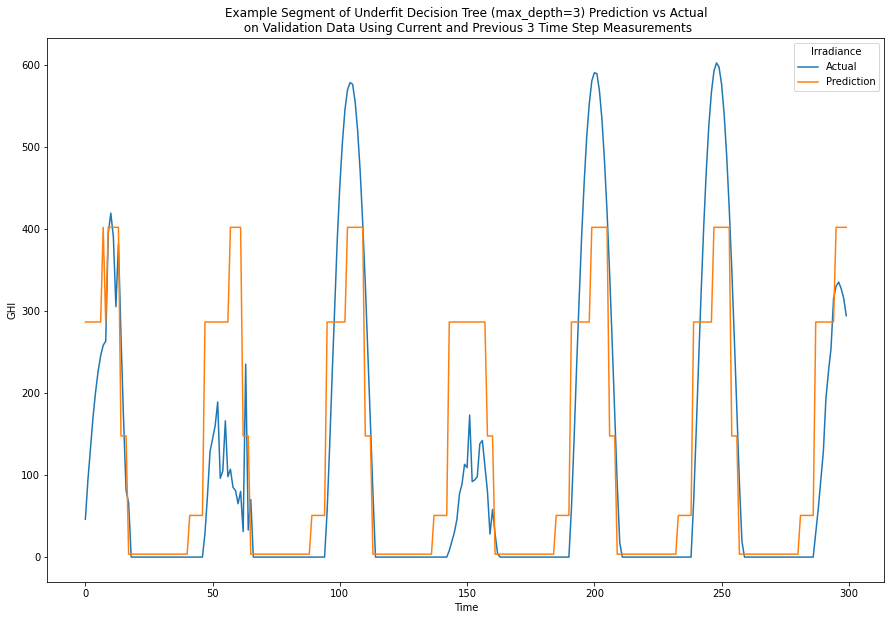

In [108]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Underfit Decision Tree (max_depth=3) Prediction vs Actual\n on Validation Data Using Current and Previous 3 Time Step Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
99.8670419183064


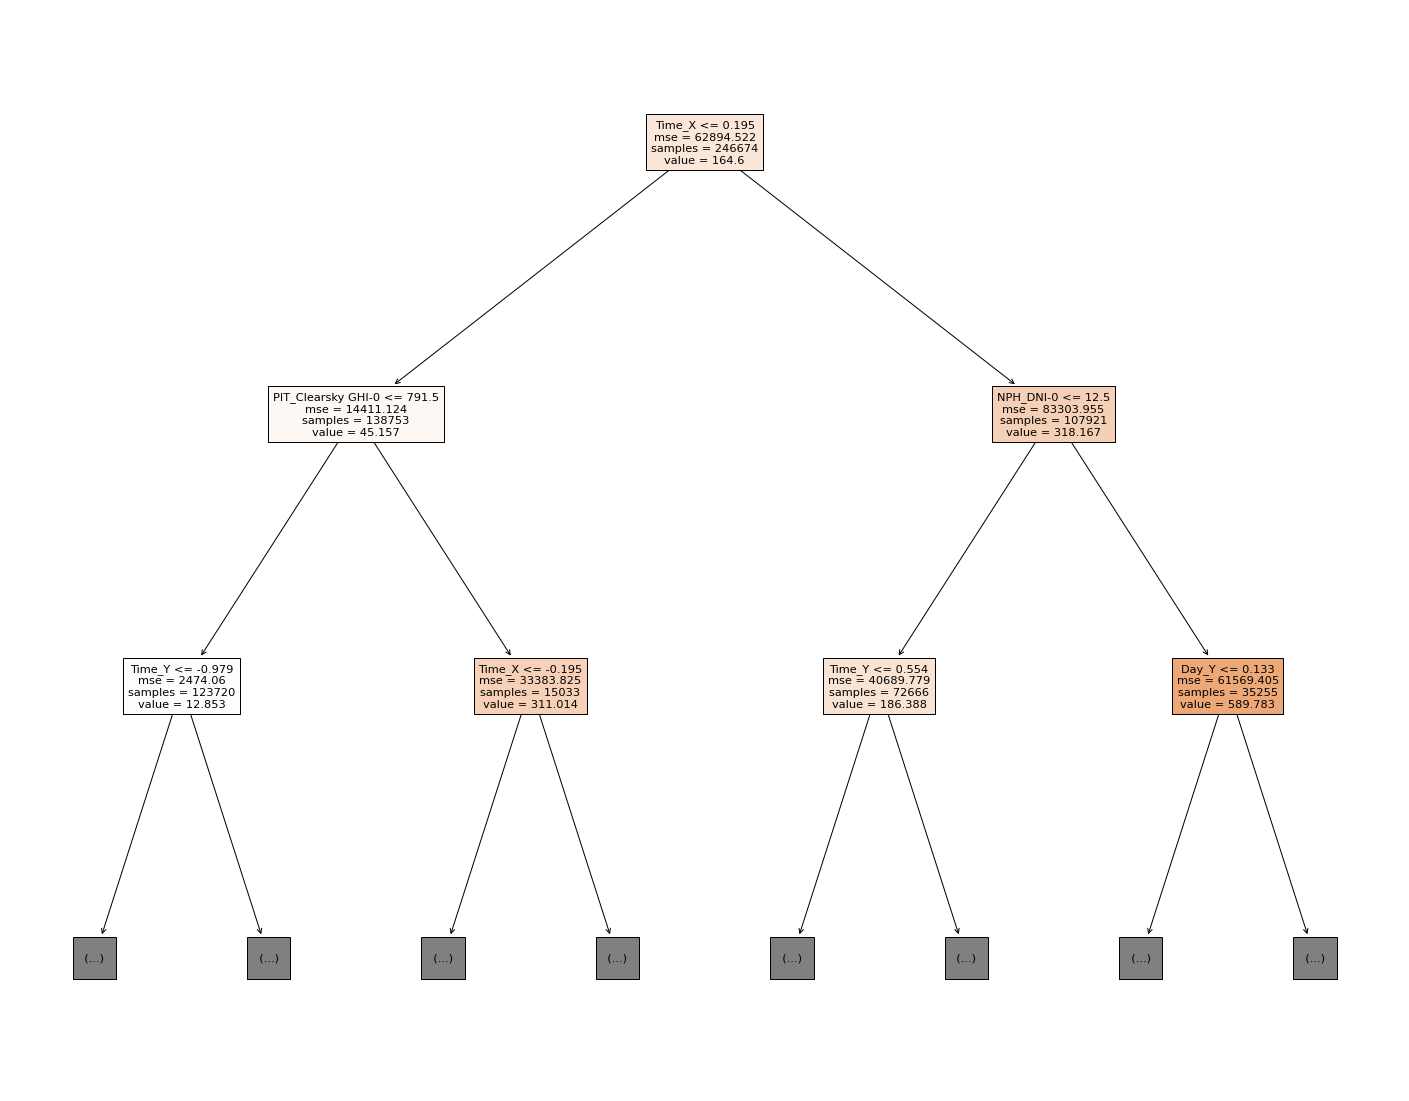

In [109]:
# Create and fit a OPTIMAL model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_and_previous_3_train, y_current_and_previous_3_train)

# evaluate model on val set
prediction = model.predict(X_current_and_previous_3_val)

actual = y_current_and_previous_3_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_3_train.columns, 
                   max_depth=2, 
                   filled=True)

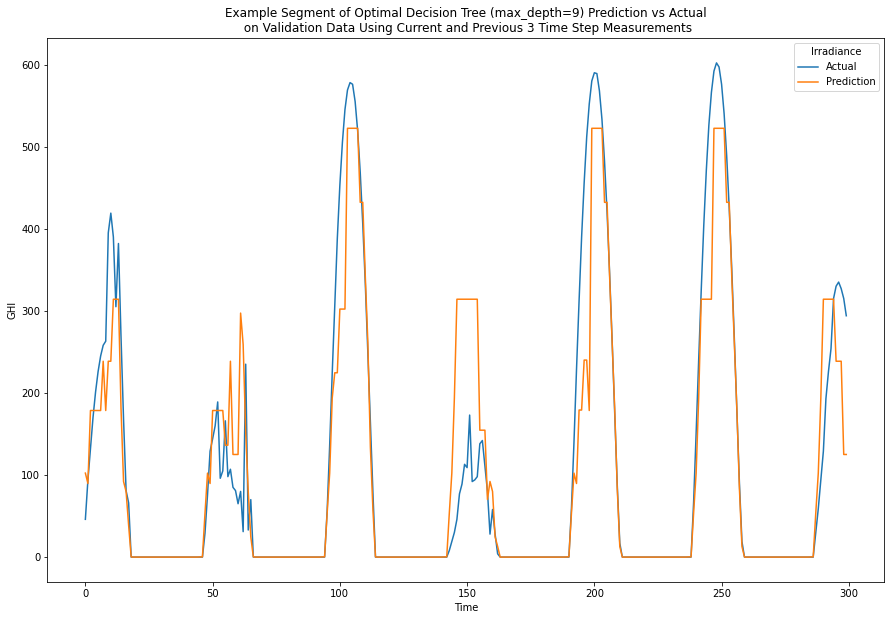

In [110]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Decision Tree (max_depth=9) Prediction vs Actual\n on Validation Data Using Current and Previous 3 Time Step Measurements')
plt.xlabel('Time')
plt.show()


RMSE:
118.80542639932949


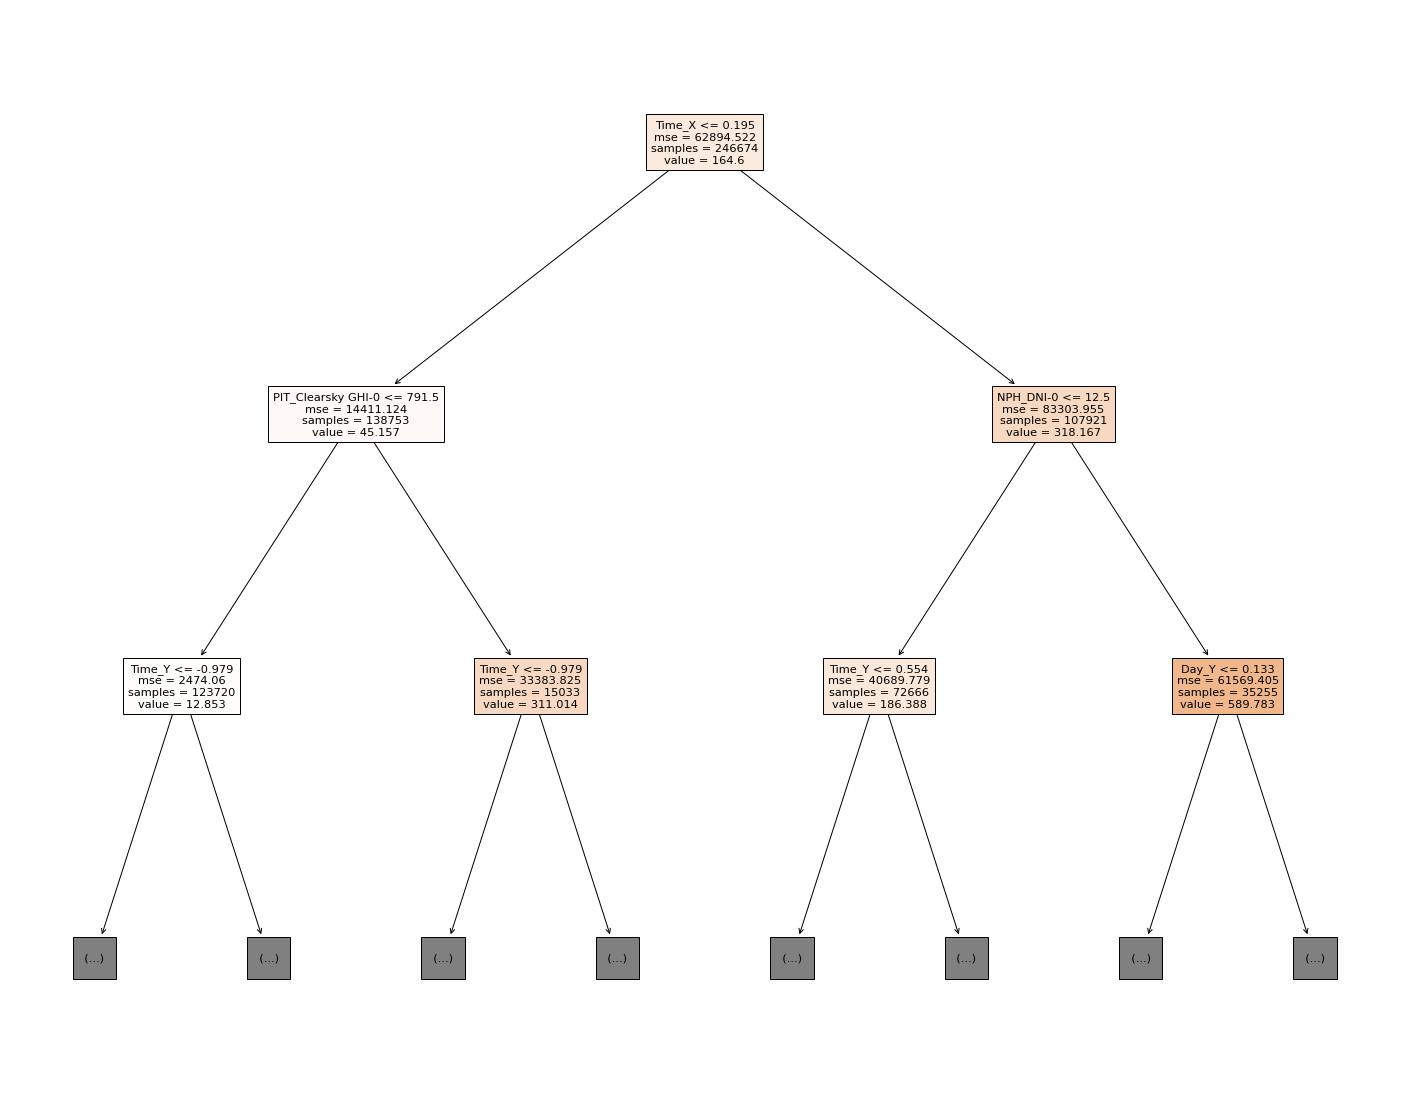

In [111]:
# Create and fit a Overfit model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=16 , random_state=15217)
model.fit(X_current_and_previous_3_train, y_current_and_previous_3_train)

# evaluate model on val set
prediction = model.predict(X_current_and_previous_3_val)

actual = y_current_and_previous_3_val

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_3_train.columns, 
                   max_depth=2, 
                   filled=True)

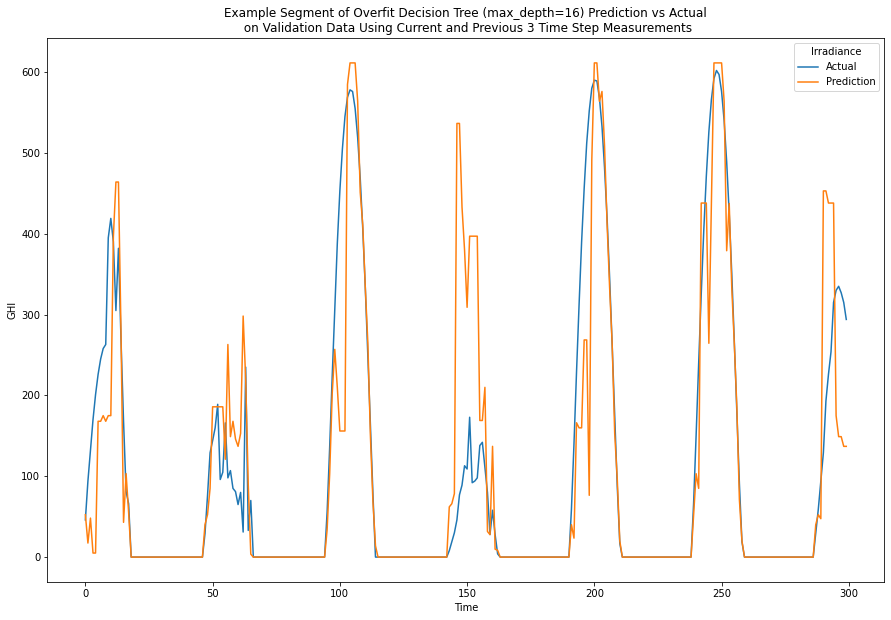

In [112]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Overfit Decision Tree (max_depth=16) Prediction vs Actual\n on Validation Data Using Current and Previous 3 Time Step Measurements')
plt.xlabel('Time')
plt.show()

### Optimal model for current measurements only, fit on train_val set


RMSE:
98.27322886122055


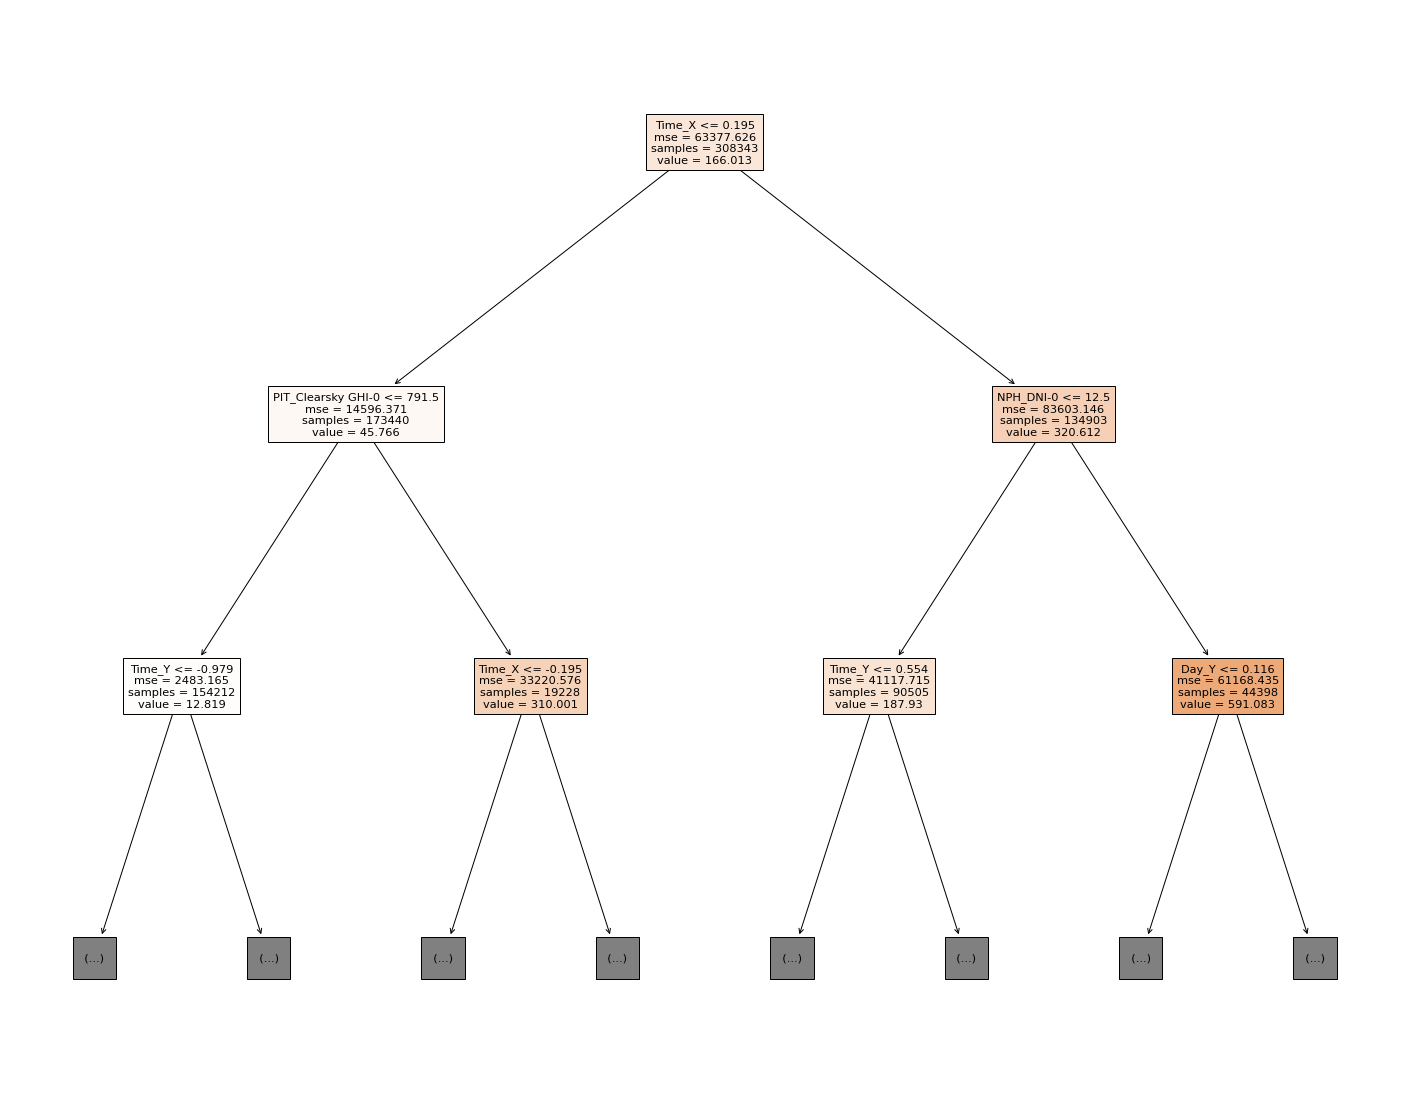

In [113]:
# Create and fit a OPTIMAL model
from sklearn import tree

model = DecisionTreeRegressor(max_depth=9 , random_state=15217)
model.fit(X_current_and_previous_3_train_val, y_current_and_previous_3_train_val)

# evaluate model on test set
prediction = model.predict(X_current_and_previous_3_test)

actual = y_current_and_previous_3_test

rmse = mean_squared_error(actual, prediction, squared=False)
print('\nRMSE:')
print(rmse)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X_current_and_previous_3_train.columns, 
                   max_depth=2, 
                   filled=True)

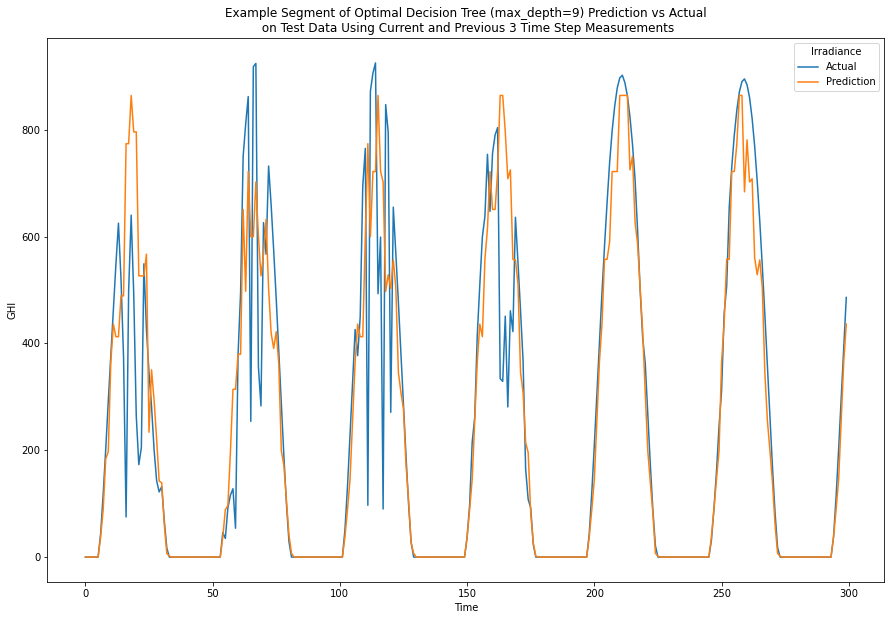

In [114]:
plot_df = pd.DataFrame({'Actual' : actual.to_numpy()[100:400,0], 'Prediction' : prediction[100:400]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.title('Example Segment of Optimal Decision Tree (max_depth=9) Prediction vs Actual\n on Test Data Using Current and Previous 3 Time Step Measurements')
plt.xlabel('Time')
plt.show()

# Neural Networks

## Current Measurements Only

[93.88746402842406, 98.49975065059641, 94.76031972161084, 94.20548272782906, 95.0439308950617]
2
[93.13176224764479, 93.03163170826375, 92.65640049331104, 92.66402091213328, 92.52803468771835]
3
[92.18182519268004, 92.03711458527106, 92.0986788241885, 92.9168287333416, 91.96334380548943]
4
[92.38059528784437, 91.29728605144567, 91.76312690201728, 91.45529704146841, 92.7493052371903]
5
[91.70152425715175, 91.65789975472597, 91.56518064607374, 91.7372682755264, 92.19632831646318]
6
[91.39464408277904, 92.3178369062737, 92.91028311048365, 91.2893369638184, 91.55378322276782]
7
[92.26857031958018, 91.67892190346457, 91.87683784590087, 92.70513135467105, 93.18366660696208]
8
[91.80468931028823, 93.18819770394693, 92.24195238087727, 92.04683967000996, 92.053084978638]
9
[91.52189183648329, 91.93021243288646, 93.03974748512286, 91.96539289908893, 92.03891391813161]
10


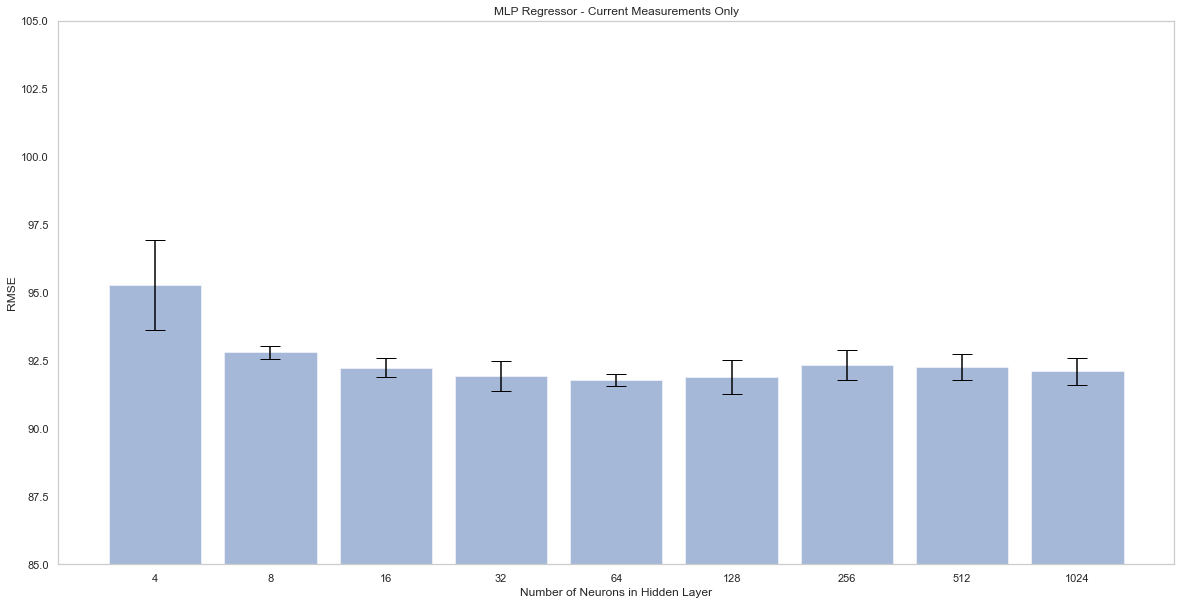

In [497]:
from sklearn.neural_network import MLPRegressor

scores_mean = []
scores_error = []
num_neurons = range(2,11)
labels = []
all_scores = []
all_labels = []

for n in num_neurons:
    scores = []
    for i in range(5):
        model = MLPRegressor(hidden_layer_sizes = (2**n), n_iter_no_change=5, early_stopping=True)
        model.fit(X_current_only_train_norm, y_current_only_train_norm.ravel())

        prediction = model.predict(X_current_only_val_norm)
        prediction = y_current_only_train_scaler.inverse_transform(prediction.reshape(-1,1))
        actual = y_current_only_val
        scores.append(mean_squared_error(actual, prediction, squared=False))
        all_scores.append(mean_squared_error(actual, prediction, squared=False))
        all_labels.append("{hidden_neurons}".format(hidden_neurons=hidden_neurons))
    print(scores)
    scores_mean.append(np.mean(scores))
    scores_error.append(np.std(scores))
    hidden_neurons = 2**n
    labels.append("{hidden_neurons}".format(hidden_neurons=hidden_neurons))
    print(n)
fig = plt.figure(figsize=(20,10))

plt.title('MLP Regressor - Current Measurements Only')
plt.xlabel('Number of Neurons in Hidden Layer')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.bar(labels, scores_mean, yerr=scores_error, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylim(85, 105) 
plt.show()



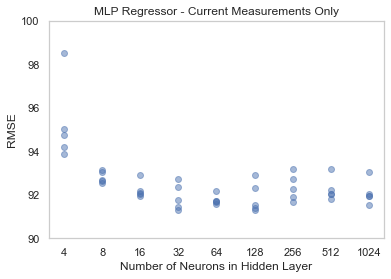

In [498]:
plt.title('MLP Regressor - Current Measurements Only')
plt.xlabel('Number of Neurons in Hidden Layer')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.scatter(all_labels, all_scores, alpha=0.5)
plt.ylim(90, 100) 
plt.show()

In [427]:
import random

rows_list=[]

for i in range(30):
    
    print(i)
    
    hidden_neurons_exp = random.uniform(3,8)
    hidden_neurons = round(2**hidden_neurons_exp)

    alpha_exp = random.uniform(-6, -2)
    alpha = 10**alpha_exp

    batch_size_exp = random.uniform(0, 10)
    batch_size = round(2**batch_size_exp)

    learning_rate_init_exp = random.uniform(-5,-1)
    learning_rate_init = 10**learning_rate_init_exp
    
    print('\nhidden neurons:')
    print(hidden_neurons)
    print('\nalpha:')
    print(alpha)
    print('\nbatch size:')
    print(batch_size)
    print('\nlearning rate init:')
    print(learning_rate_init)

    model = MLPRegressor(hidden_layer_sizes = hidden_neurons, 
                         alpha = alpha,
                         batch_size = batch_size,
                         learning_rate_init = learning_rate_init,
                         n_iter_no_change=5,
                         early_stopping=True)

    model.fit(X_current_only_train_norm, y_current_only_train_norm.ravel())

    prediction = model.predict(X_current_only_val_norm)
    prediction = y_current_only_train_scaler.inverse_transform(prediction.reshape(-1,1))
    actual = y_current_only_val
    score = mean_squared_error(actual, prediction, squared=False)
    
    row_dict = {
        'Score' : score,
        'Hidden Neurons' : hidden_neurons,
        'Alpha' : alpha,
        'Batch Size' : batch_size,
        'Learning Rate Init' : learning_rate_init
    }
    
    rows_list.append(row_dict)

hp_df = pd.DataFrame(rows_list)



0

hidden neurons:
70

alpha:
0.009006895549065603

batch size:
214

learning rate init:
0.03344737372318769
1

hidden neurons:
69

alpha:
8.71919364049443e-05

batch size:
2

learning rate init:
0.00011076444409184034
2

hidden neurons:
136

alpha:
0.007249340354562768

batch size:
219

learning rate init:
0.005090604670642952
3

hidden neurons:
27

alpha:
0.0003097779784022513

batch size:
75

learning rate init:
0.0087056373863288
4

hidden neurons:
146

alpha:
2.9155550839827927e-06

batch size:
23

learning rate init:
0.042604693657079765
5

hidden neurons:
176

alpha:
0.0020271633046928463

batch size:
50

learning rate init:
4.114670898600352e-05
6

hidden neurons:
75

alpha:
4.143105795709578e-06

batch size:
180

learning rate init:
0.0012162467688960434
7

hidden neurons:
93

alpha:
3.1658738302141293e-06

batch size:
3

learning rate init:
0.0015841759840064362
8

hidden neurons:
100

alpha:
0.000839705869697952

batch size:
25

learning rate init:
1.0889297397258326e-05
9



In [513]:
hp_df.sort_values(by='Score').head()

Score  Hidden Neurons     Alpha  Batch Size  Learning Rate Init
6   90.989828              75  0.000004         180            0.001216
16  91.168113              25  0.000005         506            0.003584
13  91.370369             138  0.000003          21            0.001058
1   91.466599              69  0.000087           2            0.000111
11  91.519289              21  0.000023         161            0.002424

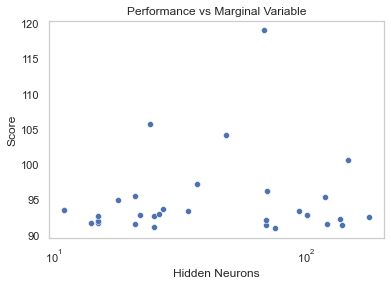

In [473]:
p = sns.scatterplot(x='Hidden Neurons', y='Score', data=hp_df)
plt.title("Performance vs Marginal Variable")
p.set(xscale="log")

plt.show()

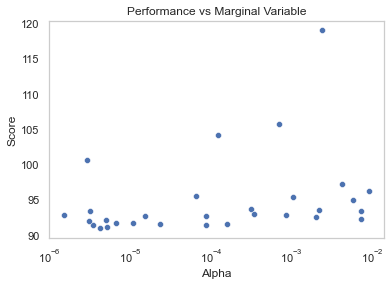

In [474]:
p = sns.scatterplot(x='Alpha', y='Score', data=hp_df)
plt.title("Performance vs Marginal Variable")
p.set(xscale="log")

plt.show()

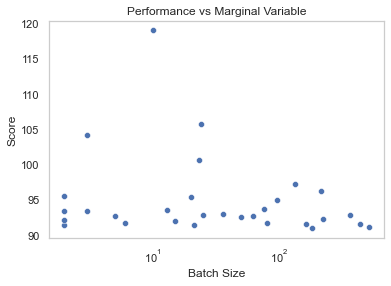

In [475]:
p = sns.scatterplot(x='Batch Size', y='Score', data=hp_df)
plt.title("Performance vs Marginal Variable")
p.set(xscale="log")

plt.show()

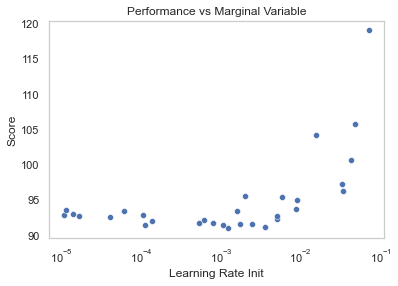

In [476]:
p = sns.scatterplot(x='Learning Rate Init', y='Score', data=hp_df)
plt.title("Performance vs Marginal Variable")
p.set(xscale="log")

plt.show()

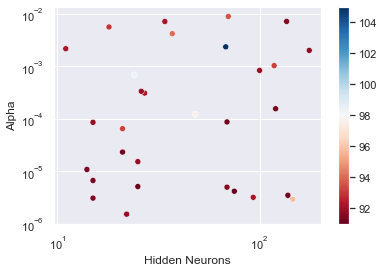

In [448]:
sns.set()
ax = sns.scatterplot(x="Hidden Neurons", y="Alpha", hue="Score", palette='RdBu', data=hp_df)
ax.set(xscale='log', yscale='log')
norm = plt.Normalize(hp_df['Score'].min(), 105)
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

In [516]:
rows_list=[]

for i in range(30):
    
    print(i)
    
    hidden_neurons_exp = random.uniform(3,8)
    hidden_neurons = round(2**hidden_neurons_exp)

    alpha_exp = random.uniform(-6, -2)
    alpha = 10**alpha_exp

    batch_size_exp = random.uniform(4, 10)
    batch_size = round(2**batch_size_exp)

    learning_rate_init_exp = random.uniform(-5,-1)
    learning_rate_init = 10**learning_rate_init_exp
    
    print('\nhidden neurons:')
    print(hidden_neurons)
    print('\nalpha:')
    print(alpha)
    print('\nbatch size:')
    print(batch_size)
    print('\nlearning rate init:')
    print(learning_rate_init)

    model = MLPRegressor(hidden_layer_sizes = (hidden_neurons,1), 
                         alpha = alpha,
                         batch_size = batch_size,
                         learning_rate_init = learning_rate_init,
                         n_iter_no_change=5,
                         early_stopping=True)

    model.fit(X_current_only_train_norm, y_current_only_train_norm.ravel())

    prediction = model.predict(X_current_only_val_norm)
    prediction = y_current_only_train_scaler.inverse_transform(prediction.reshape(-1,1))
    actual = y_current_only_val
    score = mean_squared_error(actual, prediction, squared=False)
    
    row_dict = {
        'Score' : score,
        'Hidden Neurons' : hidden_neurons,
        'Alpha' : alpha,
        'Batch Size' : batch_size,
        'Learning Rate Init' : learning_rate_init
    }
    
    rows_list.append(row_dict)

hp_current_only_df = pd.DataFrame(rows_list)


0

hidden neurons:
17

alpha:
0.0007536357664304658

batch size:
49

learning rate init:
0.0020339756318666045
1

hidden neurons:
15

alpha:
0.001837344098432478

batch size:
60

learning rate init:
0.012611523615032056
2

hidden neurons:
20

alpha:
0.008934798097594825

batch size:
22

learning rate init:
0.00041312469837691187
3

hidden neurons:
12

alpha:
0.0004825036058167709

batch size:
597

learning rate init:
0.017095085724183834
4

hidden neurons:
195

alpha:
0.00012078115056266244

batch size:
103

learning rate init:
0.02751350460343624
5

hidden neurons:
148

alpha:
0.00014438685220927733

batch size:
529

learning rate init:
0.00014775555275855324
6

hidden neurons:
50

alpha:
0.009814268341870564

batch size:
207

learning rate init:
2.116130768006323e-05
7

hidden neurons:
12

alpha:
7.180333391968374e-06

batch size:
33

learning rate init:
4.457252865041726e-05
8

hidden neurons:
144

alpha:
0.00024207946421951515

batch size:
24

learning rate init:
0.0024237443771114

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


13

hidden neurons:
42

alpha:
0.0002983282561627116

batch size:
19

learning rate init:
0.002651165380300932
14

hidden neurons:
13

alpha:
3.603854855371675e-05

batch size:
405

learning rate init:
0.00010844308511332316
15

hidden neurons:
252

alpha:
3.3543879789046486e-05

batch size:
50

learning rate init:
0.01751450332758001
16

hidden neurons:
14

alpha:
0.0005700892511304202

batch size:
50

learning rate init:
0.04482416377017904
17

hidden neurons:
149

alpha:
0.0007346799970964415

batch size:
661

learning rate init:
4.1477148178995925e-05
18

hidden neurons:
24

alpha:
0.00012149787715214858

batch size:
21

learning rate init:
0.00015122562753480036
19

hidden neurons:
230

alpha:
0.0015879477746371486

batch size:
51

learning rate init:
0.021783188468158243
20

hidden neurons:
24

alpha:
0.0008542368403485802

batch size:
811

learning rate init:
0.0002485353590425741
21

hidden neurons:
21

alpha:
0.00024906396060293357

batch size:
668

learning rate init:
4.55228

/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


22

hidden neurons:
53

alpha:
0.00018332823891434484

batch size:
495

learning rate init:
0.00015311562832567868
23

hidden neurons:
37

alpha:
4.237914841149774e-05

batch size:
322

learning rate init:
0.005138086385416937
24

hidden neurons:
231

alpha:
0.001315182182780507

batch size:
68

learning rate init:
0.000139889359907212
25

hidden neurons:
97

alpha:
0.0005007652320969447

batch size:
499

learning rate init:
0.005942840833687454
26

hidden neurons:
78

alpha:
1.549037971541672e-05

batch size:
808

learning rate init:
3.933314883616127e-05


/Users/john/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


27

hidden neurons:
40

alpha:
0.0030052527143250435

batch size:
609

learning rate init:
8.089840427459366e-05
28

hidden neurons:
16

alpha:
0.0038921748572133957

batch size:
154

learning rate init:
0.09753181973671562
29

hidden neurons:
109

alpha:
1.5149266561446217e-05

batch size:
372

learning rate init:
0.09396680849470156


In [523]:
hp_current_only_df.sort_values(by='Score')

Score  Hidden Neurons     Alpha  Batch Size  Learning Rate Init
0    91.501817              17  0.000754          49            0.002034
2    91.559219              20  0.008935          22            0.000413
25   91.566337              97  0.000501         499            0.005943
17   91.664126             149  0.000735         661            0.000041
23   91.727413              37  0.000042         322            0.005138
3    91.885144              12  0.000483         597            0.017095
18   92.195898              24  0.000121          21            0.000151
7    92.289824              12  0.000007          33            0.000045
10   92.301889              20  0.004420          83            0.000326
24   92.341892             231  0.001315          68            0.000140
22   92.651755              53  0.000183         495            0.000153
8    92.962670             144  0.000242          24            0.002424
27   92.988007              40  0.003005         609            0.000081
14   93.252108              13  0.000036         405            0.000108
13   93.260805              42  0.000298          19            0.002651
5    93.285797             148  0.000144         529            0.000148
20   93.382219              24  0.000854         811            0.000249
6    93.515268              50  0.009814         207            0.000021
4    93.939303             195  0.000121         103            0.027514
12   94.470348              11  0.009845         559            0.000053
1    94.707781              15  0.001837          60            0.012612
21   94.820271              21  0.000249         668            0.000046
16   99.498008              14  0.000570          50            0.044824
26  144.162822              78  0.000015         808            0.000039
28  255.482896              16  0.003892         154            0.097532
29  255.514396             109  0.000015         372            0.093967
15  255.540787             252  0.000034          50            0.017515
11  255.556058              27  0.001656         133            0.081699
9   255.560393             106  0.000002         133            0.055090
19  255.762394             230  0.001588          51            0.021783

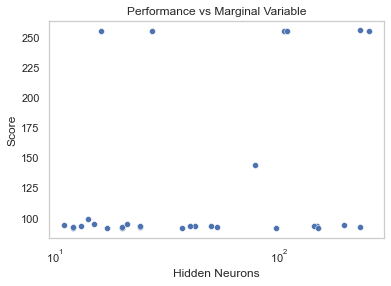

In [519]:
p = sns.scatterplot(x='Hidden Neurons', y='Score', data=hp_current_only_df)
plt.title("Performance vs Marginal Variable")
p.set(xscale="log")

plt.show()

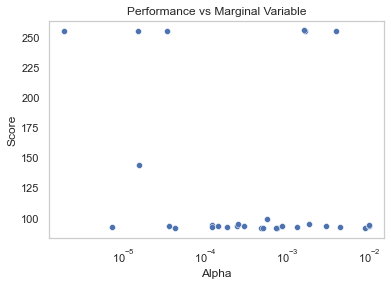

In [520]:
p = sns.scatterplot(x='Alpha', y='Score', data=hp_current_only_df)
plt.title("Performance vs Marginal Variable")
p.set(xscale="log")

plt.show()

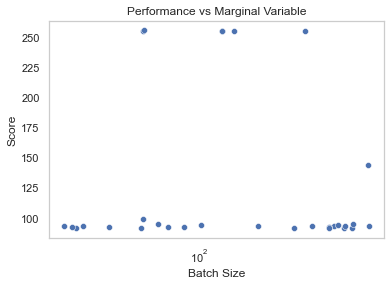

In [521]:
p = sns.scatterplot(x='Batch Size', y='Score', data=hp_current_only_df)
plt.title("Performance vs Marginal Variable")
p.set(xscale="log")

plt.show()

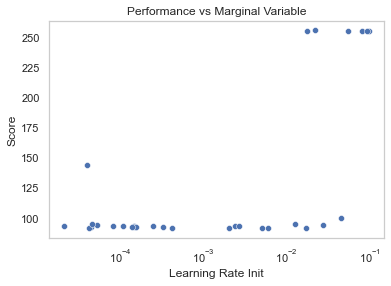

In [522]:
p = sns.scatterplot(x='Learning Rate Init', y='Score', data=hp_current_only_df)
plt.title("Performance vs Marginal Variable")
p.set(xscale="log")

plt.show()

In [45]:
# Create and fit a MLP Regressor. Use combined training and validation dataset.
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
model = MLPRegressor(random_state = 15217, 
                     hidden_layer_sizes = (75,1), 
                     alpha = 0.000004,
                     batch_size = 180,
                     learning_rate_init = 0.001,
                     early_stopping=True, 
                     n_iter_no_change = 5)

model.fit(X_current_only_train_val_norm, y_current_only_train_val_norm.ravel())

# evaluate model on test set
prediction = model.predict(X_current_only_test_norm)
prediction = y_current_only_train_val_scaler.inverse_transform(prediction.reshape(-1,1))
actual = y_current_only_test.to_numpy()

best_current_only_mlpr_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_only_mlpr_rmse


89.30437549108734

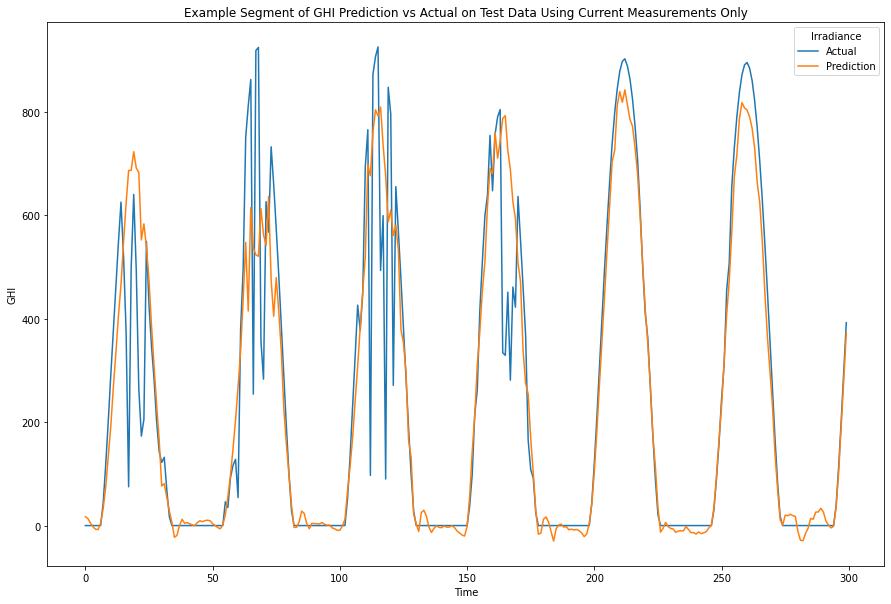

In [46]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.xlabel('Time')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current Measurements Only')
plt.show()

## Current and previous

[93.32682387410601, 94.01115745336533, 92.81657215747644, 94.52229326107737, 95.80565605623524]
2
[92.31178813901931, 92.82733446779984, 92.52739942302742, 92.5410046144206, 91.90518275458541]
3
[92.08111311295573, 92.0635679524069, 92.9936959420138, 92.24565242586029, 92.33364517091178]
4
[92.96974019804983, 92.04022459697933, 91.66400695616153, 91.73502973935922, 91.6098174235838]
5
[92.06005958765631, 91.53998740134672, 92.54572497817735, 92.539692277366, 91.985177395821]
6
[92.16902773400575, 92.88734539205136, 92.2140251602325, 92.70768206224591, 92.62226678705095]
7
[91.92241882142214, 93.01692927623535, 92.73455156756614, 92.19975916181954, 92.65222601394284]
8
[91.59077112192756, 91.94330506422443, 91.79781698484327, 91.92375704079107, 92.83876852125749]
9
[92.10249906673249, 91.91952850188008, 92.48348216612371, 92.37923290950596, 91.99514296783478]
10


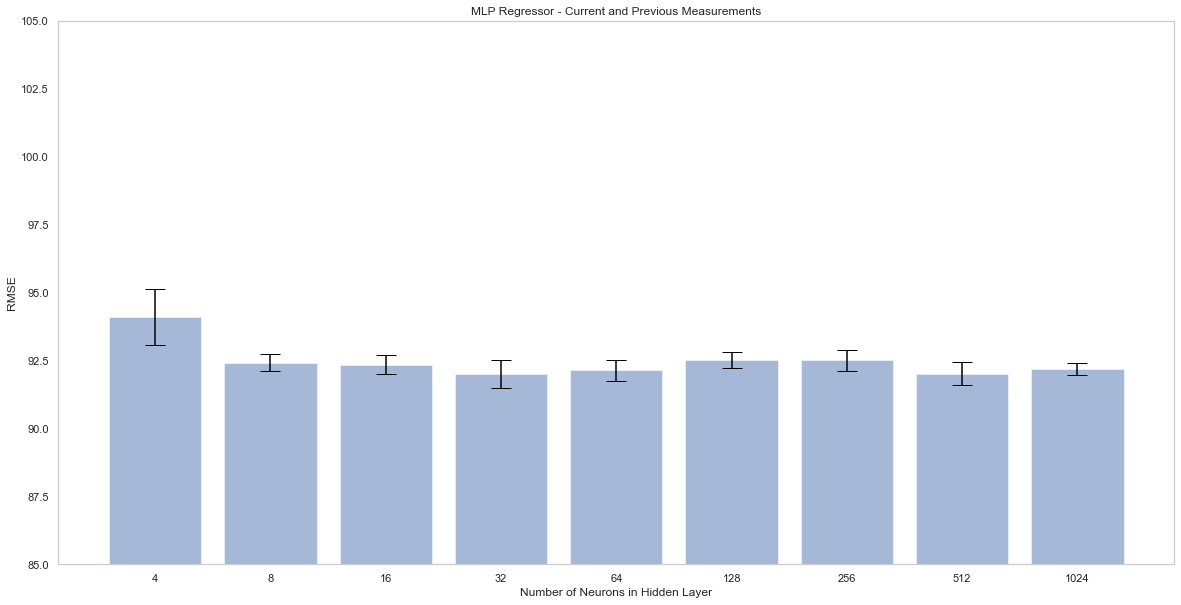

In [480]:
from sklearn.neural_network import MLPRegressor

scores_mean = []
scores_error = []
num_neurons = range(2,11)
labels = []
all_scores = []
all_labels = []
for n in num_neurons:
    scores = []
    for i in range(5):
        model = MLPRegressor(hidden_layer_sizes = (2**n), n_iter_no_change=5, early_stopping=True)
        model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm.ravel())

        prediction = model.predict(X_current_and_previous_val_norm)
        prediction = y_current_and_previous_train_scaler.inverse_transform(prediction.reshape(-1,1))
        actual = y_current_and_previous_val
        scores.append(mean_squared_error(actual, prediction, squared=False))
        all_scores.append(mean_squared_error(actual, prediction, squared=False))
        all_labels.append("{hidden_neurons}".format(hidden_neurons=hidden_neurons))
    print(scores)
    scores_mean.append(np.mean(scores))
    scores_error.append(np.std(scores))
    hidden_neurons = 2**n
    labels.append("{hidden_neurons}".format(hidden_neurons=hidden_neurons))
    print(n)
fig = plt.figure(figsize=(20,10))

plt.title('MLP Regressor - Current and Previous Measurements')
plt.xlabel('Number of Neurons in Hidden Layer')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.bar(labels, scores_mean, yerr=scores_error, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylim(85, 105) 
plt.show()



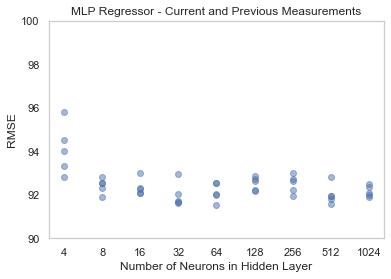

In [496]:
plt.title('MLP Regressor - Current and Previous Measurements')
plt.xlabel('Number of Neurons in Hidden Layer')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.scatter(all_labels, all_scores, alpha=0.5)
plt.ylim(90, 100) 
plt.show()

In [499]:
rows_list=[]

for i in range(20):
    
    print(i)
    
    hidden_neurons_exp = random.uniform(3,9)
    hidden_neurons = round(2**hidden_neurons_exp)

    alpha_exp = random.uniform(-8, -3)
    alpha = 10**alpha_exp

    print('\nhidden neurons:')
    print(hidden_neurons)
    print('\nalpha:')
    print(alpha)

    model = MLPRegressor(hidden_layer_sizes = hidden_neurons, 
                         alpha = alpha,
                         batch_size = 180,
                         learning_rate_init = 0.001,
                         n_iter_no_change=5,
                         early_stopping=True)

    model.fit(X_current_and_previous_train_norm, y_current_and_previous_train_norm.ravel())

    prediction = model.predict(X_current_and_previous_val_norm)
    prediction = y_current_and_previous_train_scaler.inverse_transform(prediction.reshape(-1,1))
    actual = y_current_and_previous_val
    score = mean_squared_error(actual, prediction, squared=False)
    
    row_dict = {
        'Score' : score,
        'Hidden Neurons' : hidden_neurons,
        'Alpha' : alpha,
    }
    
    
    rows_list.append(row_dict)

hp_current_and_previous_df = pd.DataFrame(rows_list)



0

hidden neurons:
207

alpha:
1.0691124130638238e-06
1

hidden neurons:
17

alpha:
1.2682002502184727e-06
2

hidden neurons:
12

alpha:
0.0006930830631935622
3

hidden neurons:
63

alpha:
4.2289030368458365e-08
4

hidden neurons:
153

alpha:
8.49014068570657e-07
5

hidden neurons:
507

alpha:
6.806174003480577e-05
6

hidden neurons:
82

alpha:
1.3889069512690529e-08
7

hidden neurons:
52

alpha:
2.9357684318715e-07
8

hidden neurons:
224

alpha:
5.960058552465095e-06
9

hidden neurons:
16

alpha:
8.364248602888726e-05
10

hidden neurons:
14

alpha:
8.607389195181209e-07
11

hidden neurons:
35

alpha:
0.00011839647468803639
12

hidden neurons:
18

alpha:
3.1446626280616522e-06
13

hidden neurons:
451

alpha:
1.6531657734832207e-05
14

hidden neurons:
25

alpha:
7.867236544942348e-05
15

hidden neurons:
77

alpha:
6.181834280538354e-08
16

hidden neurons:
64

alpha:
3.634241733420606e-08
17

hidden neurons:
32

alpha:
3.42416822296566e-06
18

hidden neurons:
281

alpha:
1.72069509734900

In [500]:
hp_current_and_previous_df.sort_values(by='Score')

Score  Hidden Neurons         Alpha
18  91.394505             281  1.720695e-07
4   91.491413             153  8.490141e-07
8   91.567841             224  5.960059e-06
7   91.640710              52  2.935768e-07
11  91.683367              35  1.183965e-04
16  91.690483              64  3.634242e-08
17  91.718391              32  3.424168e-06
14  91.757784              25  7.867237e-05
9   91.893263              16  8.364249e-05
1   91.919128              17  1.268200e-06
10  91.925262              14  8.607389e-07
5   91.932905             507  6.806174e-05
19  91.968986              55  2.380050e-04
15  92.091081              77  6.181834e-08
3   92.115719              63  4.228903e-08
6   92.157633              82  1.388907e-08
2   92.425639              12  6.930831e-04
13  92.448628             451  1.653166e-05
12  92.667755              18  3.144663e-06
0   93.166066             207  1.069112e-06

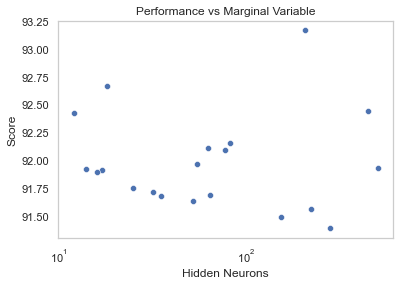

In [501]:
p = sns.scatterplot(x='Hidden Neurons', y='Score', data=hp_current_and_previous_df)
plt.title("Performance vs Marginal Variable")
p.set(xscale="log")

plt.show()

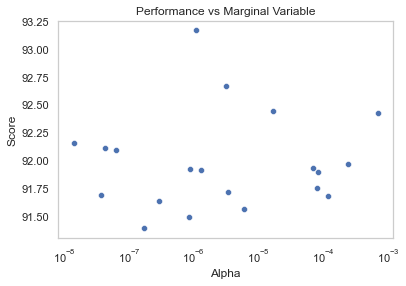

In [502]:
p = sns.scatterplot(x='Alpha', y='Score', data=hp_current_and_previous_df)
plt.title("Performance vs Marginal Variable")
p.set(xscale="log")

plt.show()

In [47]:
# Create and fit a MLP Regressor. Use combined training and validation dataset.

model = MLPRegressor(random_state = 15217, 
                     hidden_layer_sizes = 281, 
                     alpha = 0.00000017,
                     batch_size = 180,
                     learning_rate_init = 0.001,
                     early_stopping=True, 
                     n_iter_no_change = 5)

model.fit(X_current_and_previous_train_val_norm, y_current_and_previous_train_val_norm.ravel())

# evaluate model on test set
prediction = model.predict(X_current_and_previous_test_norm)
prediction = y_current_and_previous_train_val_scaler.inverse_transform(prediction.reshape(-1,1))
actual = y_current_and_previous_test.to_numpy()

best_current_and_previous_mlpr_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_and_previous_mlpr_rmse


90.84269451839769

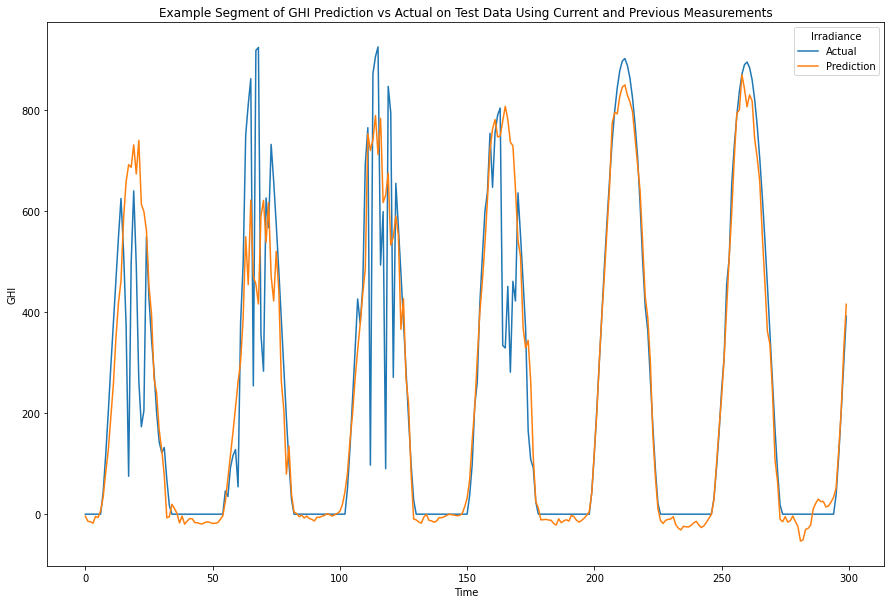

In [48]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.xlabel('Time')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current and Previous Measurements')
plt.show()

## Current and previous 3

[94.78910774716509, 93.69826015181113, 94.72598023024463, 94.17735036151771, 94.18428098374743]
2
[92.82074617475061, 92.96307887617868, 93.5437420096175, 93.10102201347044, 92.384706012831]
3
[92.0533611861987, 93.3482719290496, 93.05212560074126, 93.27175545601028, 93.5086214010835]
4
[91.82562386375982, 93.34864175684076, 92.17425381482487, 91.66152689065001, 92.0770008803234]
5
[92.36958928110546, 91.6667347397543, 92.52933984083958, 92.65998484758532, 93.32241891573811]
6
[92.0799384206531, 91.75924630135286, 92.2537448630904, 93.10525996791964, 92.77227126645269]
7
[92.94893225079802, 92.19576029144635, 91.51140866475828, 94.06600174233957, 93.74417651877052]
8
[93.04077481517025, 92.27955511790647, 92.51933686632219, 94.28714333793158, 91.98101684325617]
9
[91.93126842399818, 92.47609577240397, 92.52762827493584, 92.97146550975714, 93.41875730166551]
10


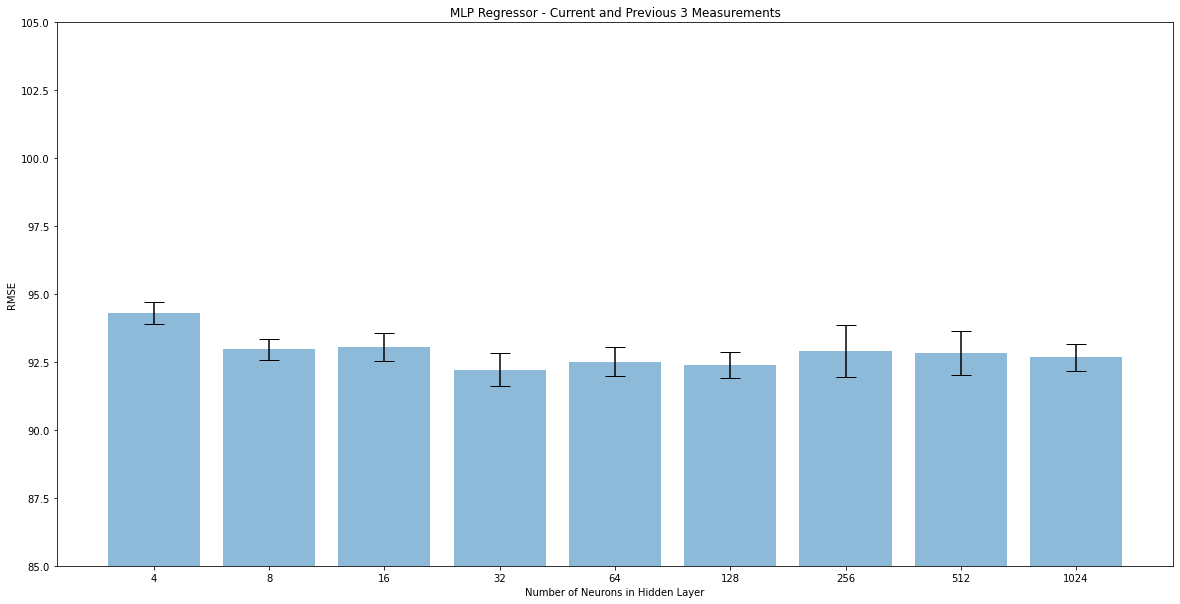

In [163]:
scores_mean = []
scores_error = []
num_neurons = range(2,11)
labels = []

for n in num_neurons:
    scores = []
    for i in range(5):
        model = MLPRegressor(hidden_layer_sizes = (2**n), n_iter_no_change=5, early_stopping=True)
        model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm.ravel())

        prediction = model.predict(X_current_and_previous_3_val_norm)
        prediction = y_current_and_previous_3_train_scaler.inverse_transform(prediction.reshape(-1,1))
        actual = y_current_and_previous_3_val
        scores.append(mean_squared_error(actual, prediction, squared=False))
    
    print(scores)
    scores_mean.append(np.mean(scores))
    scores_error.append(np.std(scores))
    hidden_neurons = 2**n
    labels.append("{hidden_neurons}".format(hidden_neurons=hidden_neurons))
    print(n)
fig = plt.figure(figsize=(20,10))

plt.title('MLP Regressor - Current and Previous 3 Measurements')
plt.xlabel('Number of Neurons in Hidden Layer')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.bar(labels, scores_mean, yerr=scores_error, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylim(85, 105) 
plt.show()



In [503]:
rows_list=[]

for i in range(20):
    
    print(i)
    
    hidden_neurons_exp = random.uniform(3,9)
    hidden_neurons = round(2**hidden_neurons_exp)

    alpha_exp = random.uniform(-8, -3)
    alpha = 10**alpha_exp

    print('\nhidden neurons:')
    print(hidden_neurons)
    print('\nalpha:')
    print(alpha)

    model = MLPRegressor(hidden_layer_sizes = hidden_neurons, 
                         alpha = alpha,
                         batch_size = 180,
                         learning_rate_init = 0.001,
                         n_iter_no_change=5,
                         early_stopping=True)

    model.fit(X_current_and_previous_3_train_norm, y_current_and_previous_3_train_norm.ravel())

    prediction = model.predict(X_current_and_previous_3_val_norm)
    prediction = y_current_and_previous_3_train_scaler.inverse_transform(prediction.reshape(-1,1))
    actual = y_current_and_previous_3_val
    score = mean_squared_error(actual, prediction, squared=False)
    
    row_dict = {
        'Score' : score,
        'Hidden Neurons' : hidden_neurons,
        'Alpha' : alpha,
    }
    
    
    rows_list.append(row_dict)

hp_current_and_previous_3_df = pd.DataFrame(rows_list)



0

hidden neurons:
9

alpha:
5.317130667408282e-05
1

hidden neurons:
42

alpha:
0.00016434506282586903
2

hidden neurons:
153

alpha:
0.0006423533994829936
3

hidden neurons:
20

alpha:
1.3044366507790548e-08
4

hidden neurons:
302

alpha:
1.3012334323199996e-06
5

hidden neurons:
50

alpha:
5.268138377036707e-08
6

hidden neurons:
73

alpha:
1.8842989306010814e-05
7

hidden neurons:
26

alpha:
0.0003443457531299995
8

hidden neurons:
191

alpha:
0.00027047851274583857
9

hidden neurons:
224

alpha:
0.0009331995338139657
10

hidden neurons:
32

alpha:
1.3638443113646965e-06
11

hidden neurons:
60

alpha:
2.0989072508488418e-07
12

hidden neurons:
69

alpha:
9.163779794949956e-08
13

hidden neurons:
84

alpha:
8.345349405424055e-07
14

hidden neurons:
15

alpha:
5.1504941144705375e-06
15

hidden neurons:
8

alpha:
4.051912128285539e-05
16

hidden neurons:
55

alpha:
0.000744364063285445
17

hidden neurons:
179

alpha:
0.00011232566081537789
18

hidden neurons:
9

alpha:
2.3016670655793

In [504]:
hp_current_and_previous_3_df.sort_values(by='Score')

Score  Hidden Neurons         Alpha
16  91.479037              55  7.443641e-04
9   91.607004             224  9.331995e-04
12  91.610256              69  9.163780e-08
3   91.767342              20  1.304437e-08
6   91.795613              73  1.884299e-05
7   91.801781              26  3.443458e-04
5   91.974254              50  5.268138e-08
17  91.986227             179  1.123257e-04
13  92.155294              84  8.345349e-07
2   92.209244             153  6.423534e-04
11  92.210073              60  2.098907e-07
19  92.257041              36  7.847454e-08
14  92.304126              15  5.150494e-06
1   92.335542              42  1.643451e-04
10  92.342452              32  1.363844e-06
0   92.793309               9  5.317131e-05
18  92.806790               9  2.301667e-05
4   92.818328             302  1.301233e-06
8   92.907141             191  2.704785e-04
15  93.839615               8  4.051912e-05

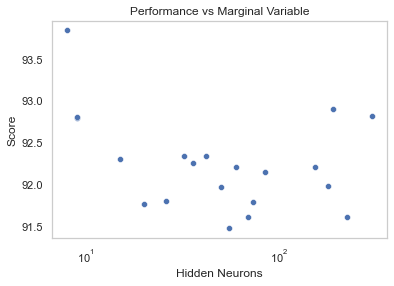

In [505]:
p = sns.scatterplot(x='Hidden Neurons', y='Score', data=hp_current_and_previous_3_df)
plt.title("Performance vs Marginal Variable")
p.set(xscale="log")

plt.show()

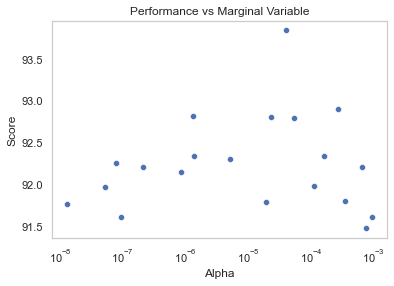

In [506]:
p = sns.scatterplot(x='Alpha', y='Score', data=hp_current_and_previous_3_df)
plt.title("Performance vs Marginal Variable")
p.set(xscale="log")

plt.show()

In [49]:
# Create and fit a MLP Regressor. Use combined training and validation dataset.

model = MLPRegressor(random_state = 15217, 
                     hidden_layer_sizes = (55,1), 
                     alpha = 0.00074,
                     batch_size = 180,
                     learning_rate_init = 0.001,
                     early_stopping=True, 
                     n_iter_no_change = 5)

model.fit(X_current_and_previous_3_train_val_norm, y_current_and_previous_3_train_val_norm.ravel())

# evaluate model on test set
prediction = model.predict(X_current_and_previous_3_test_norm)
prediction = y_current_and_previous_3_train_val_scaler.inverse_transform(prediction.reshape(-1,1))
actual = y_current_and_previous_3_test.to_numpy()

best_current_and_previous_3_mlpr_rmse = mean_squared_error(actual, prediction, squared=False)
best_current_and_previous_3_mlpr_rmse


89.71480774148012

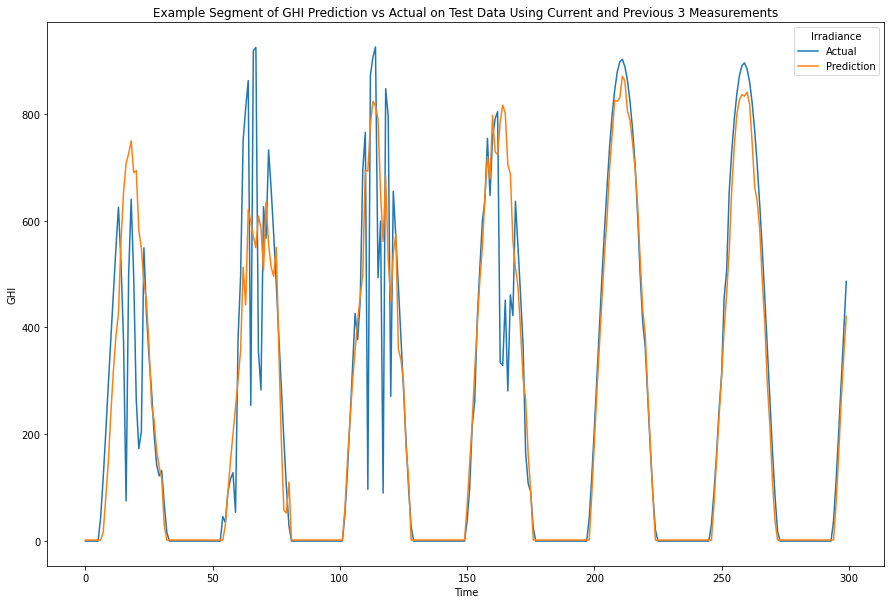

In [50]:
plot_df = pd.DataFrame({'Actual' : actual[100:400,0], 'Prediction' : prediction[100:400,0]})
plot_df = plot_df.reset_index().melt('index', var_name='Irradiance', value_name='GHI')

fig = plt.figure(figsize=(15,10))
sns.lineplot(data=plot_df, x='index', y='GHI', hue='Irradiance')
plt.xlabel('Time')
plt.title('Example Segment of GHI Prediction vs Actual on Test Data Using Current and Previous 3 Measurements')
plt.show()